<a href="https://colab.research.google.com/github/mjkleiman/streamlineAD/blob/master/KleimanPhD_Chp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

!pip install eli5
!pip install rfpimp

from google.colab import drive
drive.mount('/content/gdrive')
dir='/content/gdrive/My Drive/Dissertation/'

device_name = tf.test.gpu_device_name() # Make sure the GPU is running on Colab
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


     |████████████████████████████████| 102kB 4.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/c7/35/67/4065afd69df4c0be693ecdec8a9c1433a23f80ee60395272ba
Successfully built rfpimp
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Found GPU at: /device:GPU:0


# Prelims

In [0]:
adni_X = pd.read_csv(f'{dir}/Data/adni_X_scale.csv')
adni_y2 = pd.read_csv(f'{dir}/Data/adni_y2.csv')
adni_y3 = pd.read_csv(f'{dir}/Data/adni_y3.csv')

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, train_test_split as split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score
import xgboost
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
import matplotlib.pyplot as plt
import rfpimp

%matplotlib inline
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})


def ehr_analyses(X, y, k=5, random_state=0):
  '''Runs a series of boilerplate analyses on data using stratified k-fold CV (default=5)
  Output is a dataframe with mean scores of analyses. Arrays of cross validation
  can be called using scores_'analysis abbreviation' i.e. "scores_rf"
  '''
  df = pd.DataFrame(columns=['analysis','mean accuracy','AUC'])
  cv = StratifiedKFold(n_splits=k)
  
  #Random Forest
  rf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)

  y_pred = cross_val_predict(rf, X, y.values.ravel(), cv=cv)
  print('~~Random Forest~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred),'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
  
  #XGBoost
  xgb = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)

  y_pred = cross_val_predict(xgb, X, y.values.ravel(), cv=cv)
  print('~~XGBoost~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'XGBoost','mean accuracy':accuracy_score(y, y_pred),'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
  
  #Logistic Regression
  lr = LogisticRegression(solver='liblinear', max_iter=10000, multi_class='auto', random_state=random_state)

  y_pred = cross_val_predict(lr, X, y.values.ravel(), cv=cv)
  print('~~Logistic Regression~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'LogRegression','mean accuracy':accuracy_score(y, y_pred), 'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
  
  #SVM
  svm = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=10000, random_state=random_state)

  y_pred = cross_val_predict(svm, X, y.values.ravel(), cv=cv)
  print('~~SVM~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'SVM','mean accuracy':accuracy_score(y, y_pred), 'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
 
  #MLP
  mlp = MLPClassifier(hidden_layer_sizes=(105,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=random_state)
 
  y_pred = cross_val_predict(mlp, X, y.values.ravel(), cv=cv)
  print('~~MLP~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('AUC: \t\t', roc_auc_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'MLP','mean accuracy':accuracy_score(y, y_pred), 'AUC':roc_auc_score(y, y_pred)}, ignore_index=True)
  
  return df

def ehr_analyses3(X, y, k=5, random_state=0):
  '''Runs a series of boilerplate analyses on data using stratified k-fold CV (default=5)
  Output is a dataframe with mean scores of analyses. Arrays of cross validation
  can be called using scores_'analysis abbreviation' i.e. "scores_rf"
  '''
  df = pd.DataFrame(columns=['analysis','mean accuracy'])
  cv = StratifiedKFold(n_splits=k)
  
  #Random Forest
  rf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)

  y_pred = cross_val_predict(rf, X, y.values.ravel(), cv=cv)
  print('~~Random Forest~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
  
  #XGBoost
  xgb = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)

  y_pred = cross_val_predict(xgb, X, y.values.ravel(), cv=cv)
  print('~~XGBoost~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
  
  #Logistic Regression
  lr = LogisticRegression(solver='liblinear', max_iter=10000, multi_class='auto', random_state=random_state)

  y_pred = cross_val_predict(lr, X, y.values.ravel(), cv=cv)
  print('~~Logistic Regression~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
  
  #SVM
  svm = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, max_iter=10000, random_state=random_state)

  y_pred = cross_val_predict(svm, X, y.values.ravel(), cv=cv)
  print('~~SVM~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
 
  #MLP
  mlp = MLPClassifier(hidden_layer_sizes=(105,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=random_state)
  scores_mlp = cross_val_score(mlp, X, y.values.ravel(), cv=cv, n_jobs=1)
    
  y_pred = cross_val_predict(mlp, X, y.values.ravel(), cv=cv)
  print('~~MLP~~')
  print(confusion_matrix(y, y_pred))
  print('Accuracy: \t', accuracy_score(y, y_pred))
  print('Kappa: \t\t', cohen_kappa_score(y, y_pred))
  print('Precision: \t', precision_score(y, y_pred))
  print('Recall: \t', recall_score(y, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y, y_pred)}, ignore_index=True)
  
  return df



def ehr_feature(X, y, clf='rf', random_state=0, test_size=0.2):
  '''
  Plots and notes the feature importances using two consecutive methods:
    Permutation importance (in which a variable is replaced with noise) and
    Drop-column importance (in which a variable is dropped completely from the
    model)
    
  Classifier can be either random forest ('rf') or xgboost ('xgb')
  
  '''
  X_train, X_test, y_train, y_test = split(X, y.values.ravel(), test_size=test_size, random_state=random_state)
  
  # Select classifier ('rf' or 'xgb')
  if clf == 'rf':
    clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)
  elif clf == 'xgb':
    clf = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)
  else:
    print('Use either random forest (rf) or XGBoost (xgb)')
    raise 
  clf.fit(X_train, y_train) # Fit chosen classifier with training data
  
  perm = PermutationImportance(clf, cv=None, refit=False, n_iter=30).fit(X_test, y_test)
  df = pd.DataFrame({'Feature': X_test.columns, 'PermImportance': perm.feature_importances_}) \
            .sort_values('PermImportance', ascending = False) \
            .reset_index(drop = True)
  sns.barplot(x = 'PermImportance', y = 'Feature', data = df.head(20), orient = 'h', color = 'royalblue').set_title('Permutation feature importance', fontsize = 20)
  plt.show();plt.clf()
  
  drop = rfpimp.dropcol_importances(clf, X_train, y_train, X_valid=X_test, y_valid=y_test)
  drop.reset_index(inplace=True)
  drop.rename({'Importance':'DropImportance'}, axis=1, inplace=True)
  sns.barplot(x = 'DropImportance', y = 'Feature', data = drop.head(20), orient = 'h', color = 'firebrick').set_title('Drop column feature importance', fontsize = 20)
  plt.show();plt.clf()
  
  df = df.merge(drop, on='Feature', how='left')
  return df

In [0]:
def paired_analyses(X_train, y_train, X_test, y_test, random_state=0):
  df = pd.DataFrame(columns=['analysis','mean accuracy'])
  
  #Random Forest
  rf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)
  rf.fit(X_train, y_train.values.ravel())
  
  y_pred = rf.predict(X_test)
  print('~~Random Forest~~')
  print(confusion_matrix(y_test, y_pred))
  print('Accuracy: \t', accuracy_score(y_test, y_pred))
  print('AUC: \t\t', roc_auc_score(y_test, y_pred))
  print('Precision: \t', precision_score(y_test, y_pred))
  print('Recall: \t', recall_score(y_test, y_pred))
  print('\n')
  df = df.append({'analysis':'Random Forest','mean accuracy':accuracy_score(y_test, y_pred), 'AUC':roc_auc_score(y_test, y_pred)}, ignore_index=True)
  
  #XGBoost
  xgb = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)
  xgb.fit(X_train, y_train.values.ravel())
  
  y_pred = xgb.predict(X_test)
  print('~~XGBoost~~')
  print(confusion_matrix(y_test, y_pred))
  print('Accuracy: \t', accuracy_score(y_test, y_pred))
  print('AUC: \t\t', roc_auc_score(y_test, y_pred))
  print('Precision: \t', precision_score(y_test, y_pred))
  print('Recall: \t', recall_score(y_test, y_pred))
  print('\n')
  df = df.append({'analysis':'XGBoost','mean accuracy':accuracy_score(y_test, y_pred),'AUC':roc_auc_score(y_test, y_pred)}, ignore_index=True)
  
  #MLP
  mlp = MLPClassifier(hidden_layer_sizes=(105,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=random_state)
  mlp.fit(X_train, y_train.values.ravel())

  y_pred = mlp.predict(X_test)
  print('~~MLP~~')
  print(confusion_matrix(y_test, y_pred))
  print('Accuracy: \t', accuracy_score(y_test, y_pred))
  print('AUC: \t\t', roc_auc_score(y_test, y_pred))
  print('Precision: \t', precision_score(y_test, y_pred))
  print('Recall: \t', recall_score(y_test, y_pred))
  print('\n')
  df = df.append({'analysis':'MLP','mean accuracy':accuracy_score(y_test, y_pred),'AUC':roc_auc_score(y_test, y_pred)}, ignore_index=True)
  
  return df

def paired_feature(X_train, y_train, X_test, y_test, clf='rf', random_state=0):
  if clf == 'rf':
    clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=random_state)
  elif clf == 'xgb':
    clf = xgboost.XGBClassifier(objective='binary:logistic', random_state=random_state)
  else:
    print('Use either random forest (rf) or XGBoost (xgb)')
    raise 
  clf.fit(X_train, y_train.values.ravel()) # Fit chosen classifier with training data
  
  perm = PermutationImportance(clf, cv=None, refit=False, n_iter=30).fit(X_test, y_test)
  df = pd.DataFrame({'Feature': X_test.columns, 'PermImportance': perm.feature_importances_}) \
            .sort_values('PermImportance', ascending = False) \
            .reset_index(drop = True)
  sns.barplot(x = 'PermImportance', y = 'Feature', data = df.head(20), orient = 'h', color = 'royalblue').set_title('Permutation feature importance', fontsize = 20)
  plt.show(); plt.clf()
  
  drop = rfpimp.dropcol_importances(clf, X_train, y_train.values.ravel(), X_valid=X_test, y_valid=y_test)
  drop.reset_index(inplace=True)
  drop.rename({'Importance':'DropImportance'}, axis=1, inplace=True)
  sns.barplot(x = 'DropImportance', y = 'Feature', data = drop.head(20), orient = 'h', color = 'firebrick').set_title('Drop column feature importance', fontsize = 20)
  plt.show(); plt.clf()
  
  df = df.merge(drop, on='Feature', how='left')
  return df


# Domains - ADNI

### Short Term Memory

In [0]:
stm = ['ADAS_Q1','moca_orient','ADAS_Q7','ADAS_Q8','ADAS_Q9','MMDATE',
       'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR',
       'MMCITY', 'MMAREA', 'MMSTATE','CDR_orient','AVTOT1', 'AVTOT2', 'AVTOT3',
       'AVTOT4', 'AVTOT5', 'AVTOT6','nbspan_forward','LIMMTOTAL','vlt_recall',
       'q_orient_pt','q_orient_cg']

adni_stm = adni_X.loc[:,stm]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[298  86]
 [ 86 622]]
Accuracy: 	 0.8424908424908425
AUC: 		 0.8272863700564972
Kappa: 		 0.6545727401129944
F1 score: 	 0.8785310734463276


~~XGBoost~~
[[310  74]
 [ 93 615]]
Accuracy: 	 0.8470695970695971
AUC: 		 0.8379678672316384
Kappa: 		 0.6683687943262411
F1 score: 	 0.8804581245526127


~~Logistic Regression~~
[[300  84]
 [ 83 625]]
Accuracy: 	 0.8470695970695971
AUC: 		 0.8320091807909604
Kappa: 		 0.6644142652092304
F1 score: 	 0.8821453775582216


~~SVM~~
[[307  77]
 [ 86 622]]
Accuracy: 	 0.8507326007326007
AUC: 		 0.8390051200564972
Kappa: 		 0.6743935901657337
F1 score: 	 0.8841506751954513


~~MLP~~
[[303  81]
 [ 85 623]]
Accuracy: 	 0.847985347985348
AUC: 		 0.8345030014124294
Kappa: 		 0.6674152355790401
F1 score: 	 0.8824362606232293



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



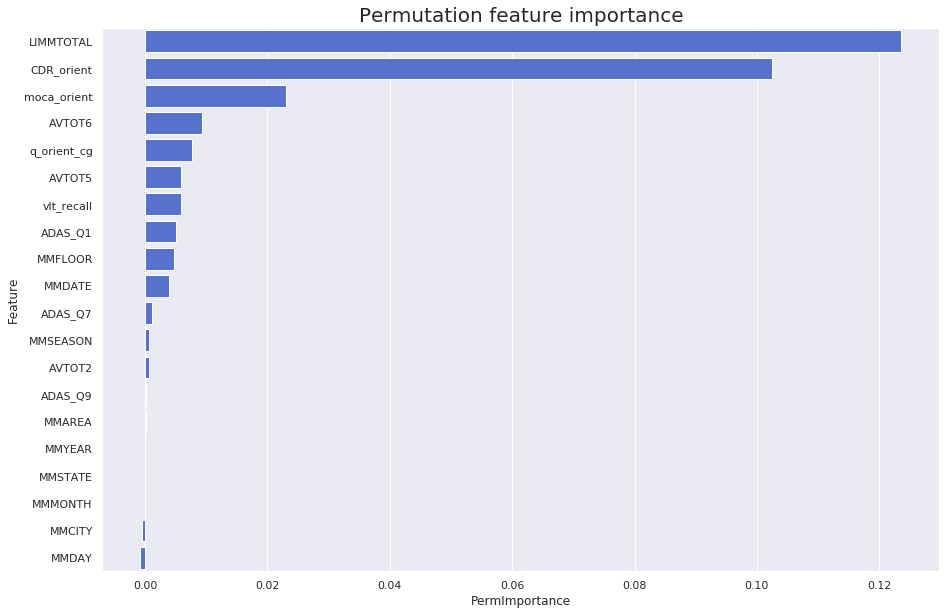

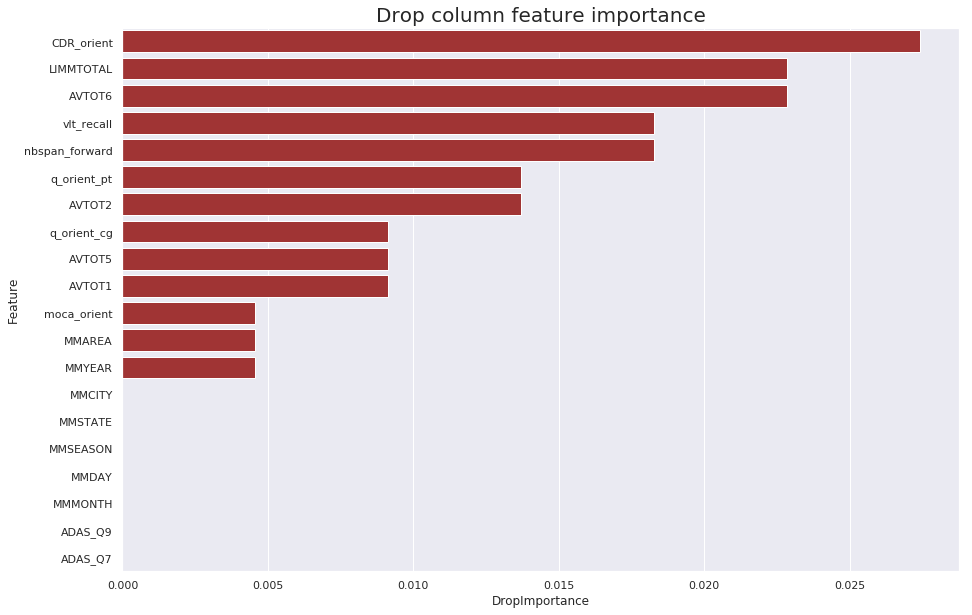


~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~

~~Random Forest~~
[[298  86   0]
 [ 85 401  34]
 [  2  42 144]]
Accuracy: 	 0.771978021978022
Kappa: 		 0.6305999347896968


~~XGBoost~~
[[307  77   0]
 [107 367  46]
 [  3  41 144]]
Accuracy: 	 0.7490842490842491
Kappa: 		 0.5980634483944461


~~Logistic Regression~~
[[290  94   0]
 [ 91 399  30]
 [  3  49 136]]
Accuracy: 	 0.7554945054945055
Kappa: 		 0.6016667577463249


~~SVM~~
[[294  90   0]
 [ 85 399  36]
 [  2  50 136]]
Accuracy: 	 0.7591575091575091
Kappa: 		 0.6084815634781281


~~MLP~~
[[309  75   0]
 [ 77 414  29]
 [  0  44 144]]
Accuracy: 	 0.7939560439560439
Kappa: 		 0.6655122277947495



~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~



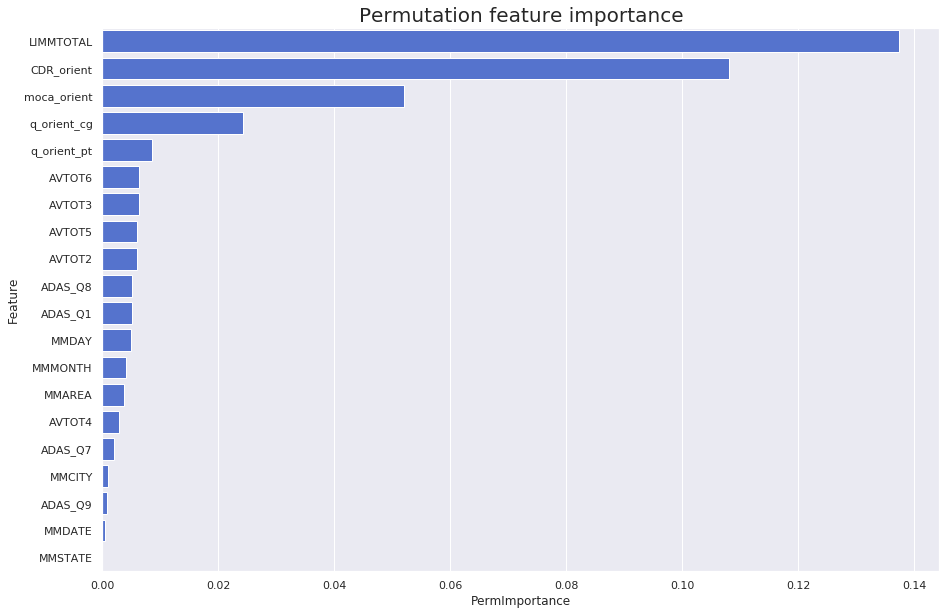

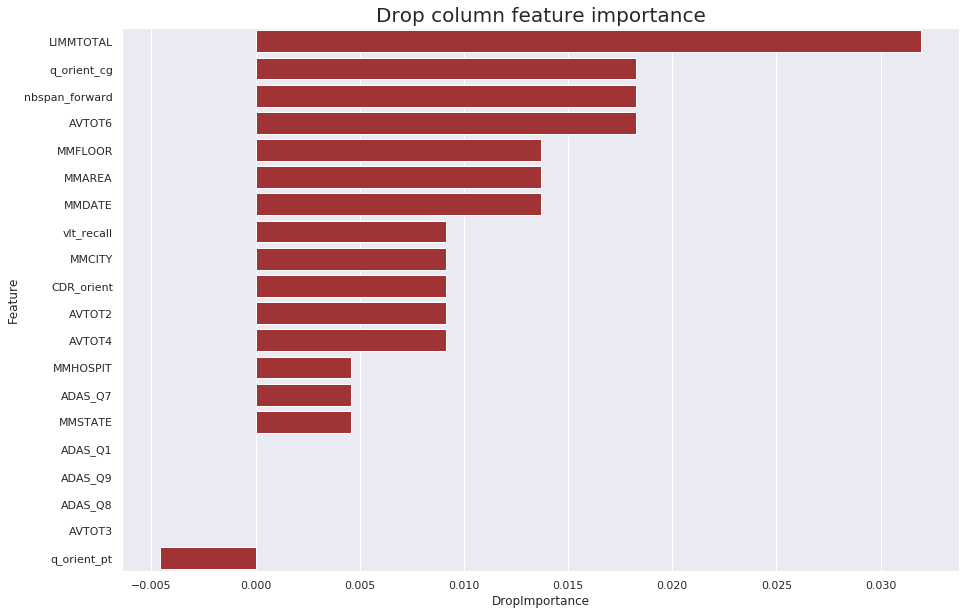

<Figure size 1080x720 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_stm_2 = ehr_analyses(adni_stm, adni_y2)
ehr_stm_2.to_csv(f'{dir}/Output/ehr_stm_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_stm_2 = ehr_feature(adni_stm, adni_y2)
features_stm_2.to_csv(f'{dir}/Output/features_stm_2.csv', index=False)
#### Predictive Analyses (3)
print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
ehr_stm_3 = ehr_analyses3(adni_stm, adni_y3)
ehr_stm_3.to_csv(f'{dir}/Output/ehr_stm_3.csv', index=False)
#### Feature Analyses (3)
print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
features_stm_3 = ehr_feature(adni_stm, adni_y3)
features_stm_3.to_csv(f'{dir}/Output/features_stm_3.csv', index=False)


### Long Term (delay) Memory

In [0]:

ltm = ['moca_recall','ADAS_Q4','MMBALLDL', 'MMFLAGDL', 'MMTREEDL','CDR_memory', 'LDELTOTAL', 'AVDEL30MIN', 'AVDELTOT', 'AVDELERR2',
      'q_memory_pt','q_memory_cg']
adni_ltm = adni_X.loc[:,ltm]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[362  22]
 [ 30 678]]
Accuracy: 	 0.9523809523809523
AUC: 		 0.9501677259887007
Kappa: 		 0.8960639606396064
F1 score: 	 0.9630681818181818


~~XGBoost~~
[[361  23]
 [ 29 679]]
Accuracy: 	 0.9523809523809523
AUC: 		 0.9495718573446327
Kappa: 		 0.8959405374499714
F1 score: 	 0.9631205673758866


~~Logistic Regression~~
[[358  26]
 [ 32 676]]
Accuracy: 	 0.9468864468864469
AUC: 		 0.9435469632768361
Kappa: 		 0.8839336763865066
F1 score: 	 0.9588652482269504


~~SVM~~
[[375   9]
 [ 29 679]]
Accuracy: 	 0.9652014652014652
AUC: 		 0.9678010240112994
Kappa: 		 0.9245834423798307
F1 score: 	 0.9727793696275071


~~MLP~~
[[356  28]
 [ 28 680]]
Accuracy: 	 0.9487179487179487
AUC: 		 0.9437676553672317
Kappa: 		 0.8875353107344632
F1 score: 	 0.96045197740113



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



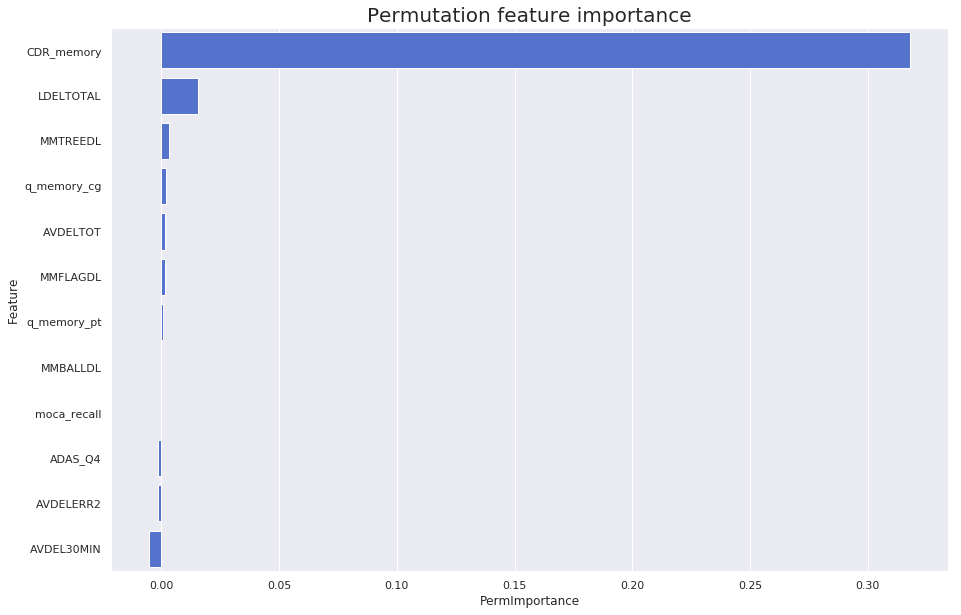

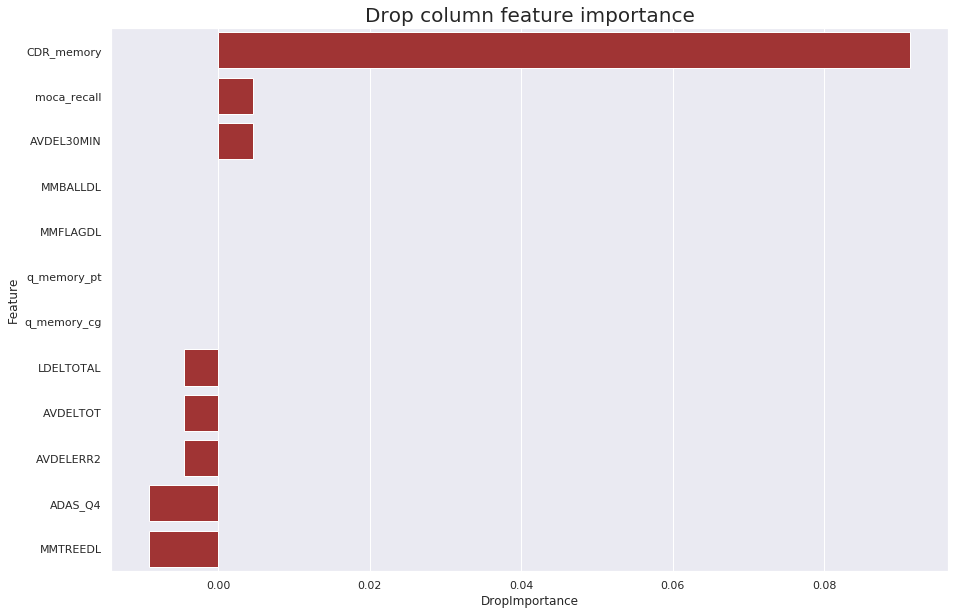


~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~

~~Random Forest~~
[[367  17   0]
 [ 27 449  44]
 [  2  59 127]]
Accuracy: 	 0.8635531135531136
Kappa: 		 0.7787044441905633


~~XGBoost~~
[[362  21   1]
 [ 26 452  42]
 [  2  54 132]]
Accuracy: 	 0.8663003663003663
Kappa: 		 0.7833109529686149


~~Logistic Regression~~
[[364  20   0]
 [ 30 448  42]
 [  2  72 114]]
Accuracy: 	 0.847985347985348
Kappa: 		 0.7517746812146707


~~SVM~~
[[375   9   0]
 [ 27 447  46]
 [  2  69 117]]
Accuracy: 	 0.8598901098901099
Kappa: 		 0.772277983437011


~~MLP~~
[[358  26   0]
 [ 23 457  40]
 [  2  54 132]]
Accuracy: 	 0.8672161172161172
Kappa: 		 0.7842238381283592



~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~



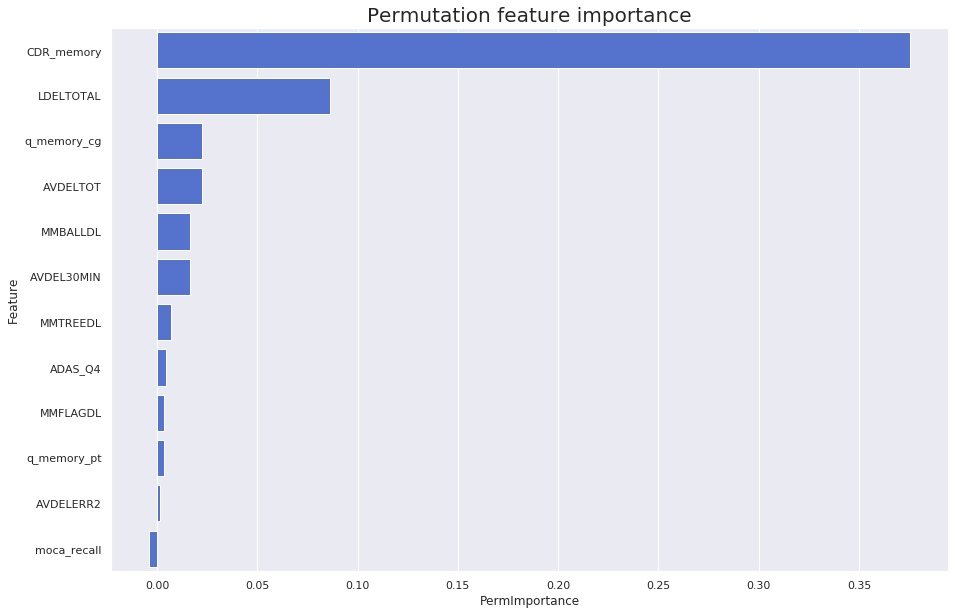

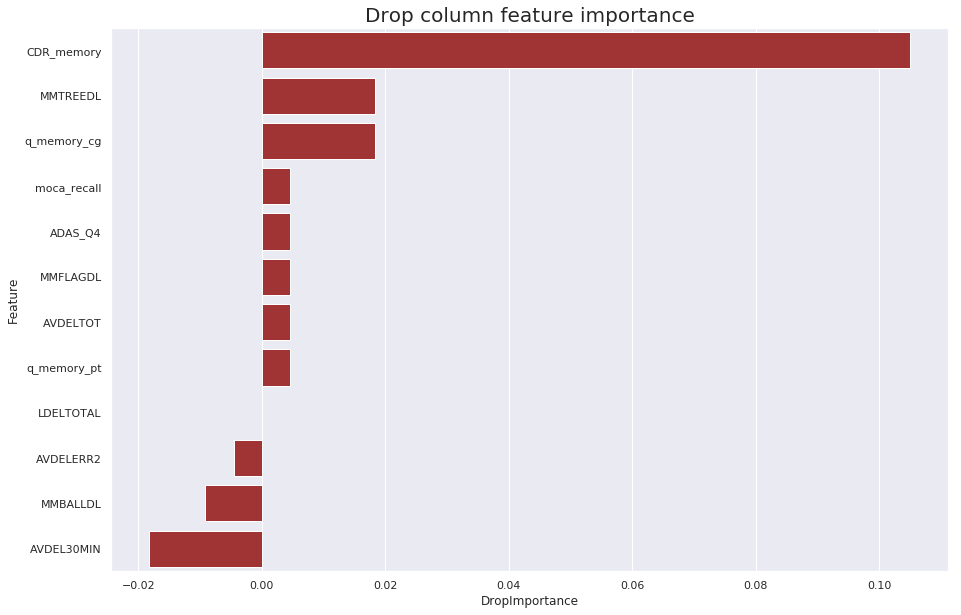

<Figure size 1080x720 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_ltm_2 = ehr_analyses(adni_ltm, adni_y2)
ehr_ltm_2.to_csv(f'{dir}/Output/ehr_ltm_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_ltm_2 = ehr_feature(adni_ltm, adni_y2)
features_ltm_2.to_csv(f'{dir}/Output/features_ltm_2.csv', index=False)
#### Predictive Analyses (3)
print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
ehr_ltm_3 = ehr_analyses3(adni_ltm, adni_y3)
ehr_ltm_3.to_csv(f'{dir}/Output/ehr_ltm_3.csv', index=False)
#### Feature Analyses (3)
print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
features_ltm_3 = ehr_feature(adni_ltm, adni_y3)
features_ltm_3.to_csv(f'{dir}/Output/features_ltm_3.csv', index=False)


### Attention

In [0]:

att = ['moca_digits','moca_letters','moca_serial7','MMD',
       'MML', 'MMR', 'MMO', 'MMW','q_attention_pt','q_attention_cg']
adni_att = adni_X.loc[:,att]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[265 119]
 [168 540]]
Accuracy: 	 0.7371794871794872
AUC: 		 0.7264080155367232
Kappa: 		 0.43996997962903395
F1 score: 	 0.7900512070226773


~~XGBoost~~
[[272 112]
 [163 545]]
Accuracy: 	 0.7481684981684982
AUC: 		 0.7390536723163842
Kappa: 		 0.4640065111696545
F1 score: 	 0.7985347985347985


~~Logistic Regression~~
[[265 119]
 [161 547]]
Accuracy: 	 0.7435897435897436
AUC: 		 0.731351518361582
Kappa: 		 0.4514059337725531
F1 score: 	 0.7962154294032023


~~SVM~~
[[274 110]
 [173 535]]
Accuracy: 	 0.7408424908424909
AUC: 		 0.7345956920903954
Kappa: 		 0.45221534469189373
F1 score: 	 0.7908351810790836


~~MLP~~
[[253 131]
 [142 566]]
Accuracy: 	 0.75
AUC: 		 0.7291445974576272
Kappa: 		 0.4553048740380188
F1 score: 	 0.805693950177936



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



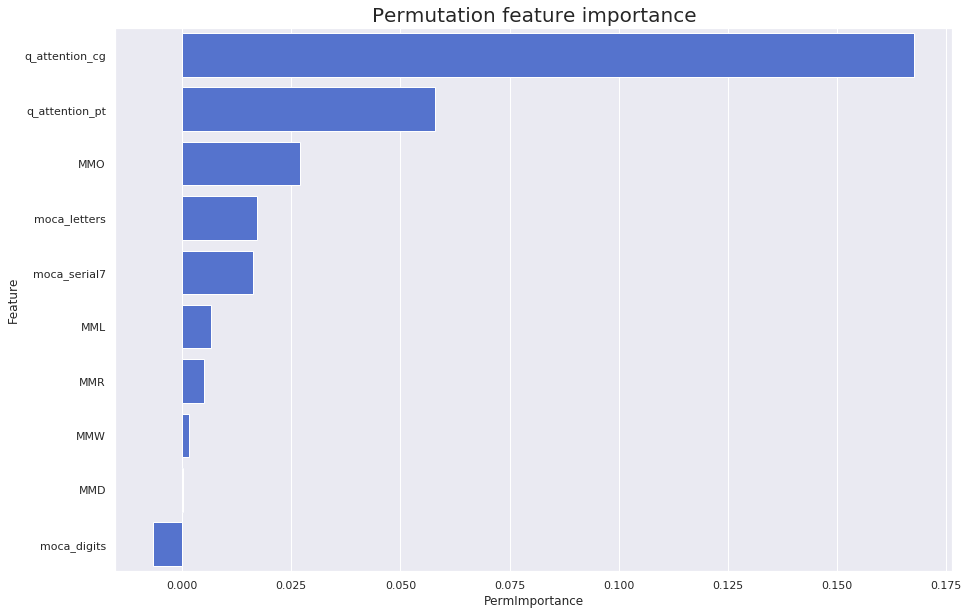

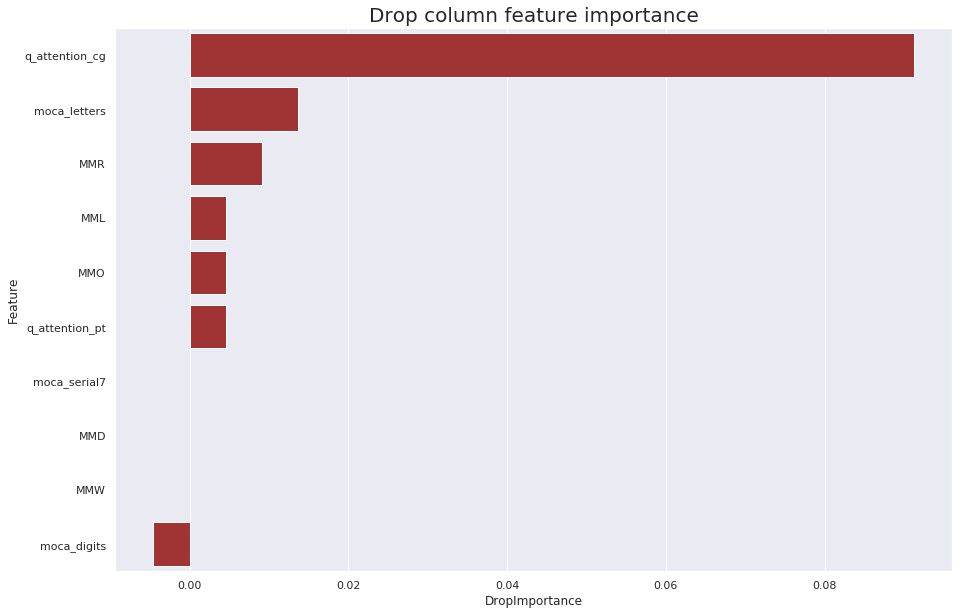


~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~

~~Random Forest~~
[[267 112   5]
 [158 316  46]
 [ 13  84  91]]
Accuracy: 	 0.6172161172161172
Kappa: 		 0.3758600697900828


~~XGBoost~~
[[276 105   3]
 [163 329  28]
 [ 11  96  81]]
Accuracy: 	 0.6282051282051282
Kappa: 		 0.38679516685845794


~~Logistic Regression~~
[[266 115   3]
 [150 341  29]
 [ 11  86  91]]
Accuracy: 	 0.6391941391941391
Kappa: 		 0.4053504198846769


~~SVM~~
[[286  92   6]
 [173 313  34]
 [ 11  85  92]]
Accuracy: 	 0.6327838827838828
Kappa: 		 0.40208747514910537


~~MLP~~
[[266 115   3]
 [150 333  37]
 [  9  83  96]]
Accuracy: 	 0.6364468864468864
Kappa: 		 0.40415296821225555



~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~



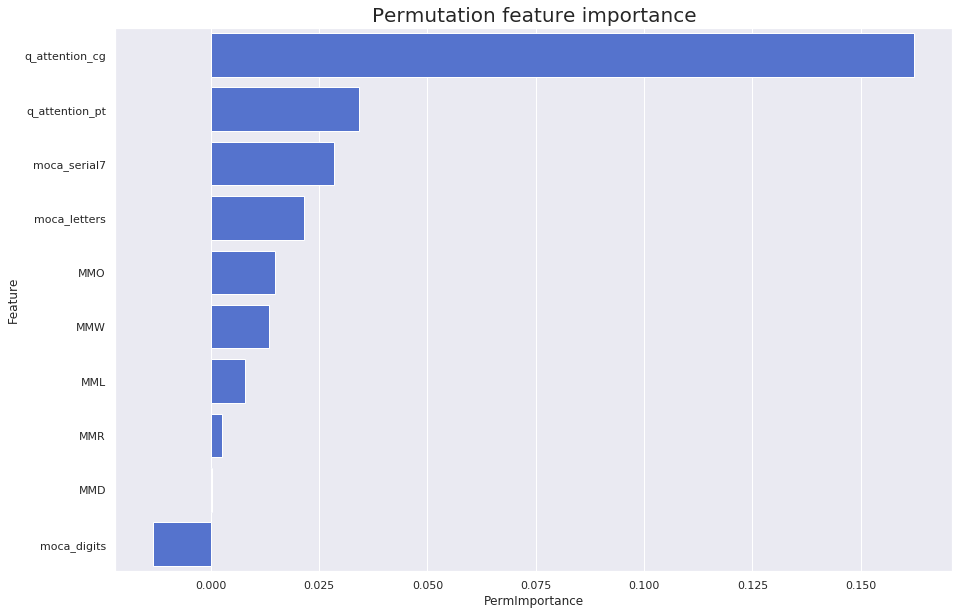

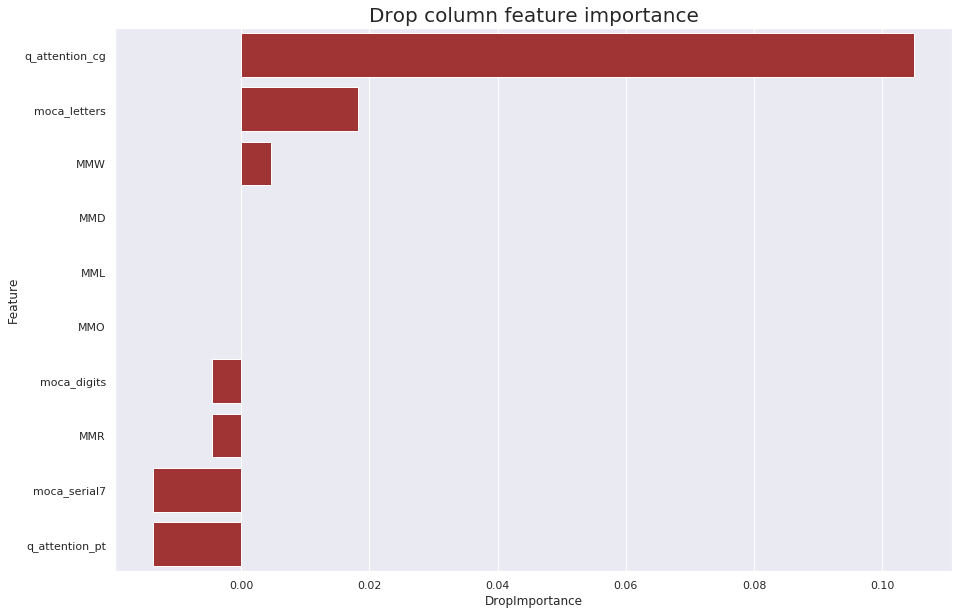

<Figure size 1080x720 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_att_2 = ehr_analyses(adni_att, adni_y2)
ehr_att_2.to_csv(f'{dir}/Output/ehr_att_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_att_2 = ehr_feature(adni_att, adni_y2)
features_att_2.to_csv(f'{dir}/Output/features_att_2.csv', index=False)
#### Predictive Analyses (3)
print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
ehr_att_3 = ehr_analyses3(adni_att, adni_y3)
ehr_att_3.to_csv(f'{dir}/Output/ehr_att_3.csv', index=False)
#### Feature Analyses (3)
print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
features_att_3 = ehr_feature(adni_att, adni_y3)
features_att_3.to_csv(f'{dir}/Output/features_att_3.csv', index=False)


### Executive Functioning

In [0]:

exf = ['moca_visuo_exec','ADAS_Q3','ADAS_Q6','ADAS_Q13','MMHAND', 'MMFOLD',
       'MMONFLR','CDR_judge','CDR_home','nbspan_backward','q_judgmt_pt',
       'q_judgmt_cg','q_homeact_pt','q_homeact_cg']
adni_exf = adni_X.loc[:,exf]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[294  90]
 [163 545]]
Accuracy: 	 0.7683150183150184
AUC: 		 0.7676995056497176
Kappa: 		 0.51308081128524
F1 score: 	 0.8116157855547282


~~XGBoost~~
[[315  69]
 [164 544]]
Accuracy: 	 0.7866300366300366
AUC: 		 0.794337040960452
Kappa: 		 0.5571359943187751
F1 score: 	 0.8236184708554126


~~Logistic Regression~~
[[312  72]
 [126 582]]
Accuracy: 	 0.8186813186813187
AUC: 		 0.8172669491525424
Kappa: 		 0.6147530468248877
F1 score: 	 0.8546255506607929


~~SVM~~
[[326  58]
 [150 558]]
Accuracy: 	 0.8095238095238095
AUC: 		 0.8185469632768362
Kappa: 		 0.60398359695372
F1 score: 	 0.8429003021148035


~~MLP~~
[[301  83]
 [120 588]]
Accuracy: 	 0.8141025641025641
AUC: 		 0.8071813206214689
Kappa: 		 0.60110988749973
F1 score: 	 0.8527918781725888



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



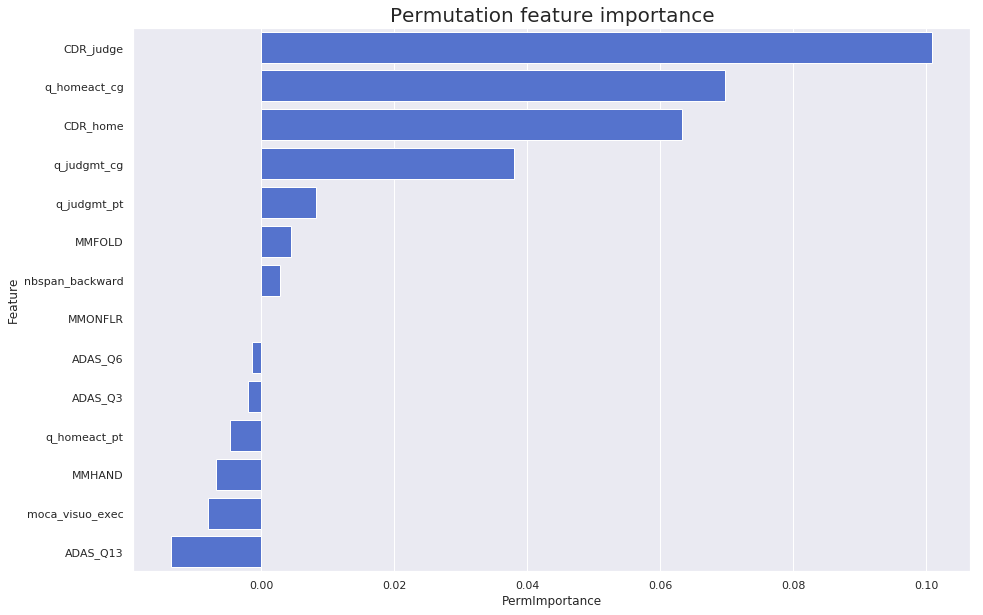

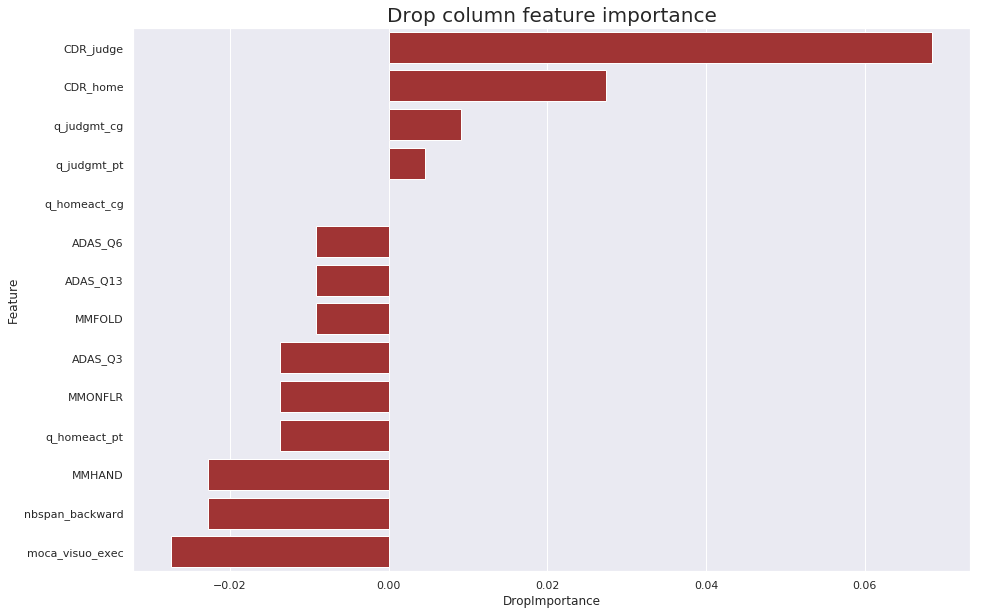


~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~

~~Random Forest~~
[[301  78   5]
 [149 313  58]
 [ 10  62 116]]
Accuracy: 	 0.6684981684981685
Kappa: 		 0.4705362356886843


~~XGBoost~~
[[325  56   3]
 [163 305  52]
 [  6  62 120]]
Accuracy: 	 0.6868131868131868
Kappa: 		 0.5019869103943417


~~Logistic Regression~~
[[312  69   3]
 [135 342  43]
 [  7  72 109]]
Accuracy: 	 0.6987179487179487
Kappa: 		 0.5130735076467687


~~SVM~~
[[325  55   4]
 [146 328  46]
 [ 11  69 108]]
Accuracy: 	 0.6968864468864469
Kappa: 		 0.5132824871537989


~~MLP~~
[[315  68   1]
 [130 349  41]
 [  1  72 115]]
Accuracy: 	 0.7133699633699634
Kappa: 		 0.5364874614187067



~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~



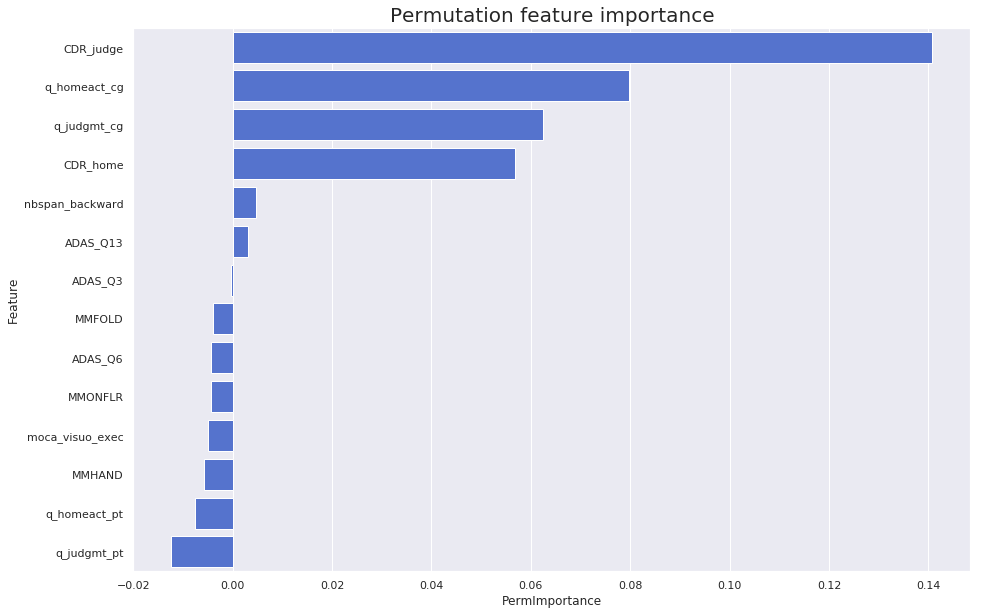

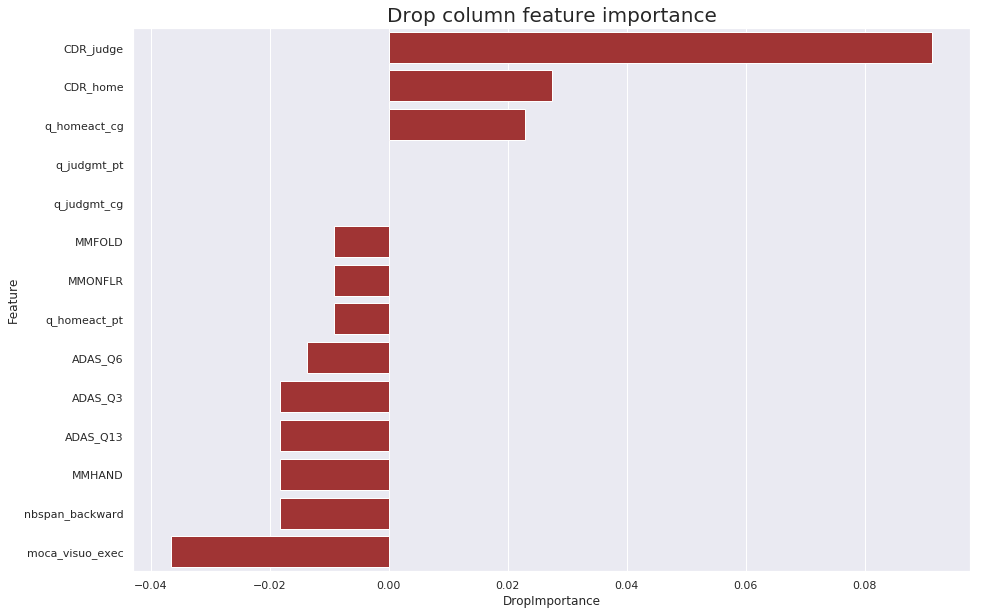

<Figure size 1080x720 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_exf_2 = ehr_analyses(adni_exf, adni_y2)
ehr_exf_2.to_csv(f'{dir}/Output/ehr_exf_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_exf_2 = ehr_feature(adni_exf, adni_y2)
features_exf_2.to_csv(f'{dir}/Output/features_exf_2.csv', index=False)
#### Predictive Analyses (3)
print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
ehr_exf_3 = ehr_analyses3(adni_exf, adni_y3)
ehr_exf_3.to_csv(f'{dir}/Output/ehr_exf_3.csv', index=False)
#### Feature Analyses (3)
print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
features_exf_3 = ehr_feature(adni_exf, adni_y3)
features_exf_3.to_csv(f'{dir}/Output/features_exf_3.csv', index=False)


### Visuospatial

In [0]:

vis = ['moca_clock','MMDRAW','CLOCKCIRC', 'CLOCKSYM',
       'CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME', 'tma_time', 'tmb_time', 'TRAAERRCOM',
       'TRAAERROM', 'TRABERRCOM', 'TRABERROM']
adni_vis = adni_X.loc[:,vis]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[161 223]
 [160 548]]
Accuracy: 	 0.6492673992673993
AUC: 		 0.5966410663841808
Kappa: 		 0.2008208938111944
F1 score: 	 0.7410412440838405


~~XGBoost~~
[[140 244]
 [143 565]]
Accuracy: 	 0.6456043956043956
AUC: 		 0.5813029661016949
Kappa: 		 0.1730186685452625
F1 score: 	 0.7448912326961108


~~Logistic Regression~~
[[100 284]
 [ 97 611]]
Accuracy: 	 0.6510989010989011
AUC: 		 0.5617055084745762
Kappa: 		 0.1388868191639968
F1 score: 	 0.7623206487835308


~~SVM~~
[[ 96 288]
 [ 89 619]]
Accuracy: 	 0.6547619047619048
AUC: 		 0.5621468926553672
Kappa: 		 0.14101504794812092
F1 score: 	 0.76656346749226


~~MLP~~
[[ 11 373]
 [  9 699]]
Accuracy: 	 0.6501831501831502
AUC: 		 0.5079669844632769
Kappa: 		 0.02034719873745927
F1 score: 	 0.7853932584269663



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



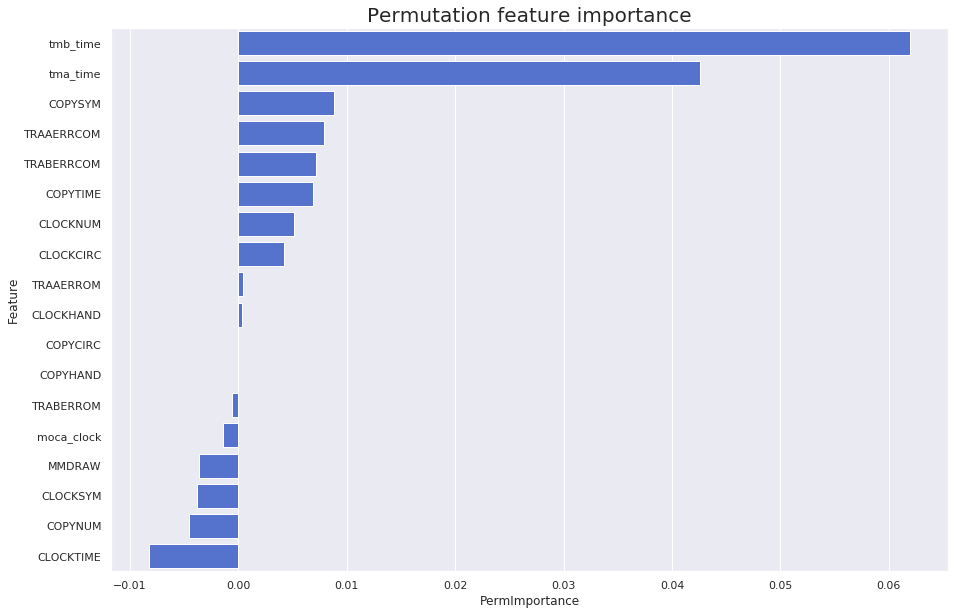

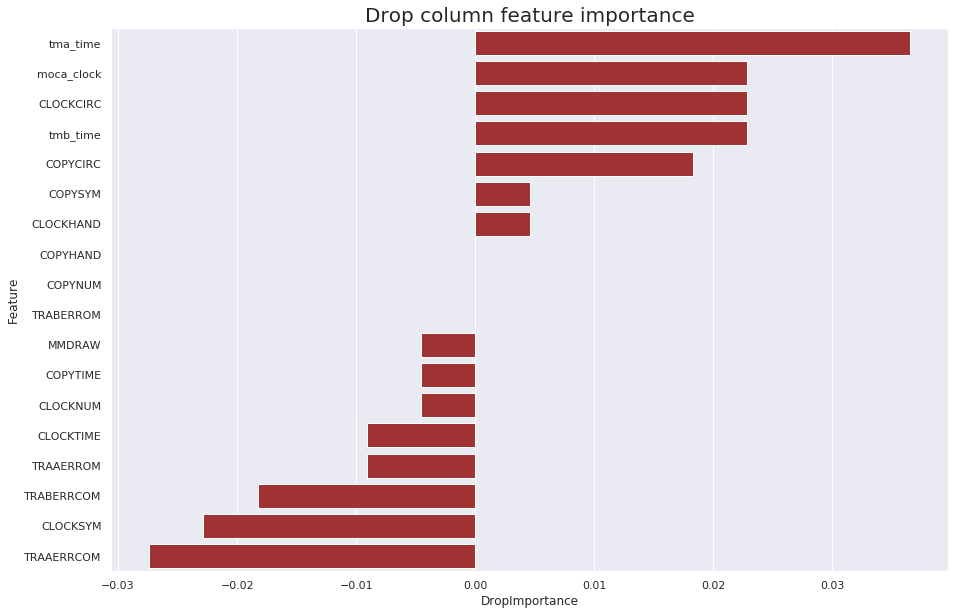


~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~

~~Random Forest~~
[[176 189  19]
 [165 304  51]
 [ 32  95  61]]
Accuracy: 	 0.49542124542124544
Kappa: 		 0.16297277295212864


~~XGBoost~~
[[199 175  10]
 [167 318  35]
 [ 21 110  57]]
Accuracy: 	 0.5256410256410257
Kappa: 		 0.204556193047587


~~Logistic Regression~~
[[147 231   6]
 [130 365  25]
 [ 16 118  54]]
Accuracy: 	 0.5183150183150184
Kappa: 		 0.17078297425118227


~~SVM~~
[[149 230   5]
 [134 364  22]
 [ 14 124  50]]
Accuracy: 	 0.5155677655677655
Kappa: 		 0.16350314228619434


~~MLP~~
[[156 222   6]
 [138 352  30]
 [ 12 117  59]]
Accuracy: 	 0.5192307692307693
Kappa: 		 0.17839433632376966



~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~



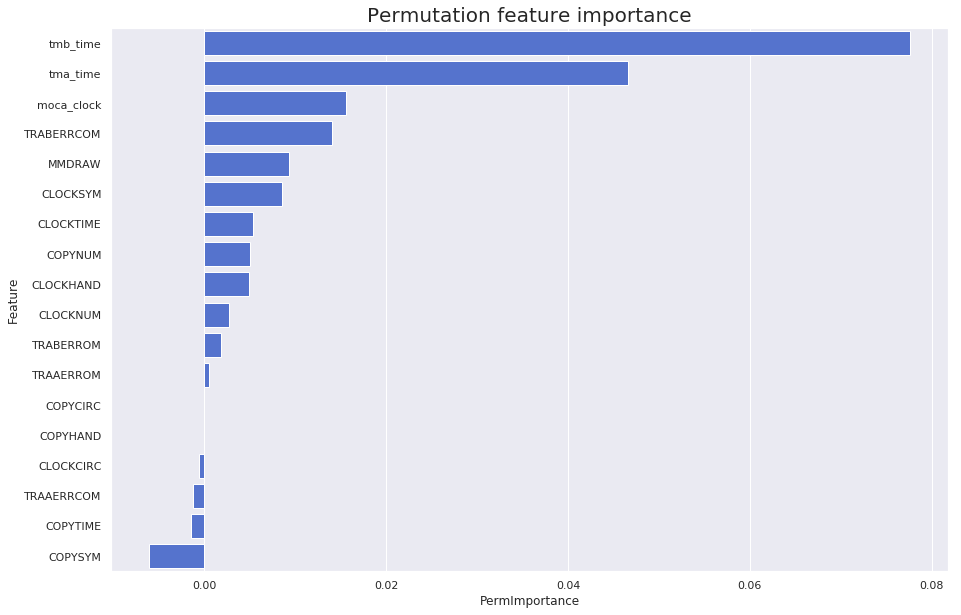

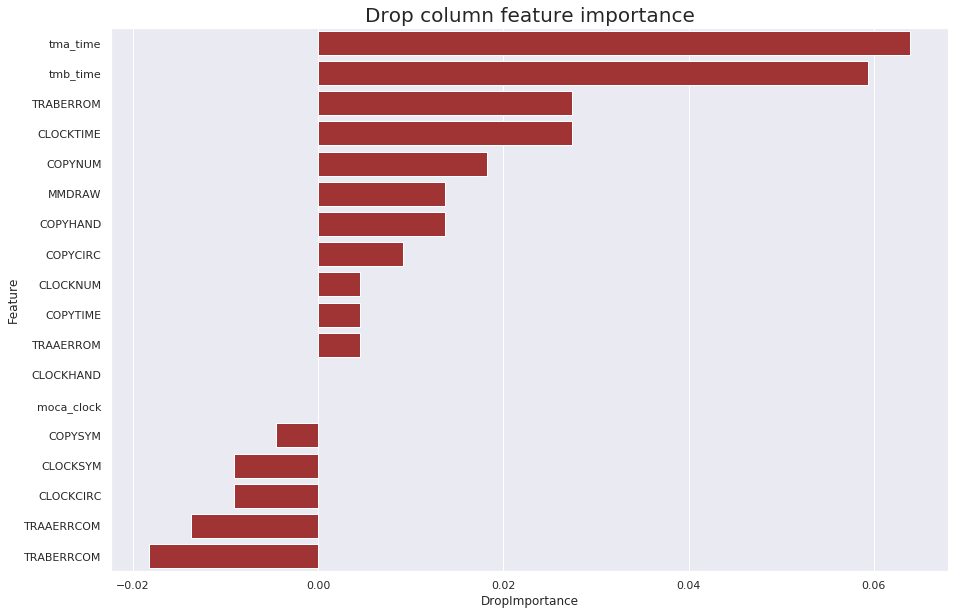

<Figure size 1080x720 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_vis_2 = ehr_analyses(adni_vis, adni_y2)
ehr_vis_2.to_csv(f'{dir}/Output/ehr_vis_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_vis_2 = ehr_feature(adni_vis, adni_y2)
features_vis_2.to_csv(f'{dir}/Output/features_vis_2.csv', index=False)
#### Predictive Analyses (3)
print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
ehr_vis_3 = ehr_analyses3(adni_vis, adni_y3)
ehr_vis_3.to_csv(f'{dir}/Output/ehr_vis_3.csv', index=False)
#### Feature Analyses (3)
print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
features_vis_3 = ehr_feature(adni_vis, adni_y3)
features_vis_3.to_csv(f'{dir}/Output/features_vis_3.csv', index=False)


### Language

In [0]:

lng = ['moca_naming','moca_repeat','moca_fluency','moca_similarities','ADAS_Q2',
       'ADAS_Q5','ADAS_Q10','ADAS_Q11','ADAS_Q12','MMBALL', 'MMFLAG', 'MMTREE',
       'MMWATCH', 'MMPENCIL','MMREPEAT','MMREAD', 'MMWRITE','CDR_comm',
       'CATANIMSC', 'CATVEGESC', 'q_language_pt','q_language_cg']
adni_lng = adni_X.loc[:,lng]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[246 138]
 [154 554]]
Accuracy: 	 0.7326007326007326
AUC: 		 0.7115554378531073
Kappa: 		 0.41911507520111924
F1 score: 	 0.7914285714285714


~~XGBoost~~
[[290  94]
 [174 534]]
Accuracy: 	 0.7545787545787546
AUC: 		 0.7547228107344633
Kappa: 		 0.4862655881361645
F1 score: 	 0.7994011976047906


~~Logistic Regression~~
[[256 128]
 [126 582]]
Accuracy: 	 0.7673992673992674
AUC: 		 0.7443502824858759
Kappa: 		 0.48928366255689604
F1 score: 	 0.8208744710860367


~~SVM~~
[[268 116]
 [147 561]]
Accuracy: 	 0.7591575091575091
AUC: 		 0.7451447740112995
Kappa: 		 0.48139721337407093
F1 score: 	 0.8101083032490975


~~MLP~~
[[248 136]
 [132 576]]
Accuracy: 	 0.7545787545787546
AUC: 		 0.7296963276836157
Kappa: 		 0.4604902221042385
F1 score: 	 0.8112676056338028



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



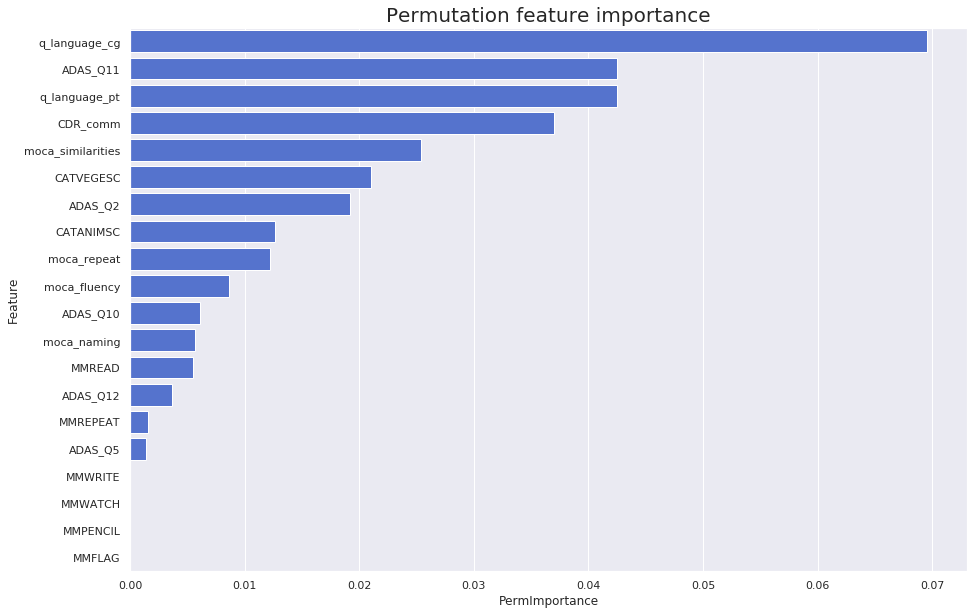

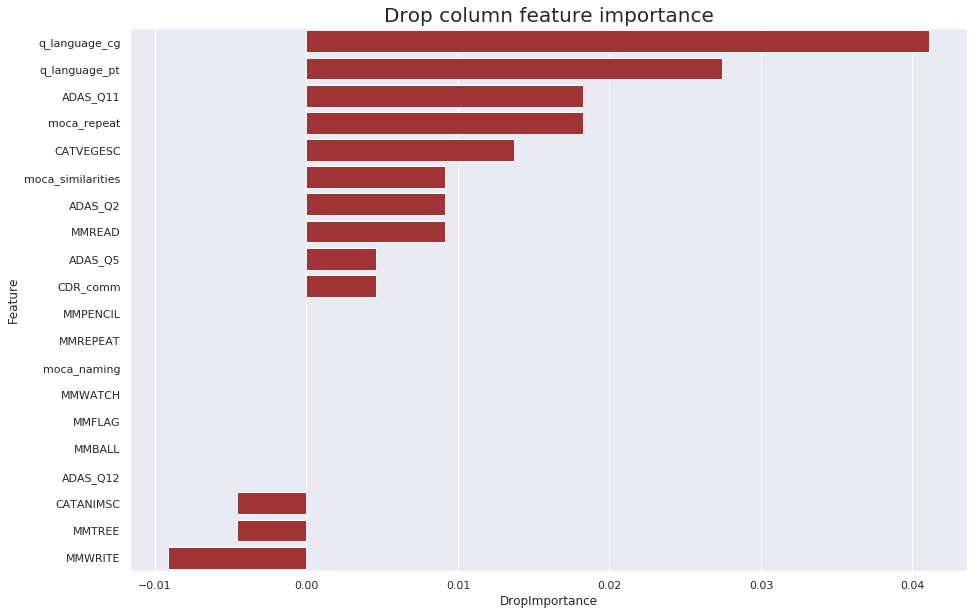


~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~

~~Random Forest~~
[[256 124   4]
 [129 328  63]
 [  9  57 122]]
Accuracy: 	 0.6465201465201466
Kappa: 		 0.4311241153320845


~~XGBoost~~
[[286  95   3]
 [170 284  66]
 [ 13  63 112]]
Accuracy: 	 0.6245421245421245
Kappa: 		 0.4018436873747496


~~Logistic Regression~~
[[259 125   0]
 [133 351  36]
 [ 10  71 107]]
Accuracy: 	 0.6565934065934066
Kappa: 		 0.4365495643750723


~~SVM~~
[[267 116   1]
 [140 331  49]
 [ 10  70 108]]
Accuracy: 	 0.6465201465201466
Kappa: 		 0.42557018882735165


~~MLP~~
[[268 116   0]
 [138 340  42]
 [  5  71 112]]
Accuracy: 	 0.6593406593406593
Kappa: 		 0.4447821903428971



~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~



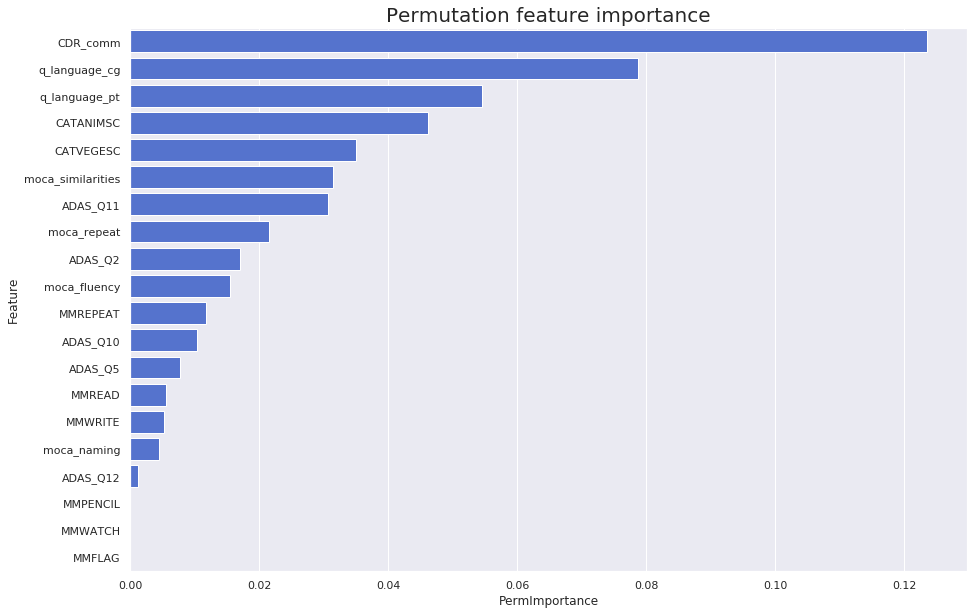

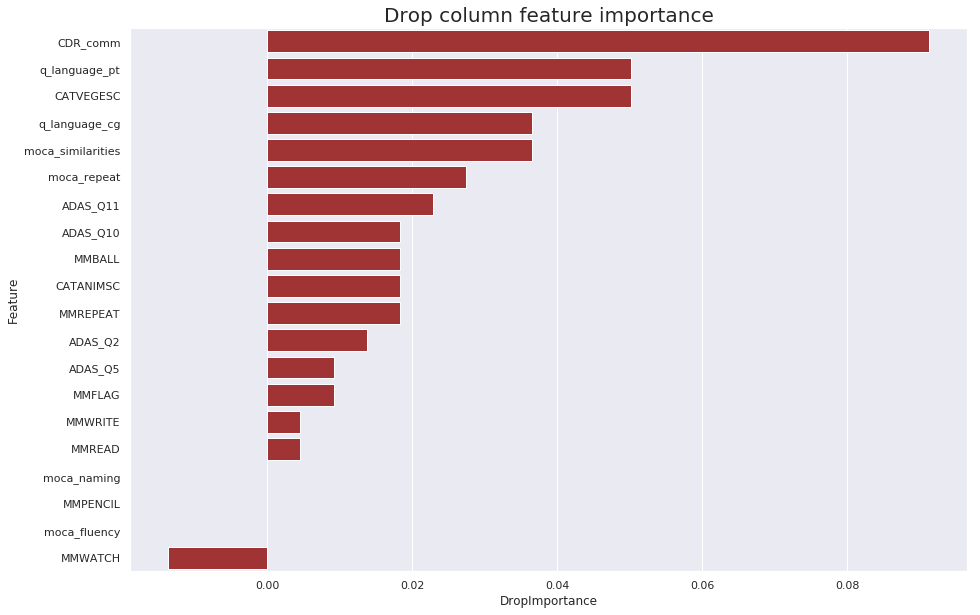

<Figure size 1080x720 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_lng_2 = ehr_analyses(adni_lng, adni_y2)
ehr_lng_2.to_csv(f'{dir}/Output/ehr_lng_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_lng_2 = ehr_feature(adni_lng, adni_y2)
features_lng_2.to_csv(f'{dir}/Output/features_lng_2.csv', index=False)
#### Predictive Analyses (3)
print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
ehr_lng_3 = ehr_analyses3(adni_lng, adni_y3)
ehr_lng_3.to_csv(f'{dir}/Output/ehr_lng_3.csv', index=False)
#### Feature Analyses (3)
print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
features_lng_3 = ehr_feature(adni_lng, adni_y3)
features_lng_3.to_csv(f'{dir}/Output/features_lng_3.csv', index=False)

### All memory


In [0]:

mem = ['ADAS_Q1','moca_orient','ADAS_Q7','ADAS_Q8','ADAS_Q9','MMDATE',
       'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR',
       'MMCITY', 'MMAREA', 'MMSTATE','CDR_orient','AVTOT1', 'AVTOT2', 'AVTOT3',
       'AVTOT4', 'AVTOT5', 'AVTOT6','nbspan_forward','LIMMTOTAL','vlt_recall',
       'q_orient_pt','q_orient_cg','moca_recall','ADAS_Q4','MMBALLDL', 
       'MMFLAGDL', 'MMTREEDL','CDR_memory', 'LDELTOTAL', 'AVDEL30MIN', 
       'AVDELTOT', 'AVDELERR2','q_memory_pt','q_memory_cg']
adni_mem = adni_X.loc[:,mem]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[371  13]
 [ 29 679]]
Accuracy: 	 0.9615384615384616
AUC: 		 0.962592690677966
Kappa: 		 0.9164480587618048
F1 score: 	 0.9699999999999999


~~XGBoost~~
[[366  18]
 [ 29 679]]
Accuracy: 	 0.956959706959707
AUC: 		 0.9560822740112994
Kappa: 		 0.906224648643908
F1 score: 	 0.9665480427046262


~~Logistic Regression~~
[[358  26]
 [ 27 681]]
Accuracy: 	 0.9514652014652014
AUC: 		 0.9470780367231637
Kappa: 		 0.893623591168751
F1 score: 	 0.9625441696113073


~~SVM~~
[[372  12]
 [ 29 679]]
Accuracy: 	 0.9624542124542125
AUC: 		 0.9638947740112994
Kappa: 		 0.9184855039216971
F1 score: 	 0.9706933523945676


~~MLP~~
[[358  26]
 [ 25 683]]
Accuracy: 	 0.9532967032967034
AUC: 		 0.9484904661016949
Kappa: 		 0.8975157336866512
F1 score: 	 0.9640084685956245



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



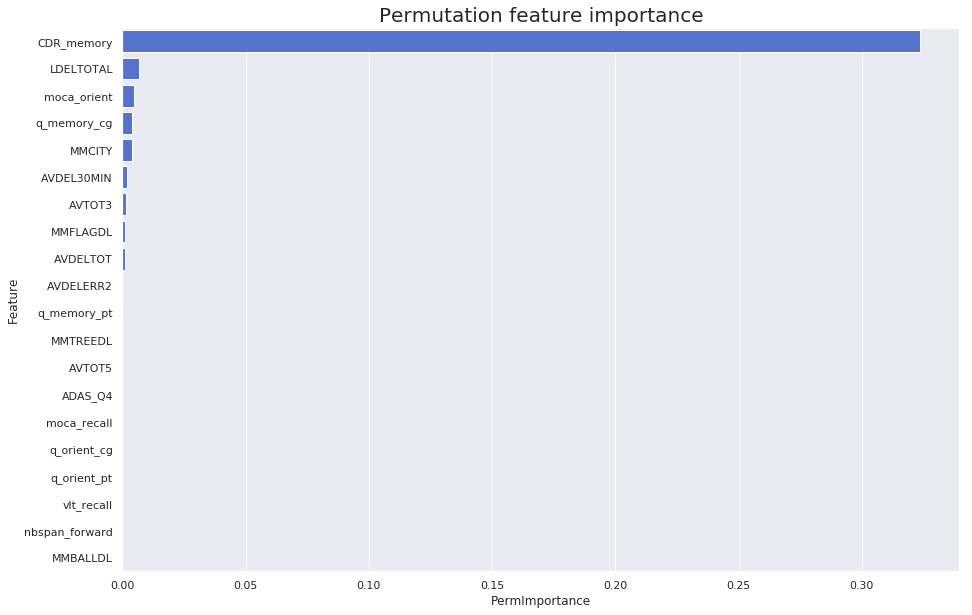

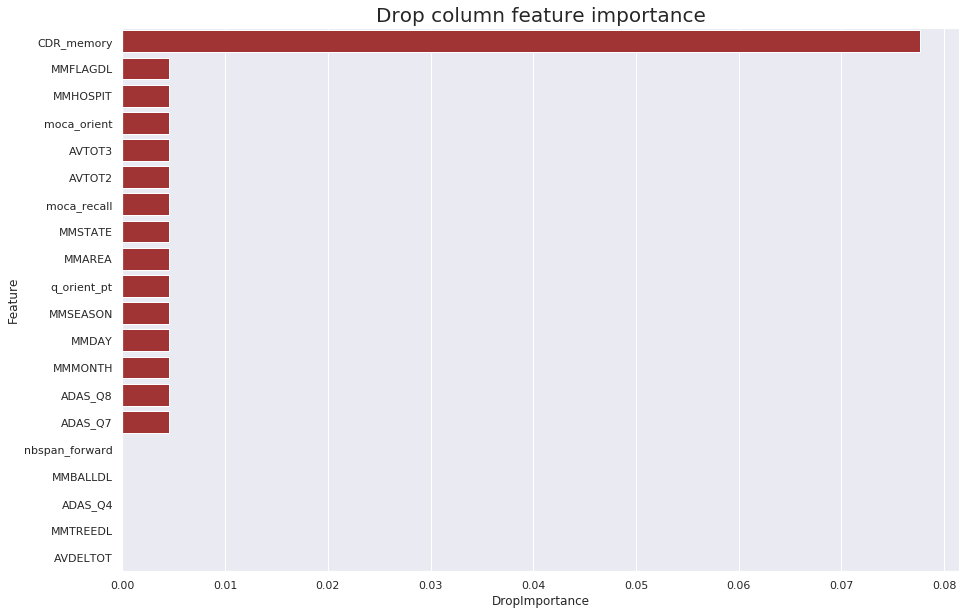


~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~

~~Random Forest~~
[[373  11   0]
 [ 28 424  68]
 [  2  36 150]]
Accuracy: 	 0.8672161172161172
Kappa: 		 0.7893877160125989


~~XGBoost~~
[[370  14   0]
 [ 32 435  53]
 [  2  38 148]]
Accuracy: 	 0.8727106227106227
Kappa: 		 0.7966126222698646


~~Logistic Regression~~
[[364  20   0]
 [ 25 464  31]
 [  2  57 129]]
Accuracy: 	 0.8763736263736264
Kappa: 		 0.7983089804629782


~~SVM~~
[[374  10   0]
 [ 27 457  36]
 [  2  49 137]]
Accuracy: 	 0.8864468864468864
Kappa: 		 0.8162384579056221


~~MLP~~
[[361  23   0]
 [ 25 462  33]
 [  0  45 143]]
Accuracy: 	 0.8846153846153846
Kappa: 		 0.8129404855129209



~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~



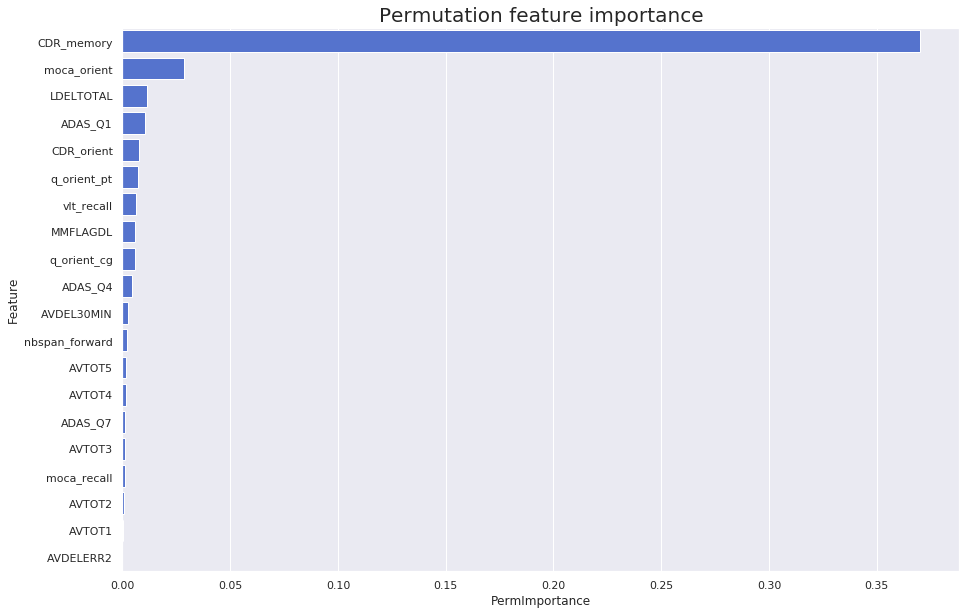

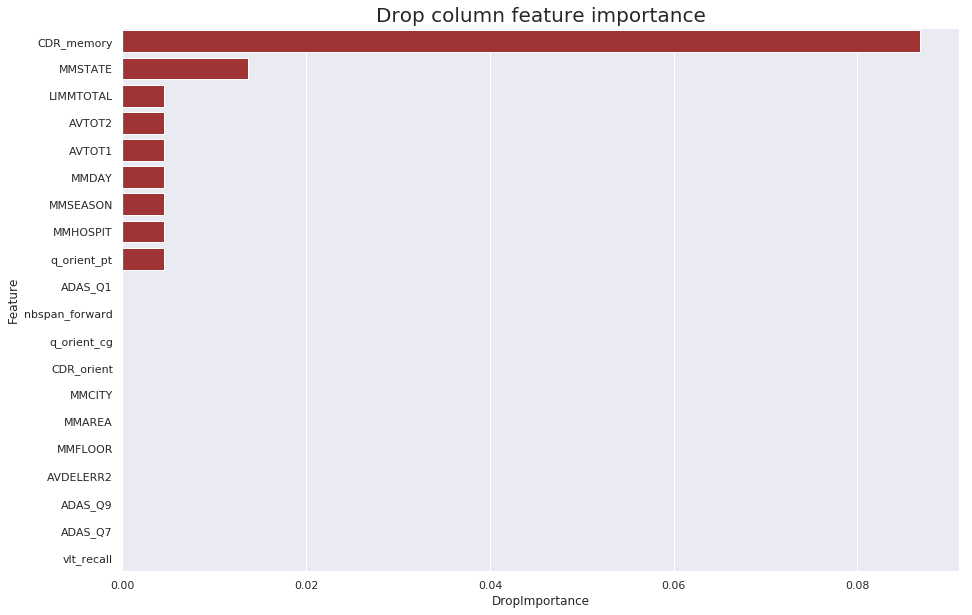

<Figure size 1080x720 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_mem_2 = ehr_analyses(adni_mem, adni_y2)
ehr_mem_2.to_csv(f'{dir}/Output/ehr_mem_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_mem_2 = ehr_feature(adni_mem, adni_y2)
features_mem_2.to_csv(f'{dir}/Output/features_mem_2.csv', index=False)
#### Predictive Analyses (3)
print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
ehr_mem_3 = ehr_analyses3(adni_mem, adni_y3)
ehr_mem_3.to_csv(f'{dir}/Output/ehr_mem_3.csv', index=False)
#### Feature Analyses (3)
print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
features_mem_3 = ehr_feature(adni_mem, adni_y3)
features_mem_3.to_csv(f'{dir}/Output/features_mem_3.csv', index=False)

### All executive funcitoning


In [0]:
exe = ['moca_digits','moca_letters','moca_serial7','MMD',
       'MML', 'MMR', 'MMO', 'MMW','q_attention_pt','q_attention_cg',
       'moca_visuo_exec','ADAS_Q3','ADAS_Q6','ADAS_Q13','MMHAND', 'MMFOLD',
       'MMONFLR','CDR_judge','CDR_home','nbspan_backward','q_judgmt_pt',
       'q_judgmt_cg','q_homeact_pt','q_homeact_cg',
       'moca_clock','MMDRAW','CLOCKCIRC', 'CLOCKSYM',
       'CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME', 'tma_time', 'tmb_time', 'TRAAERRCOM',
       'TRAAERROM', 'TRABERRCOM', 'TRABERROM']
adni_exe = adni_X.loc[:,exe]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[282 102]
 [121 587]]
Accuracy: 	 0.7957875457875457
AUC: 		 0.78173552259887
Kappa: 		 0.5571631205673759
F1 score: 	 0.840372226198998


~~XGBoost~~
[[306  78]
 [150 558]]
Accuracy: 	 0.7912087912087912
AUC: 		 0.7925052966101694
Kappa: 		 0.5609446419502285
F1 score: 	 0.8303571428571429


~~Logistic Regression~~
[[303  81]
 [127 581]]
Accuracy: 	 0.8095238095238095
AUC: 		 0.8048419844632768
Kappa: 		 0.5934183958413886
F1 score: 	 0.8481751824817517


~~SVM~~
[[327  57]
 [148 560]]
Accuracy: 	 0.8122710622710623
AUC: 		 0.8212614759887006
Kappa: 		 0.609474763968264
F1 score: 	 0.8452830188679246


~~MLP~~
[[300  84]
 [130 578]]
Accuracy: 	 0.8040293040293041
AUC: 		 0.7988170903954803
Kappa: 		 0.5816900803368132
F1 score: 	 0.8437956204379561



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



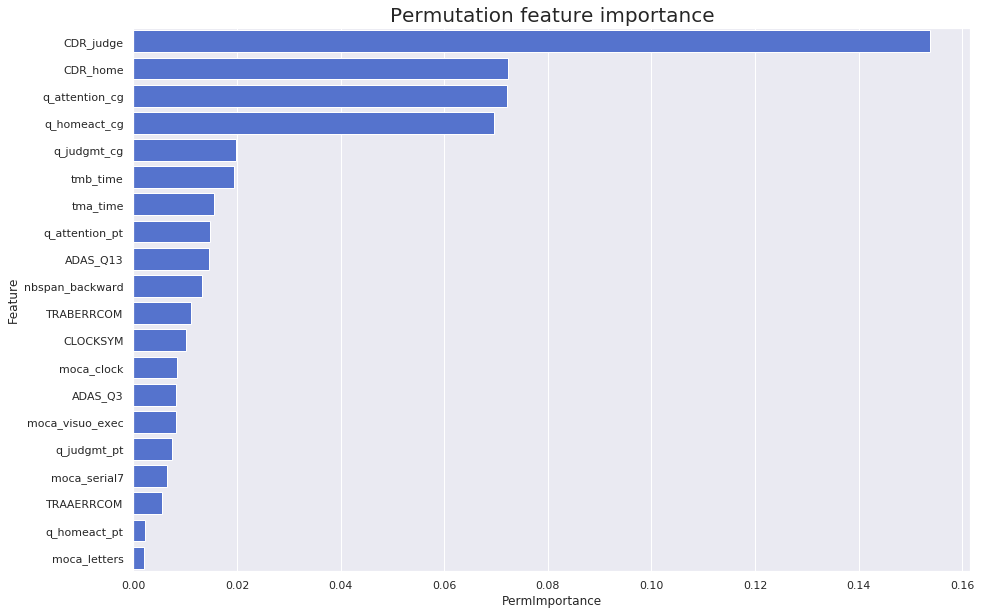

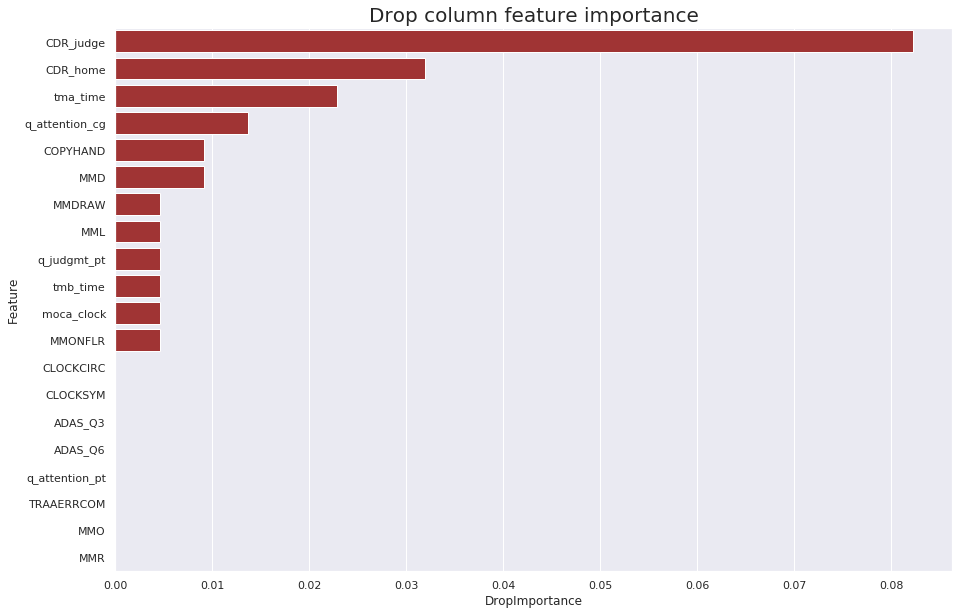


~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~

~~Random Forest~~
[[287  93   4]
 [119 346  55]
 [  9  63 116]]
Accuracy: 	 0.6858974358974359
Kappa: 		 0.49327077617416437


~~XGBoost~~
[[313  66   5]
 [147 319  54]
 [  6  61 121]]
Accuracy: 	 0.6895604395604396
Kappa: 		 0.5049374130737135


~~Logistic Regression~~
[[299  83   2]
 [137 342  41]
 [  5  68 115]]
Accuracy: 	 0.6923076923076923
Kappa: 		 0.5021925064038554


~~SVM~~
[[318  62   4]
 [143 331  46]
 [ 12  61 115]]
Accuracy: 	 0.6996336996336996
Kappa: 		 0.5184071681734819


~~MLP~~
[[302  80   2]
 [132 343  45]
 [  3  71 114]]
Accuracy: 	 0.695054945054945
Kappa: 		 0.5069395857400869



~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~



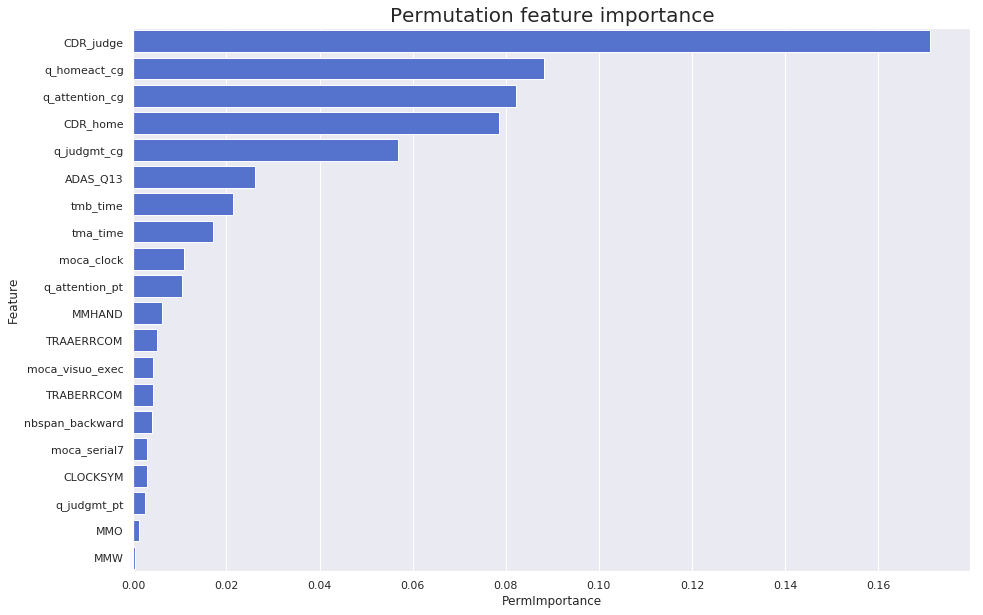

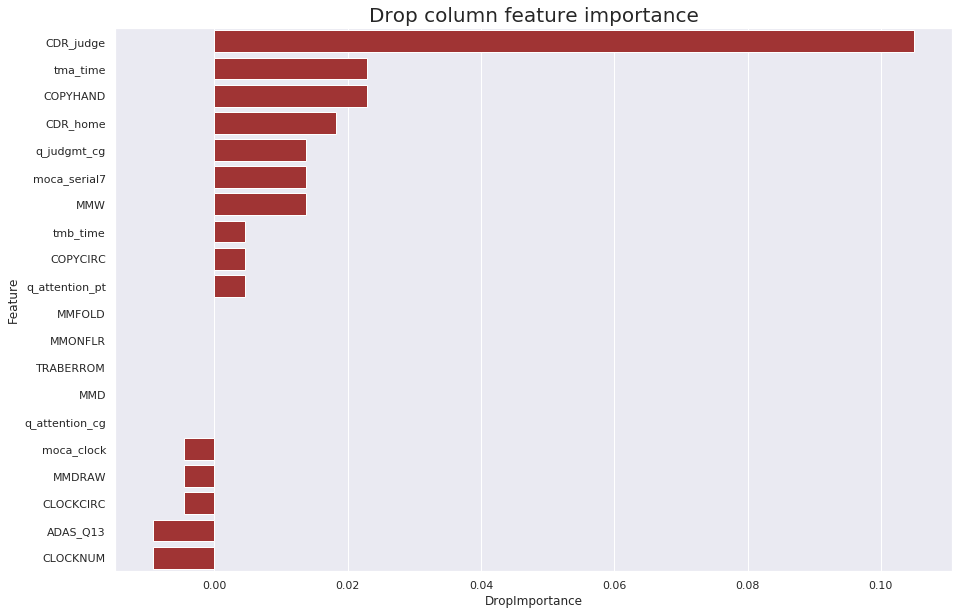

<Figure size 1080x720 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_exe_2 = ehr_analyses(adni_exe, adni_y2)
ehr_exe_2.to_csv(f'{dir}/Output/ehr_exe_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_exe_2 = ehr_feature(adni_exe, adni_y2)
features_exe_2.to_csv(f'{dir}/Output/features_exe_2.csv', index=False)
#### Predictive Analyses (3)
print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
ehr_exe_3 = ehr_analyses3(adni_exe, adni_y3)
ehr_exe_3.to_csv(f'{dir}/Output/ehr_exe_3.csv', index=False)
#### Feature Analyses (3)
print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
features_exe_3 = ehr_feature(adni_exe, adni_y3)
features_exe_3.to_csv(f'{dir}/Output/features_exe_3.csv', index=False)

### All above cognitive domain features

In [0]:
all = ['ADAS_Q1','moca_orient','ADAS_Q7','ADAS_Q8','ADAS_Q9','MMDATE',
       'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR',
       'MMCITY', 'MMAREA', 'MMSTATE','CDR_orient','AVTOT1', 'AVTOT2', 'AVTOT3',
       'AVTOT4', 'AVTOT5', 'AVTOT6','nbspan_forward','LIMMTOTAL','vlt_recall',
       'q_orient_pt','q_orient_cg','moca_recall','ADAS_Q4','MMBALLDL', 
       'MMFLAGDL', 'MMTREEDL','CDR_memory', 'LDELTOTAL', 'AVDEL30MIN', 
       'AVDELTOT', 'AVDELERR2','q_memory_pt','q_memory_cg',
       'moca_digits','moca_letters','moca_serial7','MMD',
       'MML', 'MMR', 'MMO', 'MMW','q_attention_pt','q_attention_cg',
       'moca_visuo_exec','ADAS_Q3','ADAS_Q6','ADAS_Q13','MMHAND', 'MMFOLD',
       'MMONFLR','CDR_judge','CDR_home','nbspan_backward','q_judgmt_pt',
       'q_judgmt_cg','q_homeact_pt','q_homeact_cg',
       'moca_clock','MMDRAW','CLOCKCIRC', 'CLOCKSYM',
       'CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME', 'tma_time', 'tmb_time', 'TRAAERRCOM',
       'TRAAERROM', 'TRABERRCOM', 'TRABERROM',
       'moca_naming','moca_repeat','moca_fluency','moca_similarities','ADAS_Q2',
       'ADAS_Q5','ADAS_Q10','ADAS_Q11','ADAS_Q12','MMBALL', 'MMFLAG', 'MMTREE',
       'MMWATCH', 'MMPENCIL','MMREPEAT','MMREAD', 'MMWRITE','CDR_comm',
       'CATANIMSC', 'CATVEGESC', 'q_language_pt','q_language_cg']
adni_all = adni_X.loc[:,all]


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[369  15]
 [ 29 679]]
Accuracy: 	 0.9597069597069597
AUC: 		 0.9599885240112994
Kappa: 		 0.9123659444079667
F1 score: 	 0.9686162624821683


~~XGBoost~~
[[368  16]
 [ 29 679]]
Accuracy: 	 0.9587912087912088
AUC: 		 0.9586864406779662
Kappa: 		 0.9103212666710465
F1 score: 	 0.9679258731290092


~~Logistic Regression~~
[[355  29]
 [ 36 672]]
Accuracy: 	 0.9404761904761905
AUC: 		 0.936815854519774
Kappa: 		 0.8700028570800642
F1 score: 	 0.9538679914833216


~~SVM~~
[[368  16]
 [ 29 679]]
Accuracy: 	 0.9587912087912088
AUC: 		 0.9586864406779662
Kappa: 		 0.9103212666710465
F1 score: 	 0.9679258731290092


~~MLP~~
[[357  27]
 [ 32 676]]
Accuracy: 	 0.9459706959706959
AUC: 		 0.9422448799435028
Kappa: 		 0.8818623891566
F1 score: 	 0.958185683912119



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



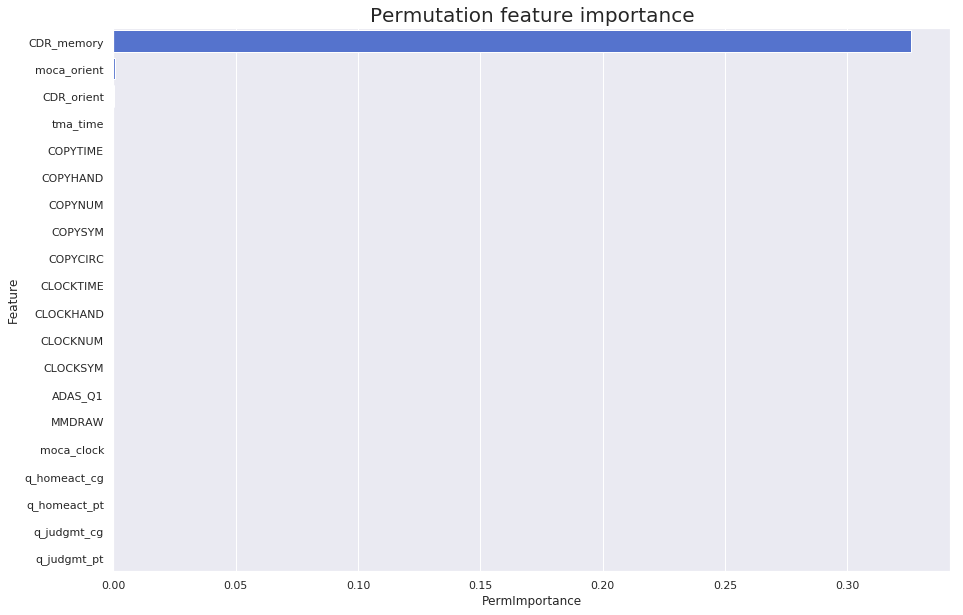

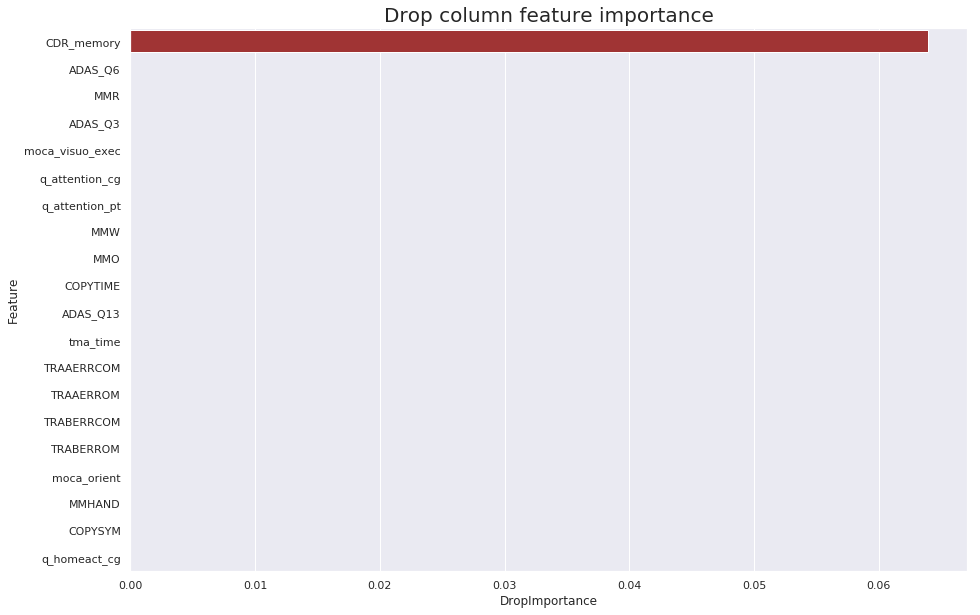


~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~

~~Random Forest~~
[[369  15   0]
 [ 29 426  65]
 [  2  31 155]]
Accuracy: 	 0.86996336996337
Kappa: 		 0.7938154199642584


~~XGBoost~~
[[369  15   0]
 [ 33 441  46]
 [  2  35 151]]
Accuracy: 	 0.88003663003663
Kappa: 		 0.8079766756334467


~~Logistic Regression~~
[[359  25   0]
 [ 35 453  32]
 [  2  51 135]]
Accuracy: 	 0.8672161172161172
Kappa: 		 0.7842555904971087


~~SVM~~
[[372  12   0]
 [ 29 453  38]
 [  2  48 138]]
Accuracy: 	 0.8818681318681318
Kappa: 		 0.8090867693775546


~~MLP~~
[[352  32   0]
 [ 35 453  32]
 [  1  46 141]]
Accuracy: 	 0.8663003663003663
Kappa: 		 0.7830349415101221



~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~



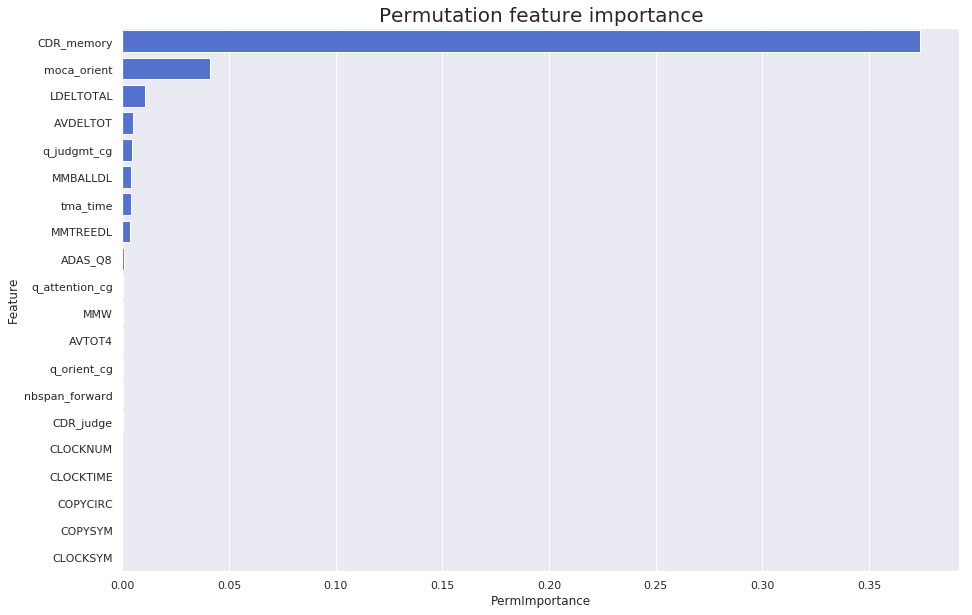

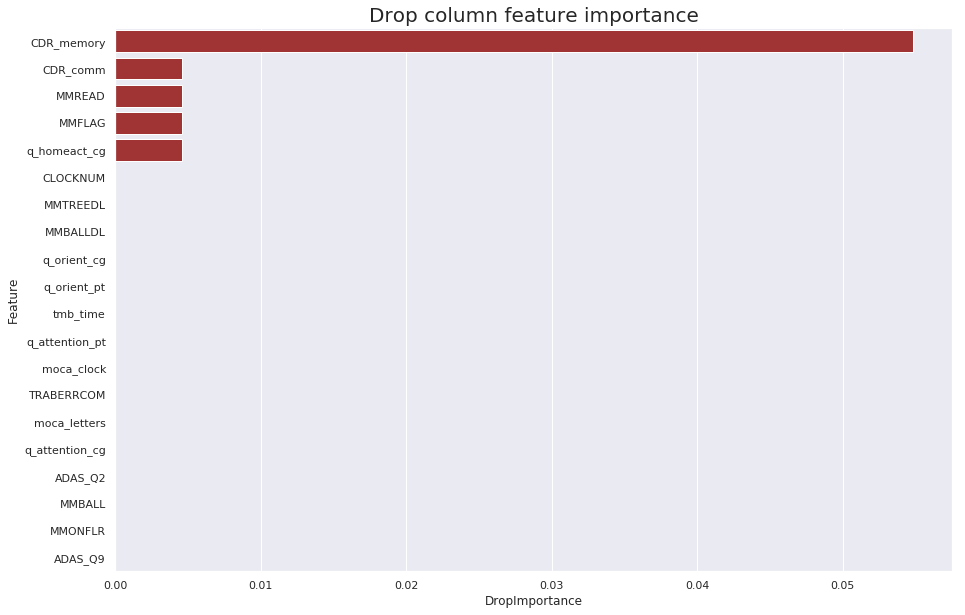

<Figure size 1080x720 with 0 Axes>

In [0]:
#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
ehr_all_2 = ehr_analyses(adni_all, adni_y2)
ehr_all_2.to_csv(f'{dir}/Output/ehr_allcog_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
features_all_2 = ehr_feature(adni_all, adni_y2)
features_all_2.to_csv(f'{dir}/Output/features_allcog_2.csv', index=False)
#### Predictive Analyses (3)
print('\n~~~~~~~~ Predictive Analyses, Ternary ~~~~~~~~\n')
ehr_all_3 = ehr_analyses3(adni_all, adni_y3)
ehr_all_3.to_csv(f'{dir}/Output/ehr_allcog_3.csv', index=False)
#### Feature Analyses (3)
print('\n~~~~~~~~ Feature Analyses, Ternary ~~~~~~~~\n')
features_all_3 = ehr_feature(adni_all, adni_y3)
features_all_3.to_csv(f'{dir}/Output/features_allcog_3.csv', index=False)

# Model comparison - ADNI

## Bimodal

In [0]:
from keras.layers import Input, Dense, Activation, Dropout, Flatten
from keras.layers.merge import concatenate
from keras.models import Model

from keras.utils import plot_model

Using TensorFlow backend.


In [0]:
from sklearn.model_selection import train_test_split as split

adni_X_train, adni_X_test, adni_y2_train, adni_y2_test = split(adni_X, adni_y2, test_size=0.33, random_state=0)
adni_X_train, adni_X_test, adni_y3_train, adni_y3_test = split(adni_X, adni_y3, test_size=0.33, random_state=0)

In [0]:
adni_mem_train = adni_X_train.loc[:,mem]
adni_stm_train = adni_X_train.loc[:,stm]
adni_ltm_train = adni_X_train.loc[:,ltm]

adni_exe_train = adni_X_train.loc[:,exe]
adni_att_train = adni_X_train.loc[:,att]
adni_exf_train = adni_X_train.loc[:,exf]
adni_vis_train = adni_X_train.loc[:,vis]

adni_lng_train = adni_X_train.loc[:,lng]

adni_mem_test = adni_X_test.loc[:,mem]
adni_stm_test = adni_X_test.loc[:,stm]
adni_ltm_test = adni_X_test.loc[:,ltm]

adni_exe_test = adni_X_test.loc[:,exe]
adni_att_test = adni_X_test.loc[:,att]
adni_exf_test = adni_X_test.loc[:,exf]
adni_vis_test = adni_X_test.loc[:,vis]

adni_lng_test = adni_X_test.loc[:,lng]

adni_all_train = adni_X_train.loc[:,all]
adni_all_test = adni_X_test.loc[:,all]

In [0]:
adni_all_train.shape[1]

103

### Three category model (Memory, EF, Language)

In [0]:
len_mem = adni_mem_train.shape[1]
len_exe = adni_exe_train.shape[1]
len_lng = adni_lng_train.shape[1]

In [0]:
inputs_mem = Input(shape=(len_mem,))
dense_mem = Dense(105, activation='relu')(inputs_mem)
dense_mem = Dropout(0.2)(dense_mem)
dense_mem = Dense(60, activation='relu')(dense_mem)
# dense_mem = Dense(10, activation='relu')(dense_mem)
out_mem = Dense(15, activation='relu')(dense_mem)

inputs_exe = Input(shape=(len_exe,))
dense_exe = Dense(105, activation='relu')(inputs_exe)
dense_exe = Dropout(0.2)(dense_exe)
dense_exe = Dense(60, activation='relu')(dense_exe)
# dense_exe = Dense(10, activation='relu')(dense_exe)
out_exe = Dense(15, activation='relu')(dense_exe)

inputs_lng = Input(shape=(len_lng,))
dense_lng = Dense(105, activation='relu')(inputs_lng)
dense_lng = Dropout(0.2)(dense_lng)
dense_lng = Dense(60, activation='relu')(dense_lng)
# dense_lng = Dense(10, activation='relu')(dense_lng)
out_lng = Dense(15, activation='relu')(dense_lng)

out_flat = concatenate([out_mem,out_exe,out_lng])

dense_all = Dense(105, activation='relu')(out_flat)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(75, activation='relu')(dense_all)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(60, activation='relu')(dense_all)
dense_all = Dense(15, activation='relu')(dense_all)
outputs = Dense(1, activation='sigmoid')(dense_all)
model = Model(inputs=[inputs_mem, inputs_exe, inputs_lng], outputs=outputs)

model.summary()

W0624 18:53:39.948744 140198864177024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 18:53:39.951443 140198864177024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 18:53:39.957221 140198864177024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 18:53:39.976486 140198864177024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0624 18:53:39.985841 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 42)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 105)          4200        input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [0]:
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit([adni_mem_train, adni_exe_train, adni_lng_train], adni_y2_train, batch_size=1000, epochs=2000, validation_split=0.2)

In [0]:
model.evaluate([adni_mem_test, adni_exe_test, adni_lng_test], adni_y2_test)

361/361 [==============================] - 0s 71us/step


[0.08760812465318187, 0.8808864265927978]

In [0]:
y_pred = model.predict([adni_mem_test, adni_exe_test, adni_lng_test])

print('Accuracy: \t', accuracy_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(adni_y2_test.to_numpy(), y_pred))
print('Kappa: \t\t', cohen_kappa_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('F1: \t\t', f1_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('\n')
print(confusion_matrix(adni_y2_test.to_numpy(), np.rint(y_pred)))

Accuracy: 	 0.8808864265927978
AUC: 		 0.9505096566523605
Kappa: 		 0.7464514969864267
F1: 		 0.9046563192904656


[[114  14]
 [ 29 204]]


## Unimodal

In [0]:
from keras.models import Sequential

model = Sequential()
model.add(Dense(105, activation='relu', input_dim=103))
model.add(Dropout(0.2))
model.add(Dense(75, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(60, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit(adni_all_train, adni_y2_train, batch_size=1000, epochs=2000, validation_split=0.2)

In [0]:
model.evaluate(adni_all_test, adni_y2_test)

361/361 [==============================] - 0s 54us/step


[0.09051830117226968, 0.8753462603878116]

In [0]:
y_pred = model.predict(adni_all_test)

print('Accuracy: \t', accuracy_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(adni_y2_test.to_numpy(), y_pred))
print('Kappa: \t\t', cohen_kappa_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('F1: \t\t', f1_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('\n')
print(confusion_matrix(adni_y2_test.to_numpy(), np.rint(y_pred)))

Accuracy: 	 0.8753462603878116
AUC: 		 0.9422947961373391
Kappa: 		 0.7309673252405479
F1: 		 0.9019607843137255


[[109  19]
 [ 26 207]]


## RF

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=0)
clf.fit(adni_all_train, adni_y2_train.values.ravel())

y2_pred = clf.predict(adni_all_test)

print('Accuracy: \t', accuracy_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(adni_y2_test.to_numpy(), y_pred))
print('Kappa: \t\t', cohen_kappa_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('F1: \t\t', f1_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('\n')
print(confusion_matrix(adni_y2_test.to_numpy(), np.rint(y_pred)))

Accuracy: 	 0.8753462603878116
AUC: 		 0.9422947961373391
Kappa: 		 0.7309673252405479
F1: 		 0.9019607843137255


[[109  19]
 [ 26 207]]


In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

cv=cv = StratifiedKFold(n_splits=5)

mlp = MLPClassifier(hidden_layer_sizes=(105,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=0)

y_pred = cross_val_predict(mlp, adni_all_test, adni_y2_test.values.ravel(), cv=cv)

print('Accuracy: \t', accuracy_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(adni_y2_test.to_numpy(), y_pred))
print('Kappa: \t\t', cohen_kappa_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('F1: \t\t', f1_score(adni_y2_test.to_numpy(), np.rint(y_pred)))
print('\n')
print(confusion_matrix(adni_y2_test.to_numpy(), np.rint(y_pred)))

Accuracy: 	 0.9279778393351801
AUC: 		 0.9248424087982833
Kappa: 		 0.8437437570753147
F1: 		 0.9437229437229437


[[117  11]
 [ 15 218]]


## Integrative Approaches

In [0]:
df_adni = pd.read_csv(f'{dir}/Data/imp_adni_all.csv')
df_adni = df_adni.loc[df_adni['VISCODE']==1]

In [0]:
df_adni['mmse_total'] = df_adni[['MMDATE',
       'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR',
       'MMCITY', 'MMAREA', 'MMSTATE', 'MMBALL', 'MMFLAG', 'MMTREE', 'MMD',
       'MML', 'MMR', 'MMO', 'MMW', 'MMBALLDL', 'MMFLAGDL', 'MMTREEDL',
       'MMWATCH', 'MMPENCIL', 'MMREPEAT', 'MMHAND', 'MMFOLD', 'MMONFLR',
       'MMREAD', 'MMWRITE', 'MMDRAW']].sum(axis=1)
df_adni['ECOG_pt'] = df_adni[['MEM1_pt', 'MEM2_pt', 'MEM3_pt', 'MEM4_pt',
       'MEM5_pt', 'MEM6_pt', 'MEM7_pt', 'MEM8_pt', 'LANG1_pt', 'LANG2_pt',
       'LANG3_pt', 'LANG4_pt', 'LANG5_pt', 'LANG6_pt', 'LANG7_pt',
       'LANG8_pt', 'LANG9_pt', 'VISSPAT1_pt', 'VISSPAT2_pt',
       'VISSPAT3_pt', 'VISSPAT4_pt', 'VISSPAT5_pt', 'VISSPAT6_pt',
       'VISSPAT7_pt', 'VISSPAT8_pt', 'PLAN1_pt', 'PLAN2_pt', 'PLAN3_pt',
       'PLAN4_pt', 'PLAN5_pt', 'ORGAN1_pt', 'ORGAN2_pt', 'ORGAN3_pt',
       'ORGAN4_pt', 'ORGAN5_pt', 'ORGAN6_pt', 'DIVATT1_pt', 'DIVATT2_pt',
       'DIVATT3_pt', 'DIVATT4_pt']].sum(axis=1)
df_adni['ECOG_cg'] = df_adni[['MEM1_cg', 'MEM2_cg', 'MEM3_cg', 'MEM4_cg',
       'MEM5_cg', 'MEM6_cg', 'MEM7_cg', 'MEM8_cg', 'LANG1_cg', 'LANG2_cg',
       'LANG3_cg', 'LANG4_cg', 'LANG5_cg', 'LANG6_cg', 'LANG7_cg',
       'LANG8_cg', 'LANG9_cg', 'VISSPAT1_cg', 'VISSPAT2_cg',
       'VISSPAT3_cg', 'VISSPAT4_cg', 'VISSPAT5_cg', 'VISSPAT6_cg',
       'VISSPAT7_cg', 'VISSPAT8_cg', 'PLAN1_cg', 'PLAN2_cg', 'PLAN3_cg',
       'PLAN4_cg', 'PLAN5_cg', 'ORGAN1_cg', 'ORGAN2_cg', 'ORGAN3_cg',
       'ORGAN4_cg', 'ORGAN5_cg', 'ORGAN6_cg', 'DIVATT1_cg', 'DIVATT2_cg',
       'DIVATT3_cg', 'DIVATT4_cg']].sum(axis=1)
df_adni['faq_total'] = df_adni[['faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10']].sum(axis=1)
df_adni['clock_total'] = df_adni[['CLOCKCIRC', 'CLOCKSYM',
       'CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME']].sum(axis=1)

In [0]:
int_cols = ['moca_total','ADAS_TOTAL13','CDR_global','mmse_total','ECOG_pt',
           'ECOG_cg','faq_total','clock_total']
syn_cols = ['moca_visuo_exec', 'moca_clock',
       'moca_naming', 'moca_digits', 'moca_letters', 'moca_serial7',
       'moca_repeat', 'moca_fluency', 'moca_similarities', 'moca_recall',
       'moca_orient','ADAS_Q1', 'ADAS_Q2',
       'ADAS_Q3', 'ADAS_Q4', 'ADAS_Q5', 'ADAS_Q6', 'ADAS_Q7', 'ADAS_Q8',
       'ADAS_Q9', 'ADAS_Q10', 'ADAS_Q11', 'ADAS_Q12', 'ADAS_Q13',
       'faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10', 'MMDATE',
       'MMYEAR', 'MMMONTH', 'MMDAY', 'MMSEASON', 'MMHOSPIT', 'MMFLOOR',
       'MMCITY', 'MMAREA', 'MMSTATE', 'MMBALL', 'MMFLAG', 'MMTREE', 'MMD',
       'MML', 'MMR', 'MMO', 'MMW', 'MMBALLDL', 'MMFLAGDL', 'MMTREEDL',
       'MMWATCH', 'MMPENCIL', 'MMREPEAT', 'MMHAND', 'MMFOLD', 'MMONFLR',
       'MMREAD', 'MMWRITE', 'MMDRAW','CDR_memory', 'CDR_orient', 'CDR_judge', 'CDR_comm',
       'CDR_home', 'CDR_care','CLOCKCIRC', 'CLOCKSYM',
       'CLOCKNUM', 'CLOCKHAND', 'CLOCKTIME', 'COPYCIRC', 'COPYSYM',
       'COPYNUM', 'COPYHAND', 'COPYTIME','MEM1_pt', 'MEM2_pt', 'MEM3_pt', 'MEM4_pt',
       'MEM5_pt', 'MEM6_pt', 'MEM7_pt', 'MEM8_pt', 'LANG1_pt', 'LANG2_pt',
       'LANG3_pt', 'LANG4_pt', 'LANG5_pt', 'LANG6_pt', 'LANG7_pt',
       'LANG8_pt', 'LANG9_pt', 'VISSPAT1_pt', 'VISSPAT2_pt',
       'VISSPAT3_pt', 'VISSPAT4_pt', 'VISSPAT5_pt', 'VISSPAT6_pt',
       'VISSPAT7_pt', 'VISSPAT8_pt', 'PLAN1_pt', 'PLAN2_pt', 'PLAN3_pt',
       'PLAN4_pt', 'PLAN5_pt', 'ORGAN1_pt', 'ORGAN2_pt', 'ORGAN3_pt',
       'ORGAN4_pt', 'ORGAN5_pt', 'ORGAN6_pt', 'DIVATT1_pt', 'DIVATT2_pt',
       'DIVATT3_pt', 'DIVATT4_pt','MEM1_cg', 'MEM2_cg', 'MEM3_cg', 'MEM4_cg',
       'MEM5_cg', 'MEM6_cg', 'MEM7_cg', 'MEM8_cg', 'LANG1_cg', 'LANG2_cg',
       'LANG3_cg', 'LANG4_cg', 'LANG5_cg', 'LANG6_cg', 'LANG7_cg',
       'LANG8_cg', 'LANG9_cg', 'VISSPAT1_cg', 'VISSPAT2_cg',
       'VISSPAT3_cg', 'VISSPAT4_cg', 'VISSPAT5_cg', 'VISSPAT6_cg',
       'VISSPAT7_cg', 'VISSPAT8_cg', 'PLAN1_cg', 'PLAN2_cg', 'PLAN3_cg',
       'PLAN4_cg', 'PLAN5_cg', 'ORGAN1_cg', 'ORGAN2_cg', 'ORGAN3_cg',
       'ORGAN4_cg', 'ORGAN5_cg', 'ORGAN6_cg', 'DIVATT1_cg', 'DIVATT2_cg',
       'DIVATT3_cg', 'DIVATT4_cg']
adni_int = df_adni.loc[:,int_cols]
adni_syn = df_adni.loc[:,syn_cols]
adni_y2 = pd.read_csv(f'{dir}/Data/adni_y2.csv')
adni_y3 = pd.read_csv(f'{dir}/Data/adni_y3.csv')

### Random Forest comparison

In [0]:
ehr_analyses(adni_int, adni_y2)

~~Random Forest~~
[[363  21]
 [ 30 678]]
Accuracy: 	 0.9532967032967034
AUC: 		 0.951469809322034
Kappa: 		 0.8981231478432664
F1 score: 	 0.9637526652452025


~~XGBoost~~
[[365  19]
 [ 30 678]]
Accuracy: 	 0.9551282051282052
AUC: 		 0.9540739759887007
Kappa: 		 0.90223420816067
F1 score: 	 0.9651245551601424


~~Logistic Regression~~
[[345  39]
 [ 40 668]]
Accuracy: 	 0.9276556776556777
AUC: 		 0.9209701624293785
Kappa: 		 0.8414389377798364
F1 score: 	 0.9441696113074204


~~SVM~~
[[370  14]
 [ 29 679]]
Accuracy: 	 0.9606227106227107
AUC: 		 0.9612906073446327
Kappa: 		 0.9144082070127086
F1 score: 	 0.9693076374018557


~~MLP~~
[[295  89]
 [ 95 613]]
Accuracy: 	 0.8315018315018315
AUC: 		 0.8170241878531073
Kappa: 		 0.631789594053745
F1 score: 	 0.8695035460992907




,analysis,mean accuracy,AUC
0,Random Forest,0.953297,0.951470
1,XGBoost,0.955128,0.954074
2,LogRegression,0.927656,0.920970
3,SVM,0.960623,0.961291
4,MLP,0.831502,0.817024


In [0]:
ehr_analyses(adni_syn, adni_y2)

~~Random Forest~~
[[365  19]
 [ 29 679]]
Accuracy: 	 0.9560439560439561
AUC: 		 0.9547801906779662
Kappa: 		 0.9041726997499013
F1 score: 	 0.9658605974395449


~~XGBoost~~
[[368  16]
 [ 29 679]]
Accuracy: 	 0.9587912087912088
AUC: 		 0.9586864406779662
Kappa: 		 0.9103212666710465
F1 score: 	 0.9679258731290092


~~Logistic Regression~~
[[326  58]
 [ 75 633]]
Accuracy: 	 0.8782051282051282
AUC: 		 0.8715130649717515
Kappa: 		 0.7355749273557493
F1 score: 	 0.9049320943531093


~~SVM~~
[[354  30]
 [ 38 670]]
Accuracy: 	 0.9377289377289377
AUC: 		 0.9341013418079096
Kappa: 		 0.8640836408364083
F1 score: 	 0.9517045454545454


~~MLP~~
[[304  80]
 [ 86 622]]
Accuracy: 	 0.847985347985348
AUC: 		 0.8350988700564971
Kappa: 		 0.6678101772441395
F1 score: 	 0.8822695035460992




,analysis,mean accuracy,AUC
0,Random Forest,0.956044,0.954780
1,XGBoost,0.958791,0.958686
2,LogRegression,0.878205,0.871513
3,SVM,0.937729,0.934101
4,MLP,0.847985,0.835099


In [0]:
ehr_analyses3(adni_int, adni_y3)

~~Random Forest~~
[[364  20   0]
 [ 28 464  28]
 [  2  49 137]]
Accuracy: 	 0.8836996336996337
Kappa: 		 0.8107963568298526


~~XGBoost~~
[[366  17   1]
 [ 28 468  24]
 [  2  44 142]]
Accuracy: 	 0.8937728937728938
Kappa: 		 0.827404472397687


~~Logistic Regression~~
[[352  29   3]
 [ 27 453  40]
 [  1  52 135]]
Accuracy: 	 0.8608058608058609
Kappa: 		 0.7742942616263258


~~SVM~~
[[375   9   0]
 [ 27 454  39]
 [  2  46 140]]
Accuracy: 	 0.8873626373626373
Kappa: 		 0.8182452949677671


~~MLP~~
[[295  88   1]
 [ 95 390  35]
 [  0  61 127]]
Accuracy: 	 0.7435897435897436
Kappa: 		 0.5821695044958868




,analysis,mean accuracy
0,Random Forest,0.883700
1,Random Forest,0.893773
2,Random Forest,0.860806
3,Random Forest,0.887363
4,Random Forest,0.743590


In [0]:
ehr_analyses3(adni_syn, adni_y3)

~~Random Forest~~
[[365  19   0]
 [ 27 471  22]
 [  2  46 140]]
Accuracy: 	 0.8937728937728938
Kappa: 		 0.8269489284035891


~~XGBoost~~
[[364  20   0]
 [ 27 472  21]
 [  2  45 141]]
Accuracy: 	 0.8946886446886447
Kappa: 		 0.828408867318161


~~Logistic Regression~~
[[333  50   1]
 [ 66 419  35]
 [  2  47 139]]
Accuracy: 	 0.8159340659340659
Kappa: 		 0.7022868458888316


~~SVM~~
[[356  27   1]
 [ 34 441  45]
 [  3  42 143]]
Accuracy: 	 0.8608058608058609
Kappa: 		 0.7759455738236009


~~MLP~~
[[301  82   1]
 [ 89 389  42]
 [  2  48 138]]
Accuracy: 	 0.7582417582417582
Kappa: 		 0.6093806739039711




,analysis,mean accuracy
0,Random Forest,0.893773
1,Random Forest,0.894689
2,Random Forest,0.815934
3,Random Forest,0.860806
4,Random Forest,0.758242


## Physician cutoff ranges procedure

Will only use paired features due to increased complexity of manually assigning splits. See below

# Domains - Paired

In [0]:
adni_pair_X = pd.read_csv(f'{dir}/Data/adni_pair_X.csv')
clinic_pair_X = pd.read_csv(f'{dir}/Data/sm_clinic_pair_X.csv')

adni_pair_y2 = pd.read_csv(f'{dir}/Data/adni_pair_y2.csv')
adni_pair_y3 = pd.read_csv(f'{dir}/Data/adni_pair_y3.csv')

clinic_pair_y2 = pd.read_csv(f'{dir}/Data/sm_clinic_pair_y2.csv', header=None)
clinic_pair_y3 = pd.read_csv(f'{dir}/Data/sm_clinic_pair_y3.csv', header=None)

## Domains 

### Short Term Memory


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[ 81  44]
 [ 27 151]]
Accuracy: 	 0.7656765676567657
AUC: 		 0.7481573033707865
Kappa: 		 0.5065712516342118
F1 score: 	 0.8096514745308311


~~XGBoost~~
[[ 82  43]
 [ 36 142]]
Accuracy: 	 0.7392739273927392
AUC: 		 0.7268764044943821
Kappa: 		 0.4575675859412177
F1 score: 	 0.7823691460055096


~~MLP~~
[[ 84  41]
 [  5 173]]
Accuracy: 	 0.8481848184818482
AUC: 		 0.8219550561797753
Kappa: 		 0.6727554470323065
F1 score: 	 0.8826530612244898



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



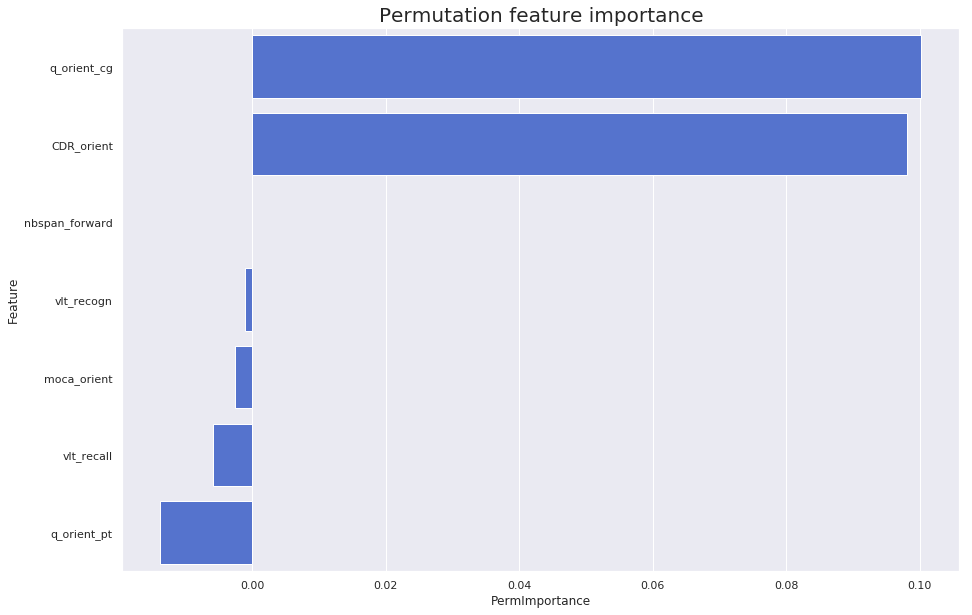

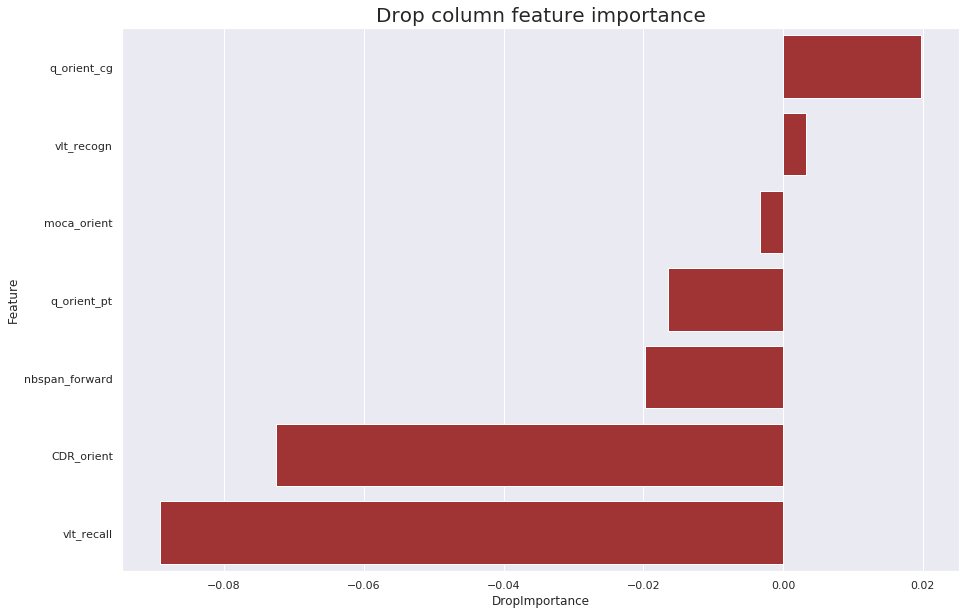

<Figure size 1080x720 with 0 Axes>

In [0]:
stm = ['moca_orient','CDR_orient','vlt_recogn','nbspan_forward','vlt_recall',
       'q_orient_pt','q_orient_cg']

adni_stm = adni_pair_X.loc[:,stm]
clinic_stm = clinic_pair_X.loc[:,stm]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_stm_2 = paired_analyses(adni_stm, adni_pair_y2, clinic_stm, clinic_pair_y2)
pair_ehr_stm_2.to_csv(f'{dir}/Output/pair_ehr_stm_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_stm_2 = paired_feature(adni_stm, adni_pair_y2, clinic_stm, clinic_pair_y2)
pair_features_stm_2.to_csv(f'{dir}/Output/pair_features_stm_2.csv', index=False)


### Long Term (delay) Memory


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[ 81  44]
 [ 49 129]]
Accuracy: 	 0.693069306930693
AUC: 		 0.6863595505617978
Kappa: 		 0.3705126773148665
F1 score: 	 0.7350427350427351


~~XGBoost~~
[[116   9]
 [ 43 135]]
Accuracy: 	 0.8283828382838284
AUC: 		 0.8432134831460675
Kappa: 		 0.6597123234417519
F1 score: 	 0.8385093167701864


~~MLP~~
[[117   8]
 [ 66 112]]
Accuracy: 	 0.7557755775577558
AUC: 		 0.7826067415730337
Kappa: 		 0.5286921427670577
F1 score: 	 0.7516778523489933



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



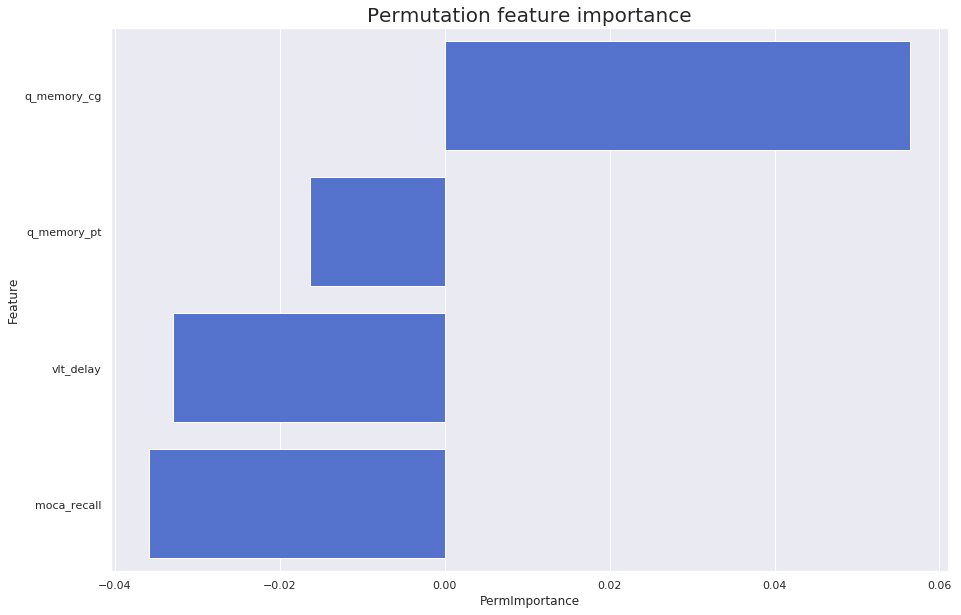

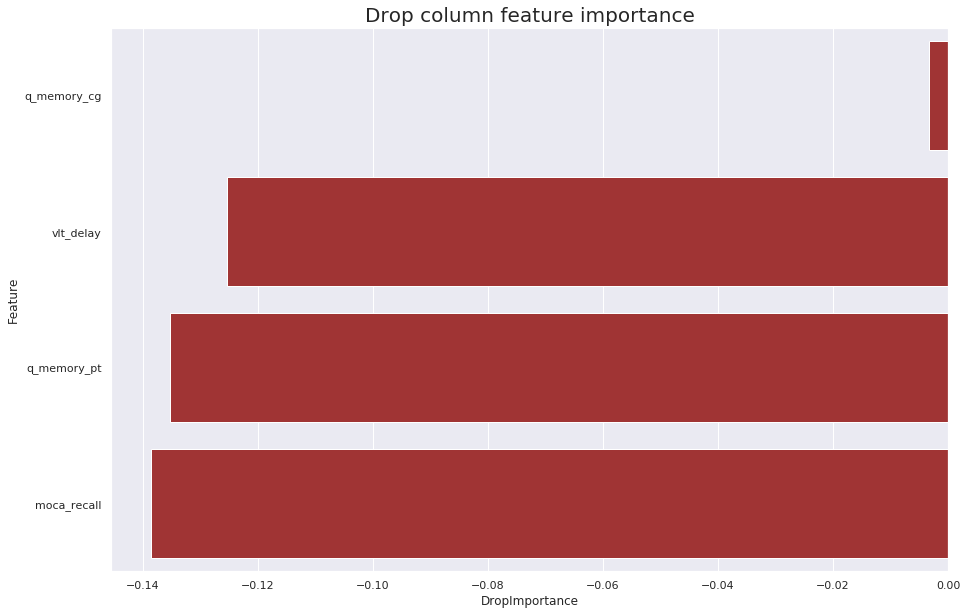

<Figure size 1080x720 with 0 Axes>

In [0]:

ltm = ['moca_recall', 'vlt_delay', 'q_memory_pt','q_memory_cg']
adni_ltm = adni_pair_X.loc[:,ltm]
clinic_ltm = clinic_pair_X.loc[:,ltm]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_ltm_2 = paired_analyses(adni_ltm, adni_pair_y2, clinic_ltm, clinic_pair_y2)
pair_ehr_ltm_2.to_csv(f'{dir}/Output/pair_ehr_ltm_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_ltm_2 = paired_feature(adni_ltm, adni_pair_y2, clinic_ltm, clinic_pair_y2)
pair_features_ltm_2.to_csv(f'{dir}/Output/pair_features_ltm_2.csv', index=False)


### Attention


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[119   6]
 [ 38 140]]
Accuracy: 	 0.8547854785478548
AUC: 		 0.8692584269662922
Kappa: 		 0.7114035847259503
F1 score: 	 0.8641975308641975


~~XGBoost~~
[[119   6]
 [ 38 140]]
Accuracy: 	 0.8547854785478548
AUC: 		 0.8692584269662922
Kappa: 		 0.7114035847259503
F1 score: 	 0.8641975308641975


~~MLP~~
[[ 80  45]
 [ 42 136]]
Accuracy: 	 0.7128712871287128
AUC: 		 0.7020224719101124
Kappa: 		 0.4054937867887508
F1 score: 	 0.7576601671309192



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



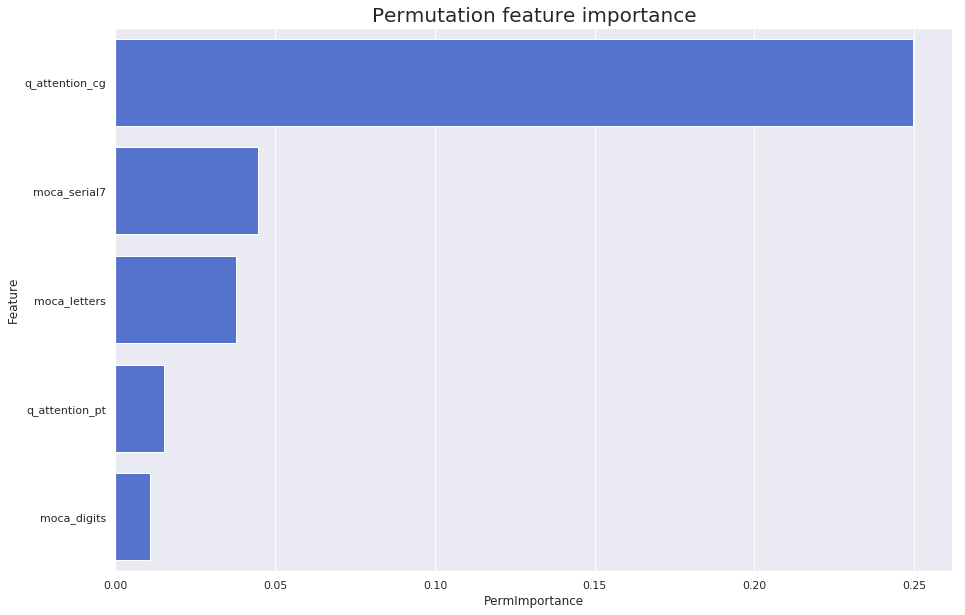

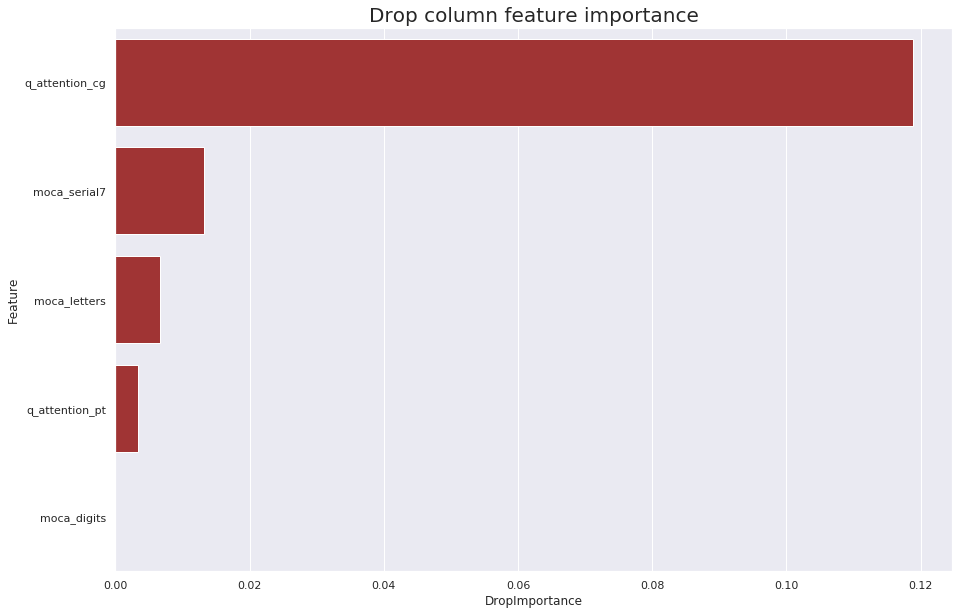

<Figure size 1080x720 with 0 Axes>

In [0]:
att = ['moca_digits','moca_letters','moca_serial7',
       'q_attention_pt','q_attention_cg']
adni_att = adni_pair_X.loc[:,att]
clinic_att = clinic_pair_X.loc[:,att]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_att_2 = paired_analyses(adni_att, adni_pair_y2, clinic_att, clinic_pair_y2)
pair_ehr_att_2.to_csv(f'{dir}/Output/pair_ehr_att_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_att_2 = paired_feature(adni_att, adni_pair_y2, clinic_att, clinic_pair_y2)
pair_features_att_2.to_csv(f'{dir}/Output/pair_features_att_2.csv', index=False)


### Executive Functioning


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[ 67  58]
 [ 22 156]]
Accuracy: 	 0.735973597359736
AUC: 		 0.7062022471910112
Kappa: 		 0.43087903831705476
F1 score: 	 0.7959183673469389


~~XGBoost~~
[[ 73  52]
 [ 26 152]]
Accuracy: 	 0.7425742574257426
AUC: 		 0.7189662921348314
Kappa: 		 0.4519270905802143
F1 score: 	 0.7958115183246073


~~MLP~~
[[ 44  81]
 [  8 170]]
Accuracy: 	 0.7062706270627063
AUC: 		 0.6535280898876404
Kappa: 		 0.33629494720779707
F1 score: 	 0.7925407925407925



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



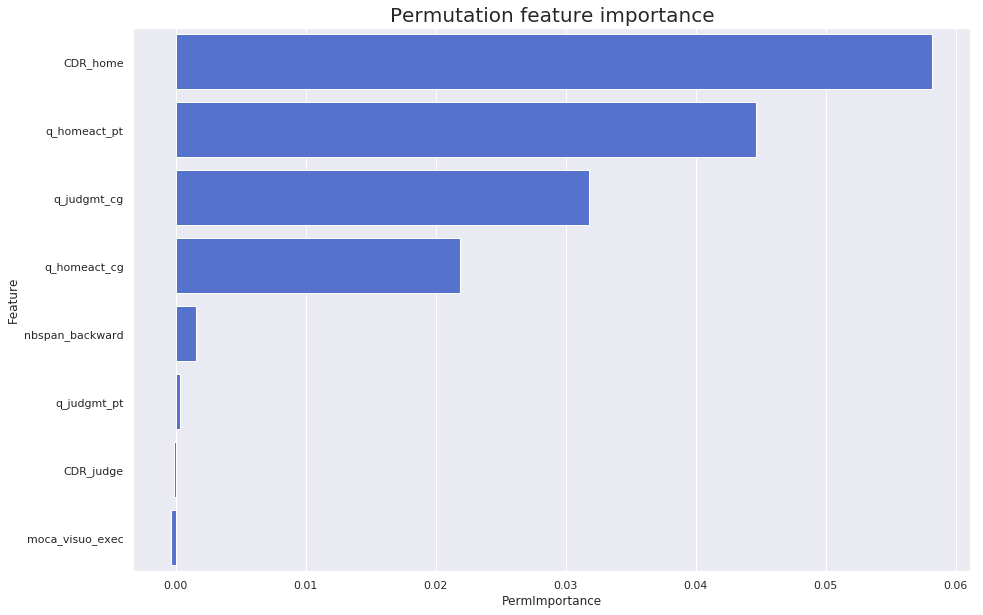

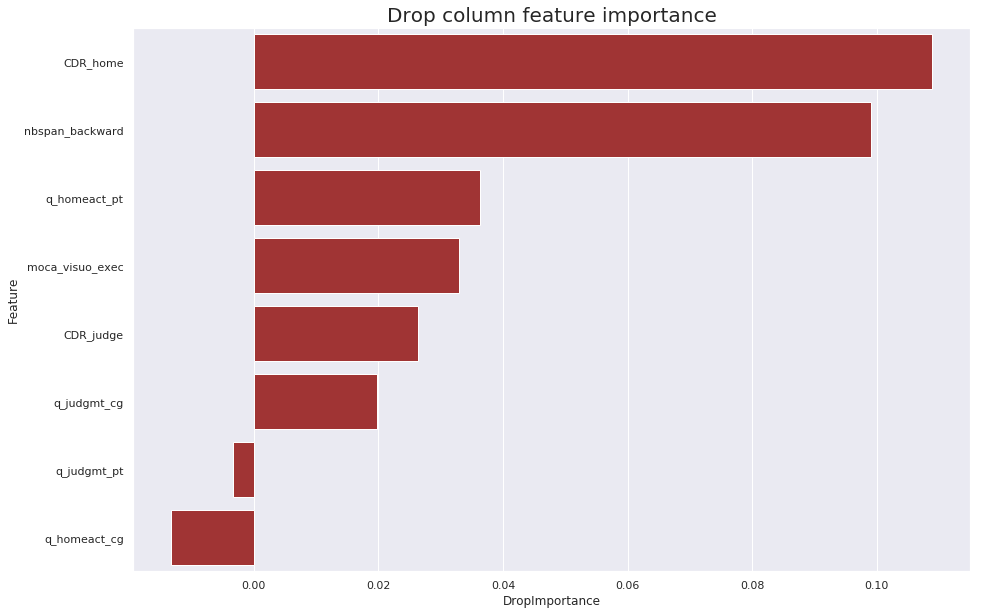

<Figure size 1080x720 with 0 Axes>

In [0]:
exf = ['moca_visuo_exec','CDR_judge','CDR_home','nbspan_backward','q_judgmt_pt',
       'q_judgmt_cg','q_homeact_pt','q_homeact_cg']
adni_exf = adni_pair_X.loc[:,exf]
clinic_exf = clinic_pair_X.loc[:,exf]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_exf_2 = paired_analyses(adni_exf, adni_pair_y2, clinic_exf, clinic_pair_y2)
pair_ehr_exf_2.to_csv(f'{dir}/Output/pair_ehr_exf_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_exf_2 = paired_feature(adni_exf, adni_pair_y2, clinic_exf, clinic_pair_y2)
pair_features_exf_2.to_csv(f'{dir}/Output/pair_features_exf_2.csv', index=False)


### Visuospatial


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[  8 117]
 [  4 174]]
Accuracy: 	 0.6006600660066007
AUC: 		 0.5207640449438202
Kappa: 		 0.04798628963153384
F1 score: 	 0.742004264392324


~~XGBoost~~
[[  0 125]
 [  0 178]]
Accuracy: 	 0.5874587458745875
AUC: 		 0.5
Kappa: 		 0.0
F1 score: 	 0.7401247401247402


~~MLP~~
[[  0 125]
 [  0 178]]
Accuracy: 	 0.5874587458745875
AUC: 		 0.5
Kappa: 		 0.0
F1 score: 	 0.7401247401247402



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



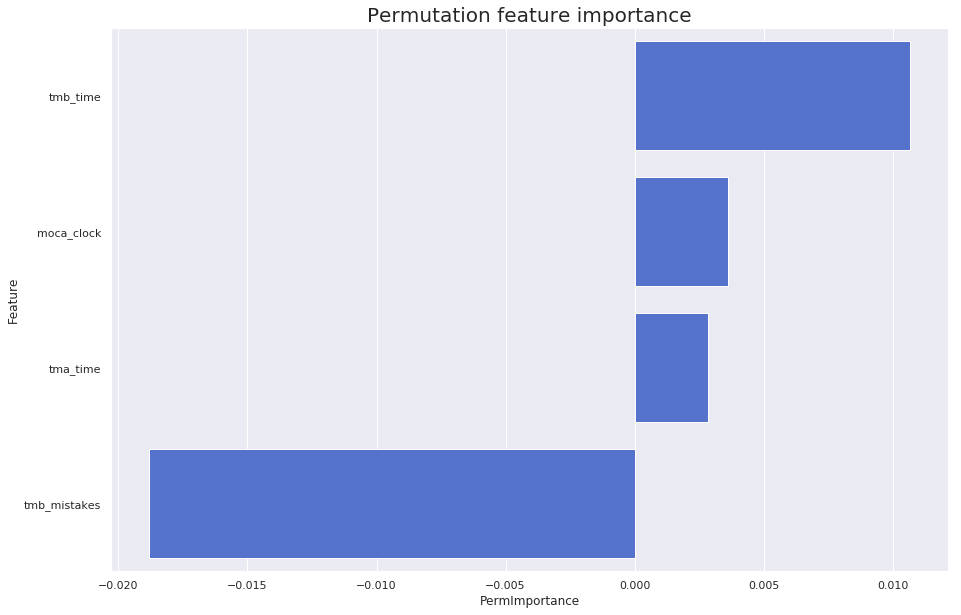

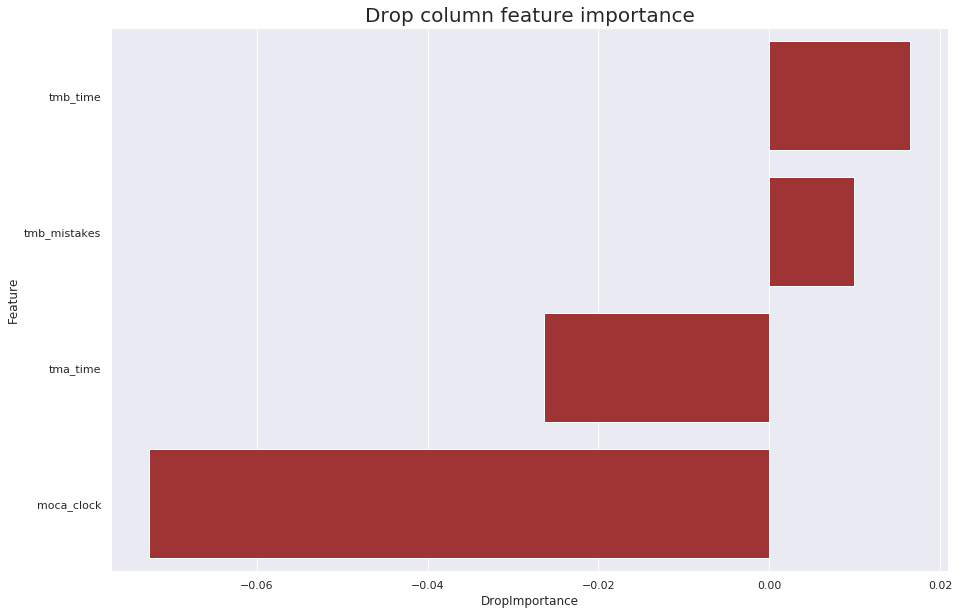

<Figure size 1080x720 with 0 Axes>

In [0]:
vis = ['moca_clock', 'tma_time', 'tmb_time', 'tmb_mistakes']
adni_vis = adni_pair_X.loc[:,vis]
clinic_vis = clinic_pair_X.loc[:,vis]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_vis_2 = paired_analyses(adni_vis, adni_pair_y2, clinic_vis, clinic_pair_y2)
pair_ehr_vis_2.to_csv(f'{dir}/Output/pair_ehr_vis_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_vis_2 = paired_feature(adni_vis, adni_pair_y2, clinic_vis, clinic_pair_y2)
pair_features_vis_2.to_csv(f'{dir}/Output/pair_features_vis_2.csv', index=False)


### Language


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[ 63  62]
 [ 18 160]]
Accuracy: 	 0.735973597359736
AUC: 		 0.701438202247191
Kappa: 		 0.4251565167899829
F1 score: 	 0.7999999999999999


~~XGBoost~~
[[ 79  46]
 [ 16 162]]
Accuracy: 	 0.7953795379537953
AUC: 		 0.771056179775281
Kappa: 		 0.562199953390818
F1 score: 	 0.8393782383419689


~~MLP~~
[[125   0]
 [ 60 118]]
Accuracy: 	 0.801980198019802
AUC: 		 0.8314606741573034
Kappa: 		 0.6187080536912752
F1 score: 	 0.7972972972972973



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



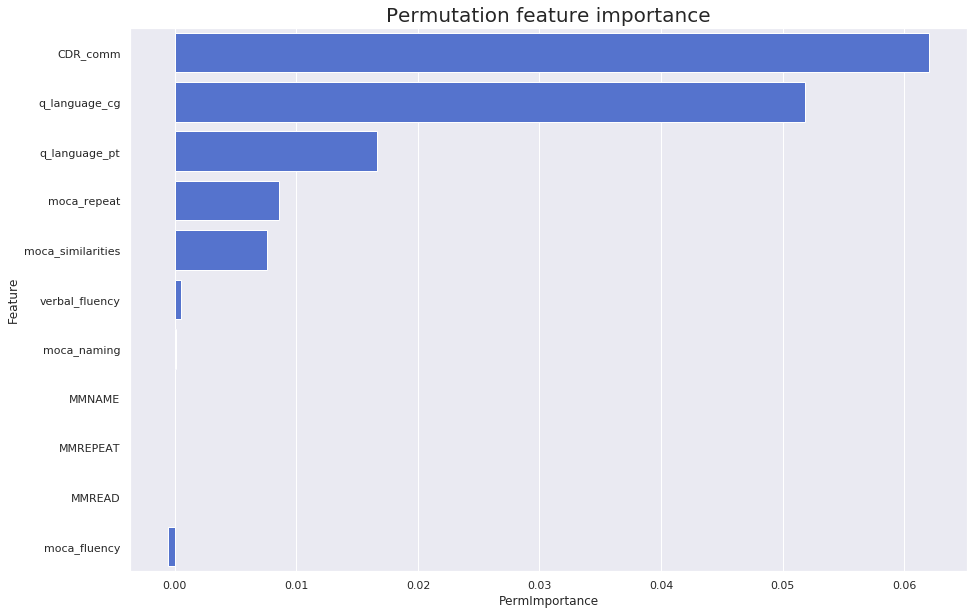

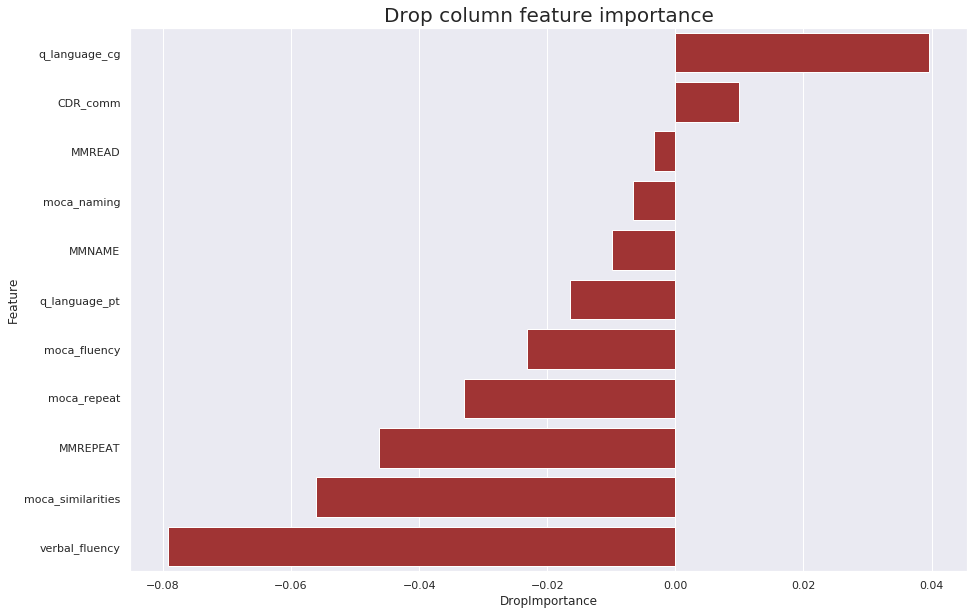

<Figure size 1080x720 with 0 Axes>

In [0]:
lng = ['moca_naming','moca_repeat','moca_fluency','moca_similarities','MMNAME',
       'MMREPEAT','MMREAD','CDR_comm',
       'verbal_fluency', 'q_language_pt','q_language_cg']
adni_lng = adni_pair_X.loc[:,lng]
clinic_lng = clinic_pair_X.loc[:,lng]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_lng_2 = paired_analyses(adni_lng, adni_pair_y2, clinic_lng, clinic_pair_y2)
pair_ehr_lng_2.to_csv(f'{dir}/Output/pair_ehr_lng_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_lng_2 = paired_feature(adni_lng, adni_pair_y2, clinic_lng, clinic_pair_y2)
pair_features_lng_2.to_csv(f'{dir}/Output/pair_features_lng_2.csv', index=False)

### All memory



~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[ 88  37]
 [ 38 140]]
Accuracy: 	 0.7524752475247525
AUC: 		 0.7452584269662922
Kappa: 		 0.4899333378223689
F1 score: 	 0.7887323943661972


~~XGBoost~~
[[101  24]
 [ 44 134]]
Accuracy: 	 0.7755775577557755
AUC: 		 0.7804044943820224
Kappa: 		 0.5477611940298508
F1 score: 	 0.7976190476190476


~~MLP~~
[[113  12]
 [ 41 137]]
Accuracy: 	 0.8250825082508251
AUC: 		 0.8368314606741574
Kappa: 		 0.6511718834850229
F1 score: 	 0.8379204892966361



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



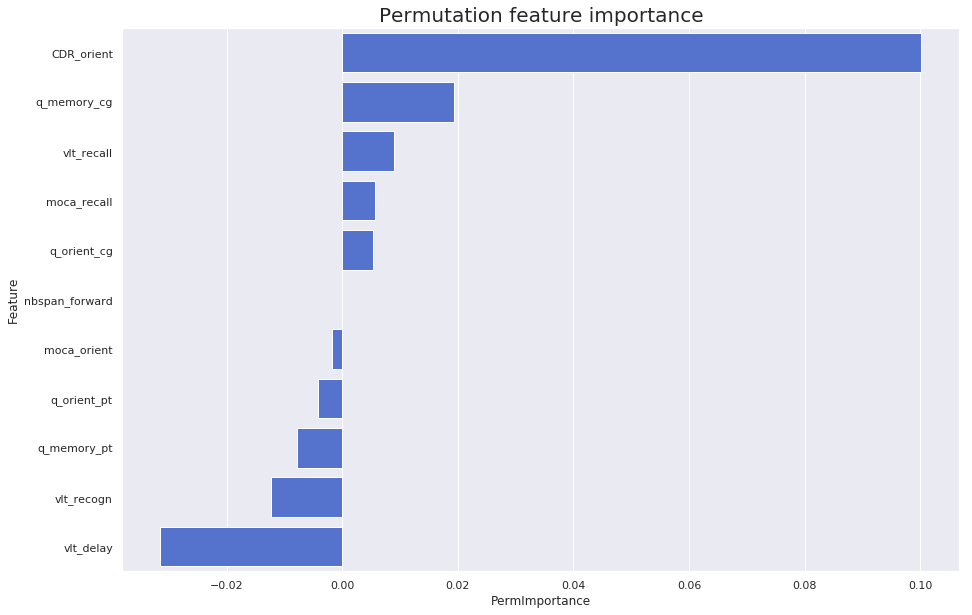

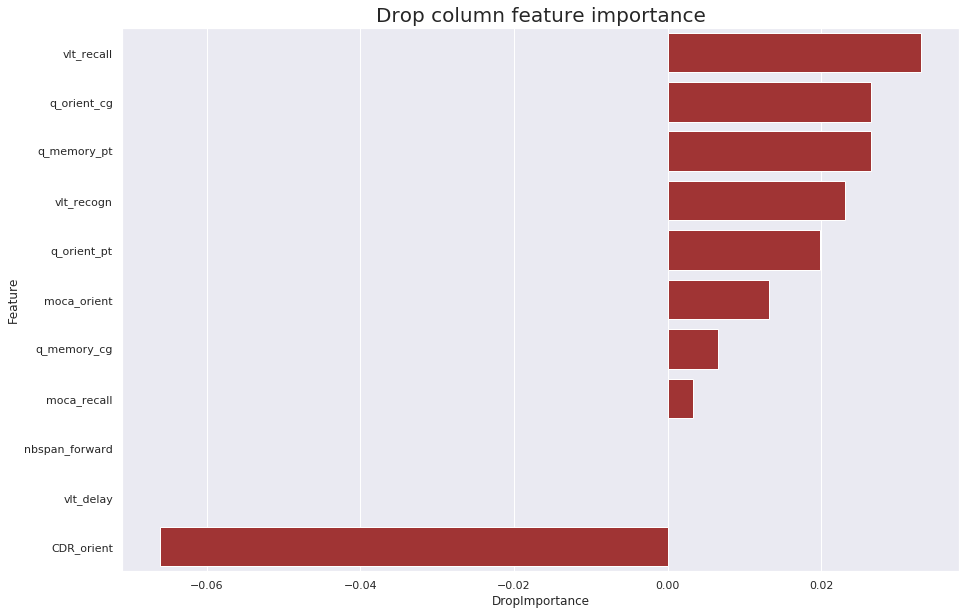

<Figure size 1080x720 with 0 Axes>

In [0]:
mem = ['moca_orient','CDR_orient','vlt_recogn','nbspan_forward','vlt_recall',
       'q_orient_pt','q_orient_cg','moca_recall', 'vlt_delay', 
       'q_memory_pt','q_memory_cg']
adni_mem = adni_pair_X.loc[:,mem]
clinic_mem = clinic_pair_X.loc[:,mem]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_mem_2 = paired_analyses(adni_mem, adni_pair_y2, clinic_mem, clinic_pair_y2)
pair_ehr_mem_2.to_csv(f'{dir}/Output/pair_ehr_mem_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_mem_2 = paired_feature(adni_mem, adni_pair_y2, clinic_mem, clinic_pair_y2)
pair_features_mem_2.to_csv(f'{dir}/Output/pair_features_mem_2.csv', index=False)

### All executive funcitoning



~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[ 67  58]
 [ 18 160]]
Accuracy: 	 0.7491749174917491
AUC: 		 0.717438202247191
Kappa: 		 0.4566304860783389
F1 score: 	 0.8080808080808082


~~XGBoost~~
[[ 22 103]
 [  6 172]]
Accuracy: 	 0.6402640264026402
AUC: 		 0.5711460674157304
Kappa: 		 0.1608780710892045
F1 score: 	 0.7593818984547461


~~MLP~~
[[  2 123]
 [  7 171]]
Accuracy: 	 0.570957095709571
AUC: 		 0.4883370786516854
Kappa: 		 -0.0270650813516895
F1 score: 	 0.7245762711864406



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



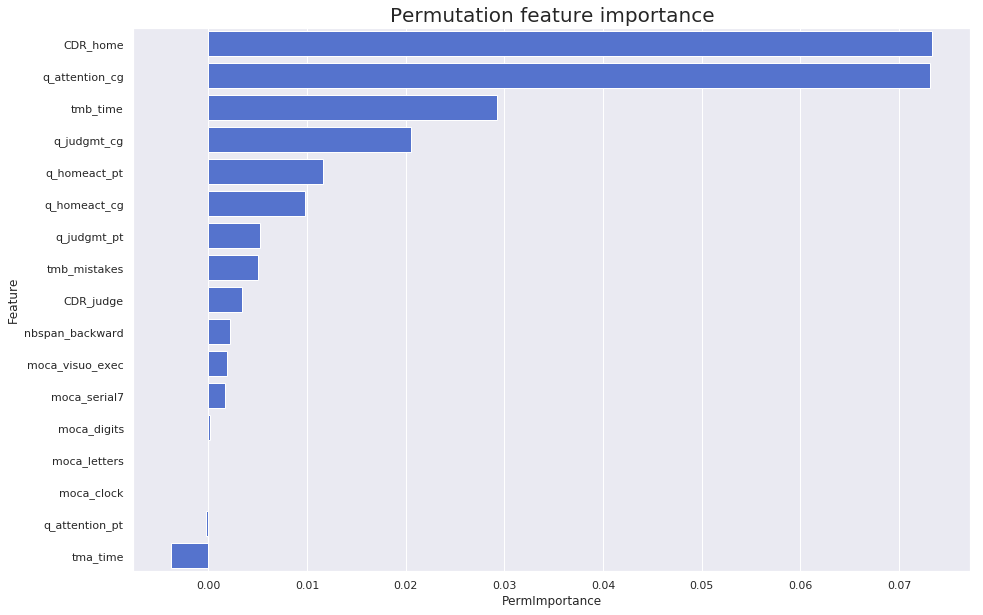

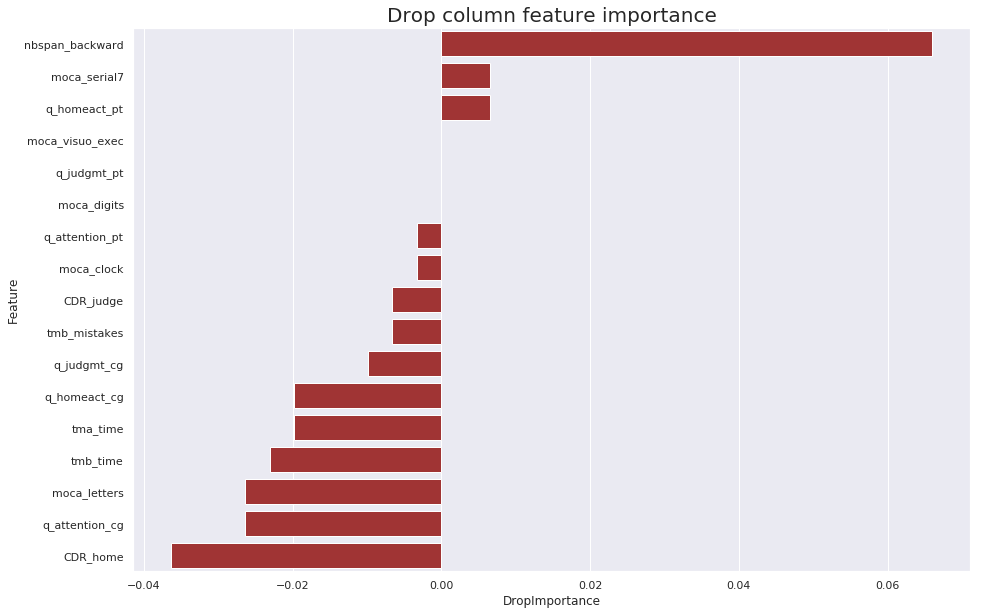

<Figure size 1080x720 with 0 Axes>

In [0]:
exe = ['moca_digits','moca_letters','moca_serial7',
       'q_attention_pt','q_attention_cg','moca_visuo_exec','CDR_judge',
       'CDR_home','nbspan_backward','q_judgmt_pt','q_judgmt_cg','q_homeact_pt',
       'q_homeact_cg','moca_clock', 'tma_time', 'tmb_time', 'tmb_mistakes']
adni_exe = adni_pair_X.loc[:,exe]
clinic_exe = clinic_pair_X.loc[:,exe]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_exe_2 = paired_analyses(adni_exe, adni_pair_y2, clinic_exe, clinic_pair_y2)
pair_ehr_exe_2.to_csv(f'{dir}/Output/pair_ehr_exe_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_exe_2 = paired_feature(adni_exe, adni_pair_y2, clinic_exe, clinic_pair_y2)
pair_features_exe_2.to_csv(f'{dir}/Output/pair_features_exe_2.csv', index=False)

### All above cognitive domain features


~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~

~~Random Forest~~
[[ 72  53]
 [ 17 161]]
Accuracy: 	 0.768976897689769
AUC: 		 0.740247191011236
Kappa: 		 0.502019158527423
F1 score: 	 0.8214285714285714


~~XGBoost~~
[[ 73  52]
 [ 25 153]]
Accuracy: 	 0.7458745874587459
AUC: 		 0.7217752808988764
Kappa: 		 0.45828786366063756
F1 score: 	 0.7989556135770236


~~MLP~~
[[114  11]
 [ 34 144]]
Accuracy: 	 0.8514851485148515
AUC: 		 0.860494382022472
Kappa: 		 0.7017651304709202
F1 score: 	 0.8648648648648649



~~~~~~~~ Feature Analyses, Binary ~~~~~~~~



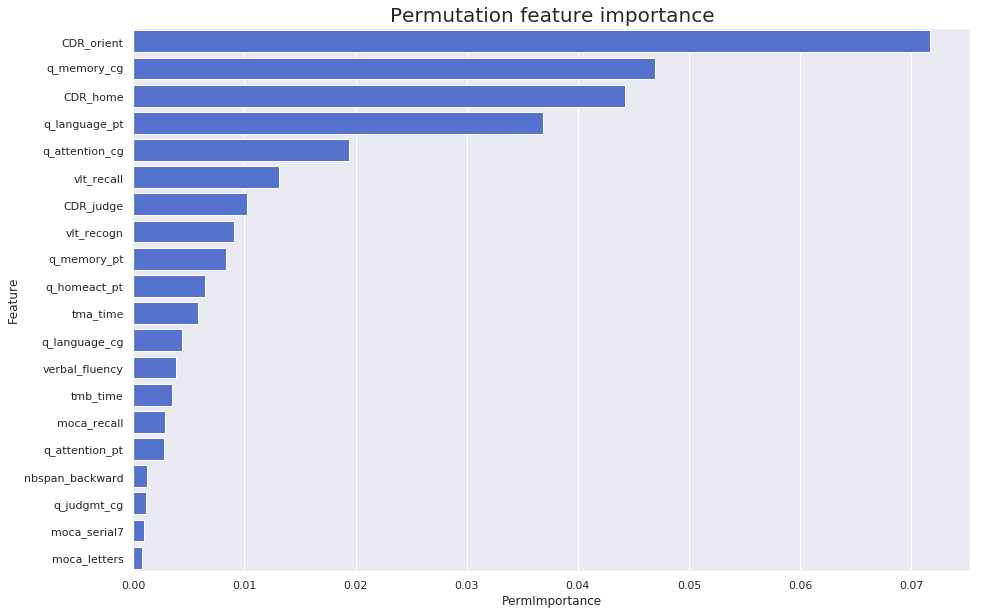

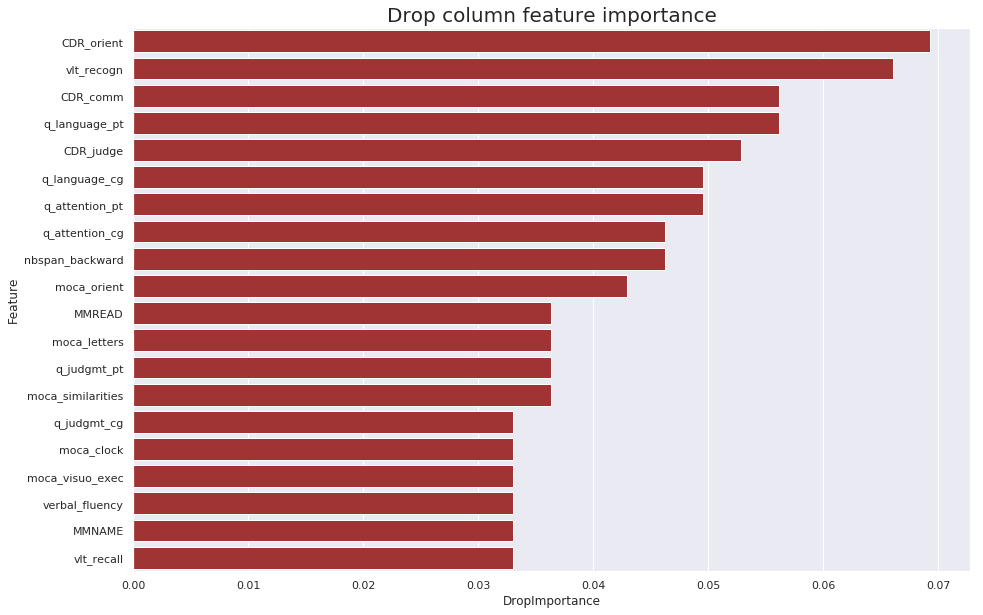

<Figure size 1080x720 with 0 Axes>

In [0]:
all = ['moca_orient','CDR_orient','vlt_recogn','nbspan_forward','vlt_recall',
       'q_orient_pt','q_orient_cg','moca_recall', 'vlt_delay', 
       'q_memory_pt','q_memory_cg',
       'moca_naming','moca_repeat','moca_fluency','moca_similarities','MMNAME',
       'MMREPEAT','MMREAD','CDR_comm',
       'verbal_fluency', 'q_language_pt','q_language_cg',
       'moca_digits','moca_letters','moca_serial7',
       'q_attention_pt','q_attention_cg','moca_visuo_exec','CDR_judge',
       'CDR_home','nbspan_backward','q_judgmt_pt','q_judgmt_cg','q_homeact_pt',
       'q_homeact_cg','moca_clock', 'tma_time', 'tmb_time', 'tmb_mistakes']
adni_all = adni_pair_X.loc[:,all]
clinic_all = clinic_pair_X.loc[:,all]


#### Predictive Analyses (2)
print('\n~~~~~~~~ Predictive Analyses, Binary ~~~~~~~~\n')
pair_ehr_all_2 = paired_analyses(adni_all, adni_pair_y2, clinic_all, clinic_pair_y2)
pair_ehr_all_2.to_csv(f'{dir}/Output/pair_ehr_all_2.csv', index=False)
#### Feature Analyses (2)
print('\n~~~~~~~~ Feature Analyses, Binary ~~~~~~~~\n')
pair_features_all_2 = paired_feature(adni_all, adni_pair_y2, clinic_all, clinic_pair_y2)
pair_features_all_2.to_csv(f'{dir}/Output/pair_features_all_2.csv', index=False)

# Model comparison - Paired

In [0]:
adni_pair_X = pd.read_csv(f'{dir}/Data/adni_pair_X.csv')
clinic_pair_X = pd.read_csv(f'{dir}/Data/sm_clinic_pair_X.csv')

adni_pair_y2 = pd.read_csv(f'{dir}/Data/adni_pair_y2.csv')
adni_pair_y3 = pd.read_csv(f'{dir}/Data/adni_pair_y3.csv')

clinic_pair_y2 = pd.read_csv(f'{dir}/Data/sm_clinic_pair_y2.csv', header=None, names=['Impaired'])
# clinic_pair_y3 = pd.read_csv(f'{dir}/Data/sm_clinic_pair_y3.csv', header=None)

In [0]:
stm = ['moca_orient','CDR_orient','vlt_recogn','nbspan_forward','vlt_recall',
       'q_orient_pt','q_orient_cg']
adni_stm = adni_pair_X.loc[:,stm]
clinic_stm = clinic_pair_X.loc[:,stm]

ltm = ['moca_recall', 'vlt_delay', 'q_memory_pt','q_memory_cg']
adni_ltm = adni_pair_X.loc[:,ltm]
clinic_ltm = clinic_pair_X.loc[:,ltm]

att = ['moca_digits','moca_letters','moca_serial7',
       'q_attention_pt','q_attention_cg']
adni_att = adni_pair_X.loc[:,att]
clinic_att = clinic_pair_X.loc[:,att]

exf = ['moca_visuo_exec','CDR_judge','CDR_home','nbspan_backward','q_judgmt_pt',
       'q_judgmt_cg','q_homeact_pt','q_homeact_cg']
adni_exf = adni_pair_X.loc[:,exf]
clinic_exf = clinic_pair_X.loc[:,exf]

vis = ['moca_clock', 'tma_time', 'tmb_time', 'tmb_mistakes']
adni_vis = adni_pair_X.loc[:,vis]
clinic_vis = clinic_pair_X.loc[:,vis]

lng = ['moca_naming','moca_repeat','moca_fluency','moca_similarities','MMNAME',
       'MMREPEAT','MMREAD','CDR_comm',
       'verbal_fluency', 'q_language_pt','q_language_cg']
adni_lng = adni_pair_X.loc[:,lng]
clinic_lng = clinic_pair_X.loc[:,lng]

mem = ['moca_orient','CDR_orient','vlt_recogn','nbspan_forward','vlt_recall',
       'q_orient_pt','q_orient_cg','moca_recall', 'vlt_delay', 
       'q_memory_pt','q_memory_cg']
adni_mem = adni_pair_X.loc[:,mem]
clinic_mem = clinic_pair_X.loc[:,mem]

exe = ['moca_digits','moca_letters','moca_serial7',
       'q_attention_pt','q_attention_cg','moca_visuo_exec','CDR_judge',
       'CDR_home','nbspan_backward','q_judgmt_pt','q_judgmt_cg','q_homeact_pt',
       'q_homeact_cg','moca_clock', 'tma_time', 'tmb_time', 'tmb_mistakes']
adni_exe = adni_pair_X.loc[:,exe]
clinic_exe = clinic_pair_X.loc[:,exe]

all = ['moca_orient','CDR_orient','vlt_recogn','nbspan_forward','vlt_recall',
       'q_orient_pt','q_orient_cg','moca_recall', 'vlt_delay', 
       'q_memory_pt','q_memory_cg',
       'moca_naming','moca_repeat','moca_fluency','moca_similarities','MMNAME',
       'MMREPEAT','MMREAD','CDR_comm',
       'verbal_fluency', 'q_language_pt','q_language_cg',
       'moca_digits','moca_letters','moca_serial7',
       'q_attention_pt','q_attention_cg','moca_visuo_exec','CDR_judge',
       'CDR_home','nbspan_backward','q_judgmt_pt','q_judgmt_cg','q_homeact_pt',
       'q_homeact_cg','moca_clock', 'tma_time', 'tmb_time', 'tmb_mistakes']
adni_all = adni_pair_X.loc[:,all]
clinic_all = clinic_pair_X.loc[:,all]

## Bimodal

In [0]:
from keras.layers import Input, Dense, Activation, Dropout, Flatten
from keras.layers.merge import concatenate
from keras.models import Model

from keras.utils import plot_model

In [0]:
adni_mem = adni_pair_X.loc[:,mem]
adni_stm = adni_pair_X.loc[:,stm]
adni_ltm = adni_pair_X.loc[:,ltm]

adni_exe = adni_pair_X.loc[:,exe]
adni_att = adni_pair_X.loc[:,att]
adni_exf = adni_pair_X.loc[:,exf]
adni_vis = adni_pair_X.loc[:,vis]

adni_lng = adni_pair_X.loc[:,lng]

adni_allcog = adni_pair_X.loc[:,all]


clinic_mem = clinic_pair_X.loc[:,mem]
clinic_stm = clinic_pair_X.loc[:,stm]
clinic_ltm = clinic_pair_X.loc[:,ltm]

clinic_exe = clinic_pair_X.loc[:,exe]
clinic_att = clinic_pair_X.loc[:,att]
clinic_exf = clinic_pair_X.loc[:,exf]
clinic_vis = clinic_pair_X.loc[:,vis]

clinic_lng = clinic_pair_X.loc[:,lng]

clinic_allcog = clinic_pair_X.loc[:,all]

In [0]:
adni_allcog.shape[1]

39

### Three category model (Memory, EF, Language)

In [0]:
len_mem = adni_mem.shape[1]
len_exe = adni_exe.shape[1]
len_lng = adni_lng.shape[1]


inputs_mem = Input(shape=(len_mem,))
dense_mem = Dense(105, activation='relu')(inputs_mem)
dense_mem = Dropout(0.2)(dense_mem)
dense_mem = Dense(60, activation='relu')(dense_mem)
# dense_mem = Dense(10, activation='relu')(dense_mem)
out_mem = Dense(15, activation='relu')(dense_mem)

inputs_exe = Input(shape=(len_exe,))
dense_exe = Dense(105, activation='relu')(inputs_exe)
dense_exe = Dropout(0.2)(dense_exe)
dense_exe = Dense(60, activation='relu')(dense_exe)
# dense_exe = Dense(10, activation='relu')(dense_exe)
out_exe = Dense(15, activation='relu')(dense_exe)

inputs_lng = Input(shape=(len_lng,))
dense_lng = Dense(105, activation='relu')(inputs_lng)
dense_lng = Dropout(0.2)(dense_lng)
dense_lng = Dense(60, activation='relu')(dense_lng)
# dense_lng = Dense(10, activation='relu')(dense_lng)
out_lng = Dense(15, activation='relu')(dense_lng)

out_flat = concatenate([out_mem,out_exe,out_lng])

dense_all = Dense(105, activation='relu')(out_flat)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(75, activation='relu')(dense_all)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(60, activation='relu')(dense_all)
dense_all = Dense(15, activation='relu')(dense_all)
outputs = Dense(1, activation='sigmoid')(dense_all)
model = Model(inputs=[inputs_mem, inputs_exe, inputs_lng], outputs=outputs)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 11)           0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 17)           0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 11)           0                                            
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 105)          1260        input_13[0][0]                   
__________________________________________________________________________________________________
dense_60 (

In [0]:
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit([adni_mem, adni_exe, adni_lng], adni_pair_y2, batch_size=1000, 
          epochs=3000, validation_split=0.2)

In [0]:
model.evaluate([clinic_mem, clinic_exe, clinic_lng], clinic_pair_y2) #3000 epochs

303/303 [==============================] - 0s 98us/step


[0.1481596318998746, 0.8877887794680328]

In [0]:
y_pred = model.predict([clinic_mem, clinic_exe, clinic_lng])

print('Accuracy: \t', accuracy_score(clinic_pair_y2, np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(clinic_pair_y2, y_pred))
print('Kappa: \t\t', cohen_kappa_score(clinic_pair_y2, np.rint(y_pred)))
print('F1: \t\t', f1_score(clinic_pair_y2, np.rint(y_pred)))
print('\n')
print(confusion_matrix(clinic_pair_y2, np.rint(y_pred)))

Accuracy: 	 0.8877887788778878
AUC: 		 0.9388314606741573
Kappa: 		 0.7695920558239399
F1: 		 0.9034090909090908


[[110  15]
 [ 19 159]]


### Six category model

In [0]:
len_stm = adni_stm.shape[1]
len_ltm = adni_ltm.shape[1]
len_att = adni_att.shape[1]
len_exf = adni_exf.shape[1]
len_vis = adni_vis.shape[1]
len_lng = adni_lng.shape[1]


inputs_stm = Input(shape=(len_stm,))
dense_stm = Dense(105, activation='relu')(inputs_stm)
dense_stm = Dropout(0.2)(dense_stm)
dense_stm = Dense(60, activation='relu')(dense_stm)
# dense_stm = Dense(10, activation='relu')(dense_stm)
out_stm = Dense(15, activation='relu')(dense_stm)

inputs_ltm = Input(shape=(len_ltm,))
dense_ltm = Dense(105, activation='relu')(inputs_ltm)
dense_ltm = Dropout(0.2)(dense_ltm)
dense_ltm = Dense(60, activation='relu')(dense_ltm)
# dense_ltm = Dense(10, activation='relu')(dense_ltm)
out_ltm = Dense(15, activation='relu')(dense_ltm)

inputs_att = Input(shape=(len_att,))
dense_att = Dense(105, activation='relu')(inputs_att)
dense_att = Dropout(0.2)(dense_att)
dense_att = Dense(60, activation='relu')(dense_att)
# dense_att = Dense(10, activation='relu')(dense_att)
out_att = Dense(15, activation='relu')(dense_att)

inputs_exf = Input(shape=(len_exf,))
dense_exf = Dense(105, activation='relu')(inputs_exf)
dense_exf = Dropout(0.2)(dense_exf)
dense_exf = Dense(60, activation='relu')(dense_exf)
# dense_exf = Dense(10, activation='relu')(dense_exf)
out_exf = Dense(15, activation='relu')(dense_exf)

inputs_vis = Input(shape=(len_vis,))
dense_vis = Dense(105, activation='relu')(inputs_vis)
dense_vis = Dropout(0.2)(dense_vis)
dense_vis = Dense(60, activation='relu')(dense_vis)
# dense_vis = Dense(10, activation='relu')(dense_vis)
out_vis = Dense(15, activation='relu')(dense_vis)

inputs_lng = Input(shape=(len_lng,))
dense_lng = Dense(105, activation='relu')(inputs_lng)
dense_lng = Dropout(0.2)(dense_lng)
dense_lng = Dense(60, activation='relu')(dense_lng)
# dense_lng = Dense(10, activation='relu')(dense_lng)
out_lng = Dense(15, activation='relu')(dense_lng)

out_flat = concatenate([out_stm,out_ltm,out_att,out_exf,out_vis,out_lng])

dense_all = Dense(105, activation='relu')(out_flat)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(75, activation='relu')(dense_all)
dense_all = Dropout(0.2)(dense_all)
dense_all = Dense(60, activation='relu')(dense_all)
dense_all = Dense(15, activation='relu')(dense_all)
outputs = Dense(1, activation='sigmoid')(dense_all)
model = Model(inputs=[inputs_stm, inputs_ltm, inputs_att, inputs_exf, inputs_vis, inputs_lng], outputs=outputs)

# model.summary()

In [0]:
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit([adni_stm, adni_ltm, adni_att, adni_exf, adni_vis, adni_lng], adni_pair_y2, batch_size=1000, 
          epochs=2000, validation_split=0.2)

In [0]:
model.evaluate([clinic_stm, clinic_ltm, clinic_att, clinic_exf, clinic_vis, clinic_lng], clinic_pair_y2) #6000 epochs

303/303 [==============================] - 0s 116us/step


[0.11828120446244482, 0.8283828386772584]

In [0]:
y_pred = model.predict([clinic_stm, clinic_ltm, clinic_att, clinic_exf, clinic_vis, clinic_lng])

print('Accuracy: \t', accuracy_score(clinic_pair_y2, np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(clinic_pair_y2, y_pred))
print('Kappa: \t\t', cohen_kappa_score(clinic_pair_y2, np.rint(y_pred)))
print('F1: \t\t', f1_score(clinic_pair_y2, np.rint(y_pred)))
print('\n')
print(confusion_matrix(clinic_pair_y2, np.rint(y_pred)))

Accuracy: 	 0.8283828382838284
AUC: 		 0.9483595505617977
Kappa: 		 0.6581471034931656
F1: 		 0.8404907975460123


[[114  11]
 [ 41 137]]


## Unimodal

In [0]:
from keras.models import Sequential

model = Sequential()
model.add(Dense(105, activation='relu', input_dim=adni_pair_X.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(75, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(60, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit(adni_pair_X, adni_pair_y2, batch_size=1000, 
          epochs=2000, validation_split=0.2)

In [0]:
model.evaluate(clinic_pair_X, clinic_pair_y2)

In [0]:
y_pred = model.predict(clinic_pair_X) #11000 epochs

print('Accuracy: \t', accuracy_score(clinic_pair_y2, np.rint(y_pred)))
print('AUC: \t\t', roc_auc_score(clinic_pair_y2, y_pred))
print('Kappa: \t\t', cohen_kappa_score(clinic_pair_y2, np.rint(y_pred)))
print('F1: \t\t', f1_score(clinic_pair_y2, np.rint(y_pred)))
print('\n')
print(confusion_matrix(clinic_pair_y2, np.rint(y_pred)))

Accuracy: 	 0.834983498349835
AUC: 		 0.8945617977528091
Kappa: 		 0.6643477490251684
F1: 		 0.8546511627906977


[[106  19]
 [ 31 147]]


# Thresholds



## Physician Threshold

- MOCA: < 25 = impaired, <20 = AD
- TrailmakingA: > 45 = impaired, > 80 = AD
- TrailmakingB: > 133 = impaired, >173 = AD
- Verbal fluency: < 13 = impaired, < 7 = AD
- vlt_recall: < 23 = impaired, < 16 = AD
- vlt_delay: < 8 = impaired, < 4 = AD
- QDRS: > 1.5 = MCI  /  > 6 = AD (Galvin, 2015)
- FAQ: >6 = impairment (Teng, 2010)



In [0]:
adni_us_X = pd.read_csv(f'{dir}/Data/adni_pair_unscaled_X.csv')
clinic_us_X = pd.read_csv(f'{dir}/Data/sm_clinic_pair_us_X.csv')
adni_us_y2 = pd.read_csv(f'{dir}/Data/adni_pair_us_y2.csv')
adni_us_y3 = pd.read_csv(f'{dir}/Data/adni_pair_us_y3.csv')
clinic_us_y2 = clinic_pair_y2

In [0]:
adni_us_X['faq_total'] = adni_us_X[['faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10']].sum(axis=1)
adni_us_X['moca_total'] = adni_us_X[['moca_visuo_exec', 'moca_clock',
       'moca_naming', 'moca_digits', 'moca_letters', 'moca_serial7',
       'moca_repeat', 'moca_fluency', 'moca_similarities', 'moca_recall',
       'moca_orient']].sum(axis=1)
adni_us_X['qdrs_total_pt'] = adni_us_X[['q_memory_pt', 'q_orient_pt', 
       'q_judgmt_pt', 'q_outsideact_pt',
       'q_homeact_pt', 'q_language_pt', 'q_attention_pt']].sum(axis=1)
adni_us_X['qdrs_total_cg'] = adni_us_X[['q_memory_cg',
       'q_orient_cg', 'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg',
       'q_language_cg', 'q_attention_cg']].sum(axis=1)
clinic_us_X['faq_total'] = clinic_us_X[['faq1', 'faq2', 'faq3', 'faq4',
       'faq5', 'faq6', 'faq7', 'faq8', 'faq9', 'faq10']].sum(axis=1)
clinic_us_X['moca_total'] = clinic_us_X[['moca_visuo_exec', 'moca_clock',
       'moca_naming', 'moca_digits', 'moca_letters', 'moca_serial7',
       'moca_repeat', 'moca_fluency', 'moca_similarities', 'moca_recall',
       'moca_orient']].sum(axis=1)
clinic_us_X['qdrs_total_pt'] = clinic_us_X[['q_memory_pt', 'q_orient_pt', 
       'q_judgmt_pt', 'q_outsideact_pt',
       'q_homeact_pt', 'q_language_pt', 'q_attention_pt']].sum(axis=1)
clinic_us_X['qdrs_total_cg'] = clinic_us_X[['q_memory_cg',
       'q_orient_cg', 'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg',
       'q_language_cg', 'q_attention_cg']].sum(axis=1)
adni_us_X['nbspan_forward'] = adni_us_X['nbspan_forward']*12
adni_us_X['nbspan_backward'] = adni_us_X['nbspan_backward']*12

In [0]:
adni_us_X['thresh_moca_2'] = adni_us_X['moca_total'].apply(lambda x: 1 if x<=25 else 0)
adni_us_X['thresh_moca_3'] = adni_us_X[['moca_total','thresh_moca_2']].apply(lambda x: 2 if x['moca_total']<=20 else x['thresh_moca_2'], axis=1)
adni_us_X['thresh_tma_2'] = adni_us_X['tma_time'].apply(lambda x: 1 if x>=35 else 0)
adni_us_X['thresh_tma_3'] = adni_us_X[['tma_time','thresh_tma_2']].apply(lambda x: 2 if x['tma_time']>=54 else x['thresh_tma_2'], axis=1)
adni_us_X['thresh_tmb_2'] = adni_us_X['tmb_time'].apply(lambda x: 1 if x>=115 else 0)
adni_us_X['thresh_tmb_3'] = adni_us_X[['tmb_time','thresh_tmb_2']].apply(lambda x: 2 if x['tmb_time']>=154 else x['thresh_tmb_2'], axis=1)
adni_us_X['thresh_verbal_fluency_2'] = adni_us_X['verbal_fluency'].apply(lambda x: 1 if x<=13 else 0)
adni_us_X['thresh_verbal_fluency_3'] = adni_us_X[['verbal_fluency','thresh_verbal_fluency_2']].apply(lambda x: 2 if x['verbal_fluency']<=7 else x['thresh_verbal_fluency_2'], axis=1)
adni_us_X['thresh_vlt_recall_2'] = adni_us_X['vlt_recall'].apply(lambda x: 1 if x<=23 else 0)
adni_us_X['thresh_vlt_recall_3'] = adni_us_X[['vlt_recall','thresh_vlt_recall_2']].apply(lambda x: 2 if x['vlt_recall']<=16 else x['thresh_vlt_recall_2'], axis=1)
adni_us_X['thresh_vlt_delay_2'] = adni_us_X['vlt_delay'].apply(lambda x: 1 if x<=8 else 0)
adni_us_X['thresh_vlt_delay_3'] = adni_us_X[['vlt_delay','thresh_vlt_delay_2']].apply(lambda x: 2 if x['vlt_delay']<=4 else x['thresh_vlt_delay_2'], axis=1)
adni_us_X['thresh_qdrs_pt_2'] = adni_us_X['qdrs_total_pt'].apply(lambda x: 1 if x>=1.5 else 0)
adni_us_X['thresh_qdrs_pt_3'] = adni_us_X[['qdrs_total_pt','thresh_qdrs_pt_2']].apply(lambda x: 2 if x['qdrs_total_pt']>=6 else x['thresh_qdrs_pt_2'], axis=1)
adni_us_X['thresh_qdrs_cg_2'] = adni_us_X['qdrs_total_cg'].apply(lambda x: 1 if x>=1.5 else 0)
adni_us_X['thresh_qdrs_cg_3'] = adni_us_X[['qdrs_total_cg','thresh_qdrs_cg_2']].apply(lambda x: 2 if x['qdrs_total_cg']>=6 else x['thresh_qdrs_cg_2'], axis=1)
adni_us_X['thresh_faq'] = adni_us_X['faq_total'].apply(lambda x: 1 if x>=6 else 0)
adni_thresh = adni_us_X.loc[:,['thresh_moca_2','thresh_tma_2','thresh_verbal_fluency_2','thresh_vlt_recall_2',
                              'thresh_vlt_delay_2','thresh_qdrs_pt_2','thresh_qdrs_cg_2','thresh_faq']]
adni_totals = adni_us_X.loc[:,['faq_total','moca_total','qdrs_total_cg','qdrs_total_pt','tma_time',
                              'tmb_time','verbal_fluency','vlt_recall','vlt_delay']]
adni_separated = adni_us_X.loc[:,['faq1', 'faq2', 'faq3', 'faq4','faq5', 'faq6',
                                  'faq7', 'faq8', 'faq9', 'faq10','moca_visuo_exec', 'moca_clock',
                                  'moca_naming', 'moca_digits', 'moca_letters', 'moca_serial7',
                                  'moca_repeat', 'moca_fluency', 'moca_similarities', 'moca_recall',
                                  'moca_orient','q_memory_pt', 'q_orient_pt', 
                                  'q_judgmt_pt', 'q_outsideact_pt',
                                  'q_homeact_pt', 'q_language_pt', 'q_attention_pt','q_memory_cg',
                                  'q_orient_cg', 'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg',
                                  'q_language_cg', 'q_attention_cg','tma_time',
                                  'tmb_time','verbal_fluency','vlt_recall','vlt_delay']]

clinic_us_X['thresh_moca_2'] = clinic_us_X['moca_total'].apply(lambda x: 1 if x<=25 else 0)
clinic_us_X['thresh_moca_3'] = clinic_us_X[['moca_total','thresh_moca_2']].apply(lambda x: 2 if x['moca_total']<=20 else x['thresh_moca_2'], axis=1)
clinic_us_X['thresh_tma_2'] = clinic_us_X['tma_time'].apply(lambda x: 1 if x>=35 else 0)
clinic_us_X['thresh_tma_3'] = clinic_us_X[['tma_time','thresh_tma_2']].apply(lambda x: 2 if x['tma_time']>=54 else x['thresh_tma_2'], axis=1)
clinic_us_X['thresh_tmb_2'] = clinic_us_X['tmb_time'].apply(lambda x: 1 if x>=115 else 0)
clinic_us_X['thresh_tmb_3'] = clinic_us_X[['tmb_time','thresh_tmb_2']].apply(lambda x: 2 if x['tmb_time']>=154 else x['thresh_tmb_2'], axis=1)
clinic_us_X['thresh_verbal_fluency_2'] = clinic_us_X['verbal_fluency'].apply(lambda x: 1 if x<=13 else 0)
clinic_us_X['thresh_verbal_fluency_3'] = clinic_us_X[['verbal_fluency','thresh_verbal_fluency_2']].apply(lambda x: 2 if x['verbal_fluency']<=7 else x['thresh_verbal_fluency_2'], axis=1)
clinic_us_X['thresh_vlt_recall_2'] = clinic_us_X['vlt_recall'].apply(lambda x: 1 if x<=23 else 0)
clinic_us_X['thresh_vlt_recall_3'] = clinic_us_X[['vlt_recall','thresh_vlt_recall_2']].apply(lambda x: 2 if x['vlt_recall']<=16 else x['thresh_vlt_recall_2'], axis=1)
clinic_us_X['thresh_vlt_delay_2'] = clinic_us_X['vlt_delay'].apply(lambda x: 1 if x<=8 else 0)
clinic_us_X['thresh_vlt_delay_3'] = clinic_us_X[['vlt_delay','thresh_vlt_delay_2']].apply(lambda x: 2 if x['vlt_delay']<=4 else x['thresh_vlt_delay_2'], axis=1)
clinic_us_X['thresh_qdrs_pt_2'] = clinic_us_X['qdrs_total_pt'].apply(lambda x: 1 if x>=1.5 else 0)
clinic_us_X['thresh_qdrs_pt_3'] = clinic_us_X[['qdrs_total_pt','thresh_qdrs_pt_2']].apply(lambda x: 2 if x['qdrs_total_pt']>=6 else x['thresh_qdrs_pt_2'], axis=1)
clinic_us_X['thresh_qdrs_cg_2'] = clinic_us_X['qdrs_total_cg'].apply(lambda x: 1 if x>=1.5 else 0)
clinic_us_X['thresh_qdrs_cg_3'] = clinic_us_X[['qdrs_total_cg','thresh_qdrs_cg_2']].apply(lambda x: 2 if x['qdrs_total_cg']>=6 else x['thresh_qdrs_cg_2'], axis=1)
clinic_us_X['thresh_faq'] = clinic_us_X['faq_total'].apply(lambda x: 1 if x>=6 else 0)
clinic_thresh = clinic_us_X.loc[:,['thresh_moca_2','thresh_tma_2','thresh_verbal_fluency_2','thresh_vlt_recall_2',
                              'thresh_vlt_delay_2','thresh_qdrs_pt_2','thresh_qdrs_cg_2','thresh_faq']]
clinic_totals = clinic_us_X.loc[:,['faq_total','moca_total','qdrs_total_cg','qdrs_total_pt','tma_time',
                              'tmb_time','verbal_fluency','vlt_recall','vlt_delay']]
clinic_separated = clinic_us_X.loc[:,['faq1', 'faq2', 'faq3', 'faq4','faq5', 'faq6',
                                  'faq7', 'faq8', 'faq9', 'faq10','moca_visuo_exec', 'moca_clock',
                                  'moca_naming', 'moca_digits', 'moca_letters', 'moca_serial7',
                                  'moca_repeat', 'moca_fluency', 'moca_similarities', 'moca_recall',
                                  'moca_orient','q_memory_pt', 'q_orient_pt', 
                                  'q_judgmt_pt', 'q_outsideact_pt',
                                  'q_homeact_pt', 'q_language_pt', 'q_attention_pt','q_memory_cg',
                                  'q_orient_cg', 'q_judgmt_cg', 'q_outsideact_cg', 'q_homeact_cg',
                                  'q_language_cg', 'q_attention_cg','tma_time',
                                  'tmb_time','verbal_fluency','vlt_recall','vlt_delay']]

## Threshold Comparison

#### "Any" threshold

Only 15 did not meet any threshold

In [0]:
adni_us_X['y_thresh_any'] = adni_us_X[['thresh_moca_2','thresh_tma_2',
                                       'thresh_tmb_2','thresh_verbal_fluency_2',
                                       'thresh_vlt_recall_2','thresh_faq',
                                       'thresh_vlt_delay_2','thresh_qdrs_pt_2',
                                       'thresh_qdrs_cg_2']].any(1)

In [0]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, f1_score, roc_auc_score, accuracy_score

print(confusion_matrix(adni_us_y2['Impaired'], adni_us_X['y_thresh_any']))
print('Accuracy: \t', accuracy_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_any']))
print('AUC: \t\t', roc_auc_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_any']))
print('Kappa: \t\t', cohen_kappa_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_any']))
print('F1 score: \t', f1_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_any']))

[[ 14 406]
 [  1 746]]
Accuracy: 	 0.6512425021422451
AUC: 		 0.5159973226238287
Kappa: 		 0.040553889040390256
F1 score: 	 0.785676671932596


In [0]:
clinic_us_X['y_thresh_any'] = clinic_us_X[['thresh_moca_2','thresh_tma_2',
                                       'thresh_tmb_2','thresh_verbal_fluency_2',
                                       'thresh_vlt_recall_2','thresh_faq',
                                       'thresh_vlt_delay_2','thresh_qdrs_pt_2',
                                       'thresh_qdrs_cg_2']].any(1)

In [0]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, f1_score, roc_auc_score, accuracy_score

print(confusion_matrix(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_any']))
print('Accuracy: \t', accuracy_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_any']))
print('AUC: \t\t', roc_auc_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_any']))
print('Kappa: \t\t', cohen_kappa_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_any']))
print('F1 score: \t', f1_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_any']))

[[ 43  82]
 [  0 178]]
Accuracy: 	 0.7293729372937293
AUC: 		 0.6719999999999999
Kappa: 		 0.3812322558151118
F1 score: 	 0.8127853881278538


#### "Avg" threshold

In [0]:
adni_us_X['y_thresh_sum'] = adni_us_X[['thresh_moca_2','thresh_tma_2',
                                       'thresh_tmb_2','thresh_verbal_fluency_2',
                                       'thresh_vlt_recall_2','thresh_faq',
                                       'thresh_vlt_delay_2','thresh_qdrs_pt_2',
                                       'thresh_qdrs_cg_2']].astype(int).sum(1)
adni_us_X['y_thresh_avg3'] = adni_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=3 else 0)
adni_us_X['y_thresh_avg4'] = adni_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=4 else 0)
adni_us_X['y_thresh_avg5'] = adni_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=5 else 0)
adni_us_X['y_thresh_avg6'] = adni_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=6 else 0)

In [0]:
print(confusion_matrix(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg3']))

print('Accuracy: \t', accuracy_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg3']))
print('AUC: \t\t', roc_auc_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg3']))
print('Kappa: \t\t', cohen_kappa_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg3']))
print('F1 score: \t', f1_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg3']))

[[149 271]
 [ 47 700]]
Accuracy: 	 0.7275064267352185
AUC: 		 0.6459217823675655
Kappa: 		 0.33041397826181085
F1 score: 	 0.8149010477299186


In [0]:
print(confusion_matrix(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg4']))
print('Accuracy: \t', accuracy_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg4']))
print('AUC: \t\t', roc_auc_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg4']))
print('Kappa: \t\t', cohen_kappa_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg4']))
print('F1 score: \t', f1_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg4']))

[[246 174]
 [ 94 653]]
Accuracy: 	 0.7703513281919452
AUC: 		 0.729938802830369
Kappa: 		 0.47988425463979245
F1 score: 	 0.829733163913596


In [0]:
print(confusion_matrix(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg5']))
print('Accuracy: \t', accuracy_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg5']))
print('AUC: \t\t', roc_auc_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg5']))
print('Kappa: \t\t', cohen_kappa_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg5']))
print('F1 score: \t', f1_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg5']))

[[334  86]
 [177 570]]
Accuracy: 	 0.7746358183376179
AUC: 		 0.7791451520367185
Kappa: 		 0.5330132052821128
F1 score: 	 0.812544547398432


In [0]:
print(confusion_matrix(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg6']))
print('Accuracy: \t', accuracy_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg6']))
print('AUC: \t\t', roc_auc_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg6']))
print('Kappa: \t\t', cohen_kappa_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg6']))
print('F1 score: \t', f1_score(adni_us_y2['Impaired'], adni_us_X['y_thresh_avg6']))

[[383  37]
 [299 448]]
Accuracy: 	 0.712082262210797
AUC: 		 0.7558185121438132
Kappa: 		 0.4501720526001396
F1 score: 	 0.7272727272727273


In [0]:
clinic_us_X['y_thresh_sum'] = clinic_us_X[['thresh_moca_2','thresh_tma_2',
                                       'thresh_tmb_2','thresh_verbal_fluency_2',
                                       'thresh_vlt_recall_2','thresh_faq',
                                       'thresh_vlt_delay_2','thresh_qdrs_pt_2',
                                       'thresh_qdrs_cg_2']].astype(int).sum(1)
clinic_us_X['y_thresh_avg3'] = clinic_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=3 else 0)
clinic_us_X['y_thresh_avg4'] = clinic_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=4 else 0)
clinic_us_X['y_thresh_avg5'] = clinic_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=5 else 0)
clinic_us_X['y_thresh_avg6'] = clinic_us_X['y_thresh_sum'].apply(
                             lambda x: 1 if x>=6 else 0)

In [0]:
print(confusion_matrix(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg3']))

print('Accuracy: \t', accuracy_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg3']))
print('AUC: \t\t', roc_auc_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg3']))
print('Kappa: \t\t', cohen_kappa_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg3']))
print('F1 score: \t', f1_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg3']))

[[ 85  40]
 [  3 175]]
Accuracy: 	 0.858085808580858
AUC: 		 0.8315730337078651
Kappa: 		 0.6937163544041938
F1 score: 	 0.89058524173028


In [0]:
print(confusion_matrix(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg4']))
print('Accuracy: \t', accuracy_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg4']))
print('AUC: \t\t', roc_auc_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg4']))
print('Kappa: \t\t', cohen_kappa_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg4']))
print('F1 score: \t', f1_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg4']))


[[103  22]
 [ 14 164]]
Accuracy: 	 0.8811881188118812
AUC: 		 0.872674157303371
Kappa: 		 0.7525183773482167
F1 score: 	 0.901098901098901


In [0]:
print(confusion_matrix(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg5']))
print('Accuracy: \t', accuracy_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg5']))
print('AUC: \t\t', roc_auc_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg5']))
print('Kappa: \t\t', cohen_kappa_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg5']))
print('F1 score: \t', f1_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg5']))


[[108  17]
 [ 27 151]]
Accuracy: 	 0.8547854785478548
AUC: 		 0.8561573033707864
Kappa: 		 0.7039307128580946
F1 score: 	 0.8728323699421965


In [0]:
print(confusion_matrix(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg6']))
print('Accuracy: \t', accuracy_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg6']))
print('AUC: \t\t', roc_auc_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg6']))
print('Kappa: \t\t', cohen_kappa_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg6']))
print('F1 score: \t', f1_score(clinic_us_y2['Impaired'], clinic_us_X['y_thresh_avg6']))

[[112  13]
 [ 37 141]]
Accuracy: 	 0.834983498349835
AUC: 		 0.8440674157303371
Kappa: 		 0.669011622826182
F1 score: 	 0.8493975903614459


Clearly, the best approach if only thresholds are used is to identify if at least 4 metrics match above threshold

### ML Approach

#### Threshold decision tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(adni_thresh, adni_us_y2)

y_test = clinic_us_y2
y_pred = clf.predict(clinic_thresh)
print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[107  18]
 [ 24 154]]
Accuracy: 	 0.8613861386138614
AUC: 		 0.8605842696629213
Precision: 	 0.8953488372093024
Recall: 	 0.8651685393258427


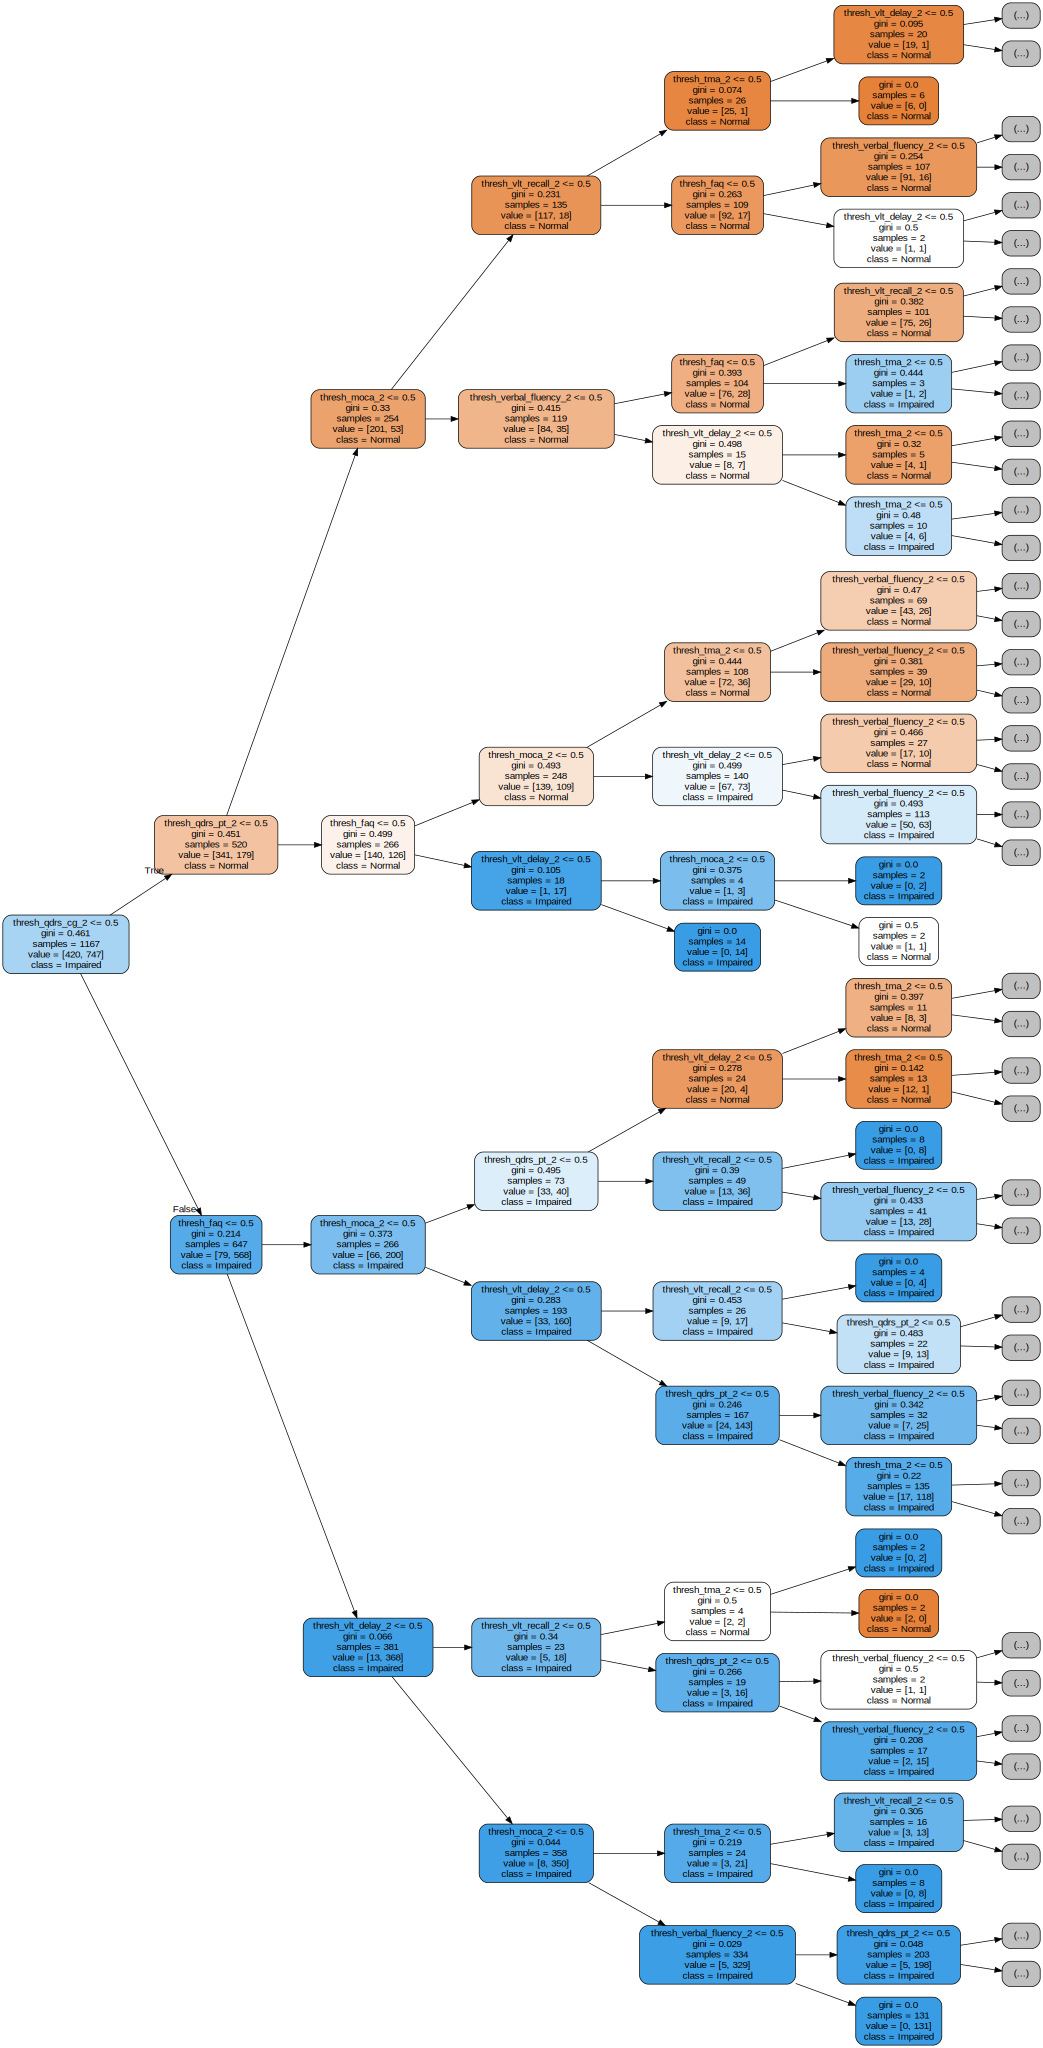

In [54]:
import graphviz
from sklearn.tree import export_graphviz

dot = export_graphviz(clf, out_file=None,
                     feature_names=adni_thresh.columns.values,
                     class_names=['Normal','Impaired'],
                     filled=True, rounded=True,
                     rotate=True, max_depth=5)

graph = graphviz.Source(dot)
# graph.render(filename='tree_thresh.gv', directory=f'{dir}/Output/', format='pdf')
graph

In [17]:
# from sklearn.tree import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=0)
clf.fit(adni_thresh, adni_us_y2.values.ravel())

y_test = clinic_us_y2
y_pred = clf.predict(clinic_thresh)
print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[107  18]
 [ 23 155]]
Accuracy: 	 0.8646864686468647
AUC: 		 0.8633932584269663
Precision: 	 0.8959537572254336
Recall: 	 0.8707865168539326


In [18]:
clf = MLPClassifier(hidden_layer_sizes=(105,75,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=0)
clf.fit(adni_thresh, adni_us_y2.values.ravel())


y_test = clinic_us_y2
y_pred = clf.predict(clinic_thresh)
print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[ 88  37]
 [ 23 155]]
Accuracy: 	 0.801980198019802
AUC: 		 0.7873932584269662
Precision: 	 0.8072916666666666
Recall: 	 0.8707865168539326


#### Totals decision tree

In [55]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(adni_totals, adni_us_y2)


y_test = clinic_us_y2
y_pred = clf.predict(clinic_totals)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[ 83  42]
 [ 26 152]]
Accuracy: 	 0.7755775577557755
AUC: 		 0.7589662921348314
Precision: 	 0.7835051546391752
Recall: 	 0.8539325842696629


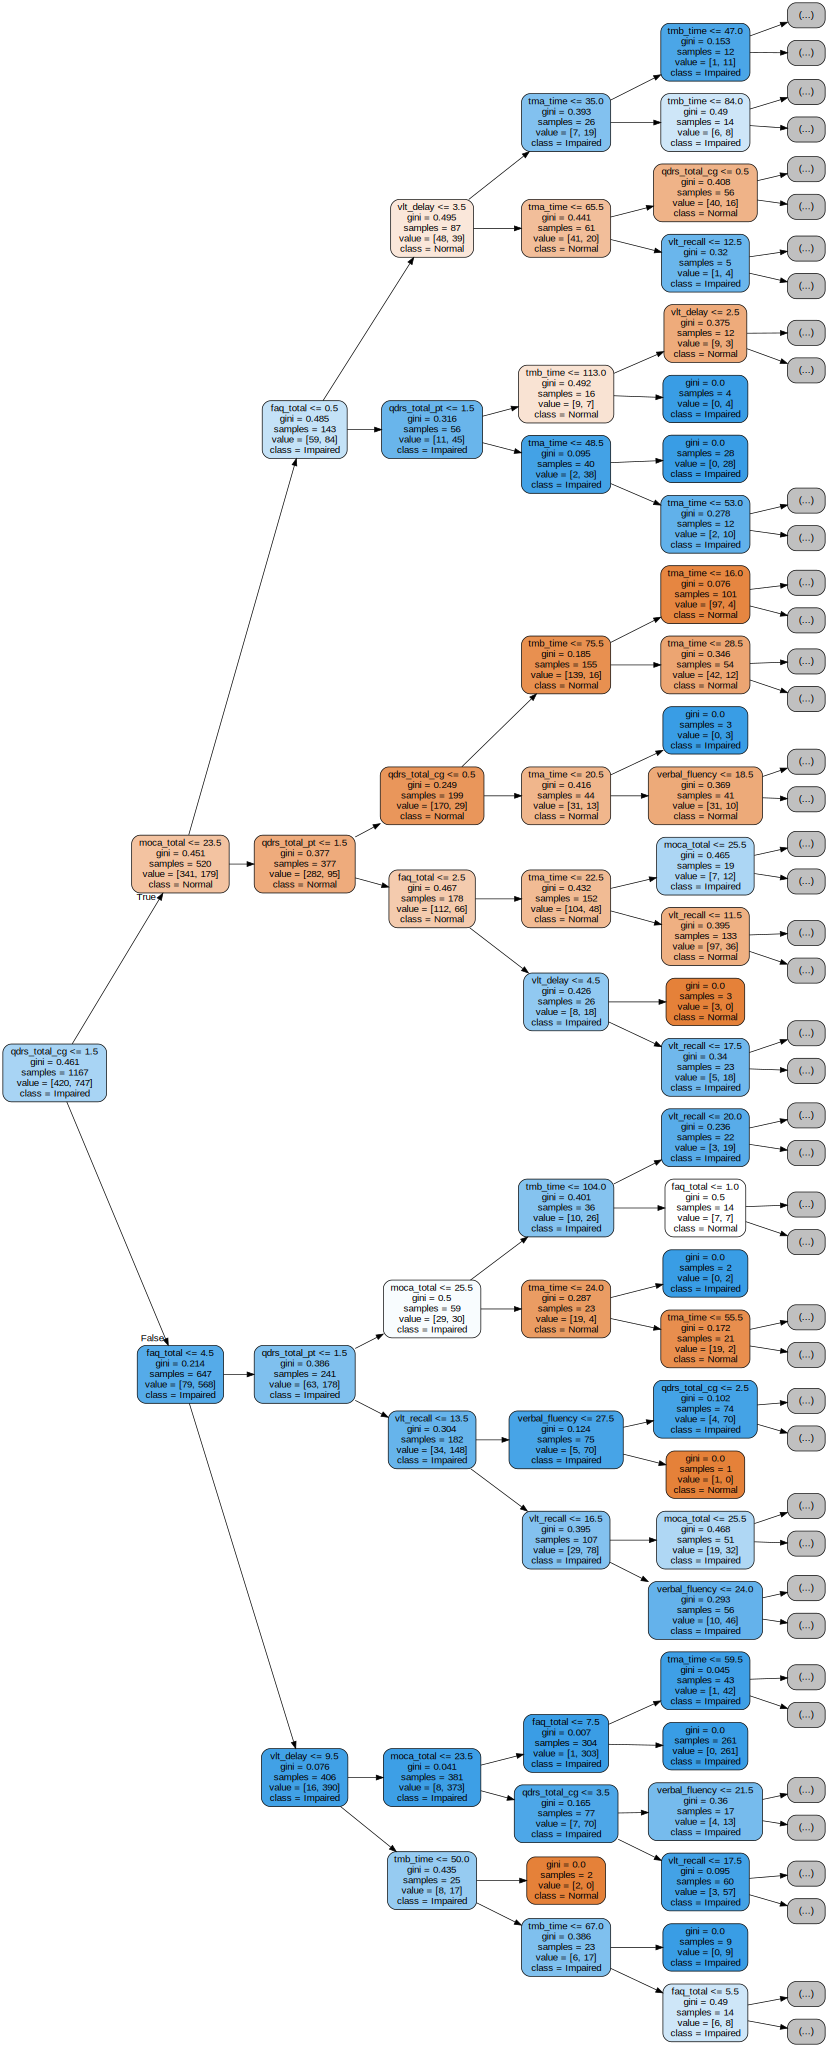

In [56]:
import graphviz
from sklearn.tree import export_graphviz

dot = export_graphviz(clf, out_file=None,
                     feature_names=adni_totals.columns.values,
                     class_names=['Normal','Impaired'],
                     filled=True, rounded=True,
                     rotate=True, max_depth=5)

graph = graphviz.Source(dot)
graph.render(filename='tree_totals.gv', directory=f'{dir}/Output/', format='pdf')
graph

In [20]:
clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=0)
clf.fit(adni_totals, adni_us_y2.values.ravel())


y_test = clinic_us_y2
y_pred = clf.predict(clinic_totals)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[ 88  37]
 [ 22 156]]
Accuracy: 	 0.8052805280528053
AUC: 		 0.7902022471910111
Precision: 	 0.8082901554404145
Recall: 	 0.8764044943820225


In [21]:
clf = MLPClassifier(hidden_layer_sizes=(105,75,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=0)
clf.fit(adni_separated, adni_us_y2.values.ravel())


y_test = clinic_us_y2
y_pred = clf.predict(clinic_separated)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[ 98  27]
 [ 31 147]]
Accuracy: 	 0.8085808580858086
AUC: 		 0.8049213483146068
Precision: 	 0.8448275862068966
Recall: 	 0.8258426966292135


#### Separated decision tree, random forest

In [57]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(adni_separated, adni_us_y2)


y_test = clinic_us_y2
y_pred = clf.predict(clinic_separated)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[ 92  33]
 [ 48 130]]
Accuracy: 	 0.7326732673267327
AUC: 		 0.7331685393258427
Precision: 	 0.7975460122699386
Recall: 	 0.7303370786516854


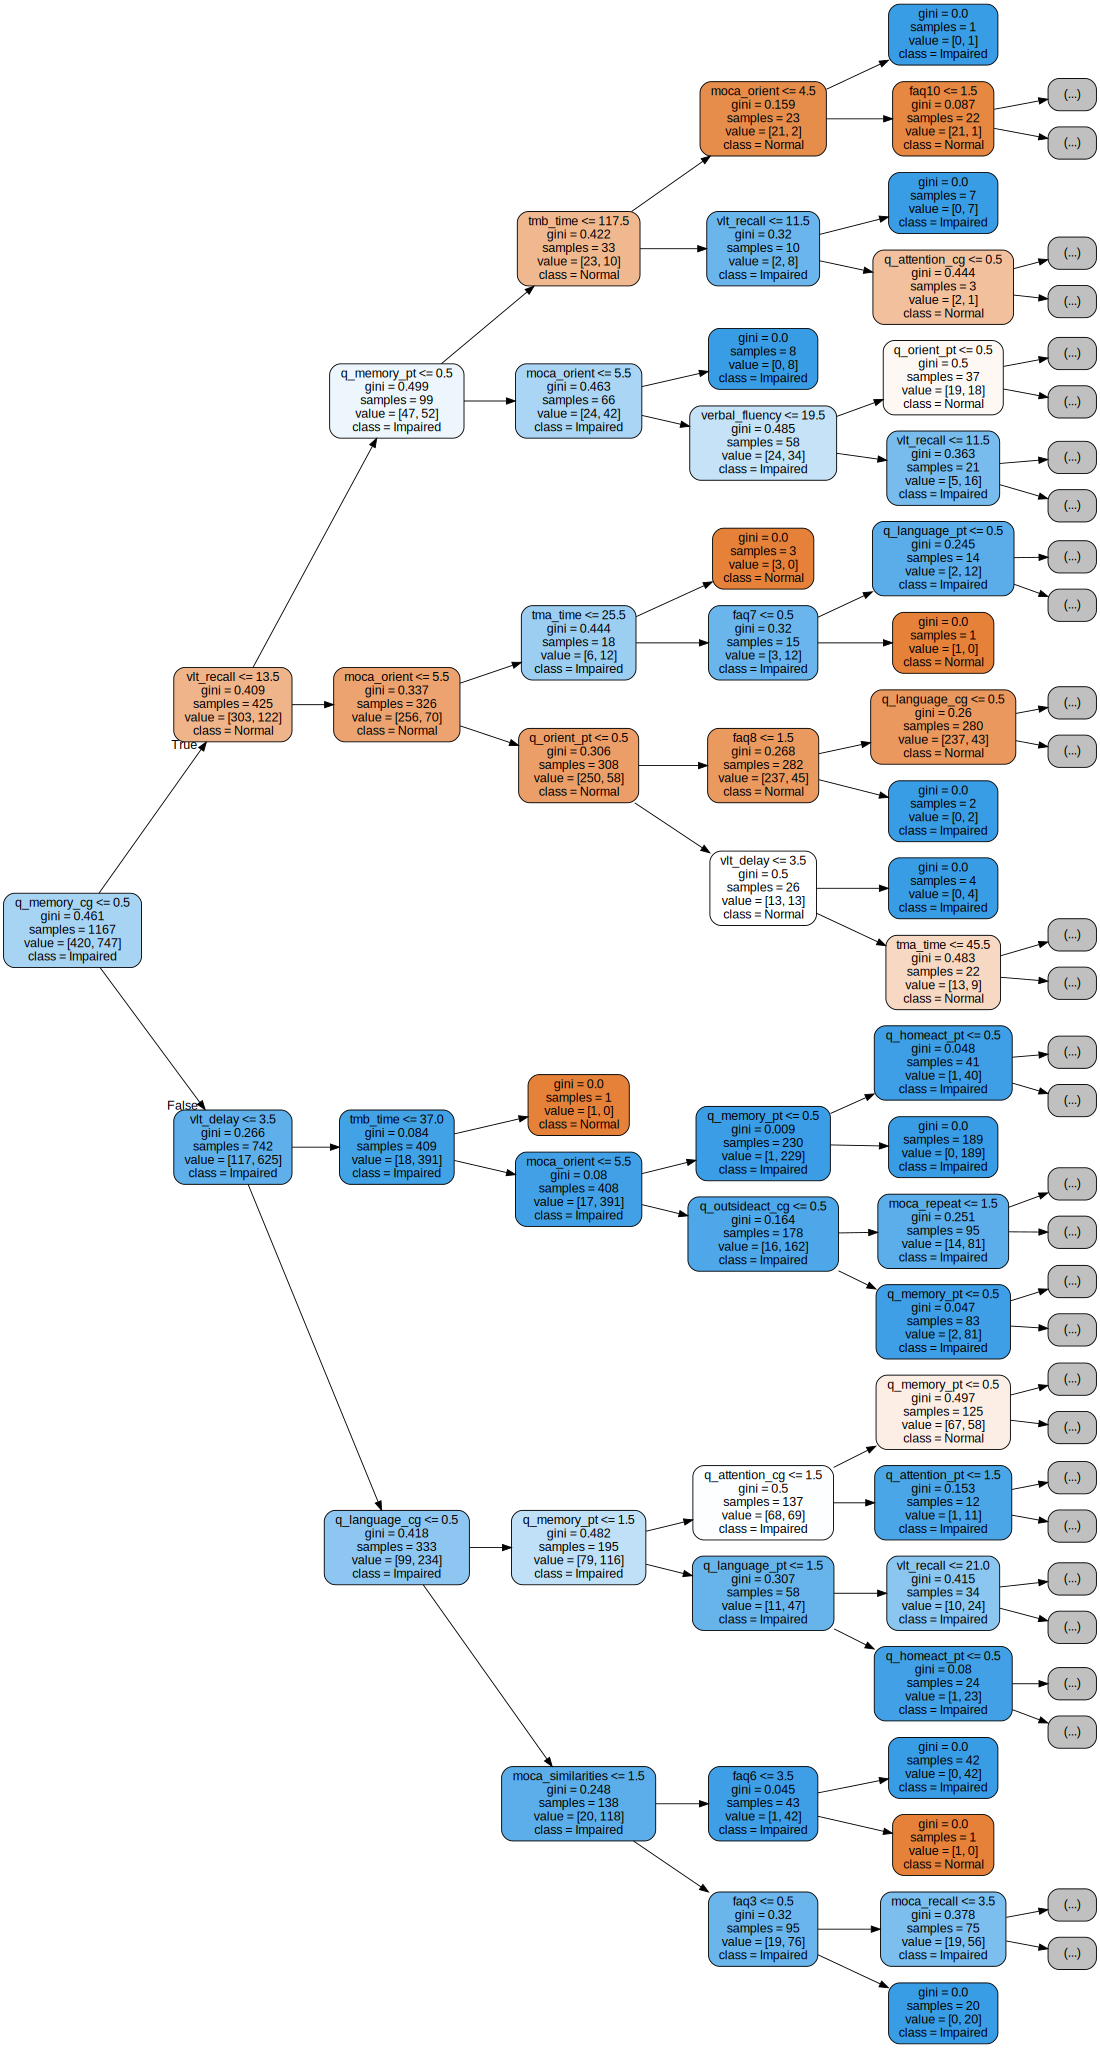

In [58]:
import graphviz
from sklearn.tree import export_graphviz

dot = export_graphviz(clf, out_file=None,
                     feature_names=adni_separated.columns.values,
                     class_names=['Normal','Impaired'],
                     filled=True, rounded=True,
                     rotate=True, max_depth=5)

graph = graphviz.Source(dot)
graph.render(filename='tree_separated.gv', directory=f'{dir}/Output/', format='pdf')
graph

In [23]:
clf = RandomForestClassifier(n_estimators=100, max_features=.5, random_state=0)
clf.fit(adni_separated, adni_us_y2.values.ravel())


y_test = clinic_us_y2
y_pred = clf.predict(clinic_separated)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[ 99  26]
 [ 38 140]]
Accuracy: 	 0.7887788778877888
AUC: 		 0.7892584269662923
Precision: 	 0.8433734939759037
Recall: 	 0.7865168539325843


In [24]:
clf = MLPClassifier(hidden_layer_sizes=(105,75,60,15), activation='relu', solver='sgd', alpha=.0001, learning_rate_init=.0005, max_iter=5000, random_state=0)
clf.fit(adni_separated, adni_us_y2.values.ravel())


y_test = clinic_us_y2
y_pred = clf.predict(clinic_separated)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: \t', accuracy_score(y_test, y_pred))
print('AUC: \t\t', roc_auc_score(y_test, y_pred))
print('Precision: \t', precision_score(y_test, y_pred))
print('Recall: \t', recall_score(y_test, y_pred))

[[ 98  27]
 [ 31 147]]
Accuracy: 	 0.8085808580858086
AUC: 		 0.8049213483146068
Precision: 	 0.8448275862068966
Recall: 	 0.8258426966292135
